In [1]:
import numpy as np
import pandas as pd
from scipy import signal as sg
import optuna
import matplotlib.pyplot as plt
import itertools

In [2]:
import sys
sys.path.append('..')

In [3]:
data_base = '../data/raw/dataIBM'
data_exts = '.csv'
targ_df = pd.read_csv(data_base+data_exts, header=None).astype('float64')

In [4]:
method = 3
grid_num_ = 20

In [5]:
def get_spc(idx, arg1, arg2=None, arg3=None):
    if idx == 0:
        from SpiCoder.Batch import TBR as SPC
        # f_factor: double[0:]
        return SPC(arg1)
    elif idx==1:
        from SpiCoder.Batch import SF as SPC
        # threshold: double[0:]
        return SPC(arg1)
    elif idx==2:
        from SpiCoder.Batch import MW as SPC
        # threshold: double[0:], window: int[1:]
        return SPC(arg1, arg2)
    else:
        from SpiCoder.Batch import BSA as SPC
        # threshold: double[0:], window: int[1:], :fc: double[0:0.5]
        return SPC(arg1, sg.firwin(arg2, arg3, fs=1))

In [6]:
def eval_coder(signal, spc, delay=None):
    enc = spc.encode(signal)
    dec = spc.decode(enc)
    if delay is not None:
        diff = signal[:-delay]-dec[delay:]
    else:
        diff = signal-dec
    return np.linalg.norm(diff)

In [7]:
def eval_arg(idx, arg1, arg2=None, arg3=None):
    if idx==1:
        delay=1
    elif idx==3:
        delay=arg2
    else:
        delay=None
    return eval_coder(targ_df.values.squeeze(), 
                       get_spc(idx, arg1, arg2, arg3),
                       delay=delay)

In [8]:
def plot_result(idx=method, arg1=None, arg2=None, arg3=None):
    spc = get_spc(idx, arg1, arg2, arg3)
    targ_df.plot();
    spce_df = pd.DataFrame(spc.encode(targ_df.values.squeeze()))
    spce_df.plot();
    spcd_df = pd.DataFrame(spc.decode(spce_df.values.squeeze()))
    spcd_df.plot();

In [9]:
def plot_result_co(idx=method, arg1=None, arg2=None, arg3=None):
    if idx==1:
        delay=1
    elif idx==3:
        delay=arg2
    else:
        delay=None
    fig = plt.figure(figsize=(20, 4))
    ax = fig.add_subplot(1,1,1)
    spc = get_spc(idx, arg1, arg2, arg3)
    spce_df = pd.DataFrame(spc.encode(targ_df.values.squeeze()))
    spcd_df = pd.DataFrame(spc.decode(spce_df.values.squeeze()))
    if delay is None:
        targ_df.plot(ax=ax)
        spcd_df.plot(ax=ax)
    else:
        ax.plot(targ_df.iloc[:-delay].values)
        ax.plot(spcd_df.iloc[delay:].values)

In [10]:
def objective(trial):
    # grid search at first
    if method is not None:
        idx = method
        grid_num = grid_num_
    else:
        idx = trial.suggest_int('idx', 0, 3)
        grid_num = None

    if idx == 0:
        rng1 = (0.0, 30.0)
        if (grid_num is not None) & (trial.number < grid_num**1):
            arg1g = np.linspace(*rng1, grid_num)[trial.number]
            arg1 = trial.suggest_uniform('arg1', arg1g, arg1g)
            arg2 = None
            arg3 = None
        else:
            arg1 = trial.suggest_uniform('arg1', *rng1)
            arg2 = None
            arg3 = None
    elif idx==1:
        rng1 = (0.0, 30.0)
        if (grid_num is not None) & (trial.number < grid_num**1):
            arg1g = np.linspace(*rng1, grid_num)[trial.number]
            arg1 = trial.suggest_uniform('arg1', arg1g, arg1g)
            arg2 = None
            arg3 = None
        else:
            arg1 = trial.suggest_uniform('arg1', *rng1)
            arg2 = None
            arg3 = None
    elif idx==2:
        rng1 = (5.0, 30.0)
        rng2 = (1, 25)
        if (grid_num is not None) & (trial.number < grid_num**2):
            arg1l = np.linspace(*rng1, grid_num)
            arg2l = np.linspace(*rng2, grid_num, dtype=int)
            arg1g, arg2g = list(itertools.product(arg1l, arg2l))[trial.number]
            arg1 = trial.suggest_uniform('arg1', arg1g, arg1g)
            arg2 = trial.suggest_int('arg2', arg2g, arg2g)
            arg3 = None
        else:
            arg1 = trial.suggest_uniform('arg1', *rng1)
            arg2 = trial.suggest_int('arg2', *rng2)
            arg3 = None
    else:
        rng1 = (0.0, 30.0)
        rng2 = (1, 25)
        rng3 = (1e-6, 0.5-1e-6)
        if (grid_num is not None) & (trial.number < grid_num**3):
            arg1l = np.linspace(*rng1, grid_num)
            arg2l = np.linspace(*rng2, grid_num, dtype=int)
            arg3l = np.geomspace(*rng3, grid_num)
            arg1g, arg2g, arg3g = list(itertools.product(arg1l, arg2l, arg3l)
                                      )[::-1][trial.number]
            arg1 = trial.suggest_uniform('arg1', arg1g, arg1g)
            arg2 = trial.suggest_int('arg2', arg2g, arg2g)
            arg3 = trial.suggest_loguniform('arg3', arg3g, arg3g)
        else:
            arg1 = trial.suggest_uniform('arg1', *rng1)
            arg2 = trial.suggest_int('arg2', *rng2)
            arg3 = trial.suggest_loguniform('arg3', *rng3)

    return eval_arg(idx, arg1, arg2=arg2, arg3=arg3)

In [11]:
study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=84))
study.optimize(objective, n_trials=1000+(grid_num_**3), n_jobs=8)

[I 2020-05-31 16:23:37,204] Finished trial#1 with value: 3678.7499235473997 with parameters: {'arg1': 30.0, 'arg2': 25, 'arg3': 0.25062442395130746}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:23:37,270] Finished trial#4 with value: 3678.7499235473997 with parameters: {'arg1': 30.0, 'arg2': 25, 'arg3': 0.03156357302147167}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:23:37,308] Finished trial#0 with value: 3678.7499235473997 with parameters: {'arg1': 30.0, 'arg2': 25, 'arg3': 0.499999}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:23:37,360] Finished trial#2 with value: 3678.7499235473997 with parameters: {'arg1': 30.0, 'arg2': 25, 'arg3': 0.12562545501275935}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:23:37,361] Finished trial#3 with value: 3678.7499235473997 with parameters: {'arg1': 30.0, 'arg2': 25, 'arg3': 0.06296974053186842}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:23:3

[I 2020-05-31 16:23:38,887] Finished trial#41 with value: 3679.421421908613 with parameters: {'arg1': 30.0, 'arg2': 22, 'arg3': 0.25062442395130746}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:23:38,928] Finished trial#42 with value: 3679.421421908613 with parameters: {'arg1': 30.0, 'arg2': 22, 'arg3': 0.12562545501275935}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:23:38,968] Finished trial#43 with value: 3679.421421908613 with parameters: {'arg1': 30.0, 'arg2': 22, 'arg3': 0.06296974053186842}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:23:39,008] Finished trial#44 with value: 3679.421421908613 with parameters: {'arg1': 30.0, 'arg2': 22, 'arg3': 0.03156357302147167}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:23:39,047] Finished trial#45 with value: 3679.421421908613 with parameters: {'arg1': 30.0, 'arg2': 22, 'arg3': 0.01582123625517523}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05

[I 2020-05-31 16:23:40,607] Finished trial#82 with value: 3680.581204103504 with parameters: {'arg1': 30.0, 'arg2': 19, 'arg3': 0.12562545501275935}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:23:40,650] Finished trial#83 with value: 3680.581204103504 with parameters: {'arg1': 30.0, 'arg2': 19, 'arg3': 0.06296974053186842}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:23:40,688] Finished trial#84 with value: 3680.581204103504 with parameters: {'arg1': 30.0, 'arg2': 19, 'arg3': 0.03156357302147167}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:23:40,729] Finished trial#85 with value: 3680.581204103504 with parameters: {'arg1': 30.0, 'arg2': 19, 'arg3': 0.01582123625517523}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:23:40,768] Finished trial#86 with value: 3680.581204103504 with parameters: {'arg1': 30.0, 'arg2': 19, 'arg3': 0.007930392306086265}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-0

[I 2020-05-31 16:23:42,264] Finished trial#123 with value: 3681.451751687098 with parameters: {'arg1': 30.0, 'arg2': 17, 'arg3': 0.06296974053186842}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:23:42,303] Finished trial#124 with value: 3681.451751687098 with parameters: {'arg1': 30.0, 'arg2': 17, 'arg3': 0.03156357302147167}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:23:42,340] Finished trial#125 with value: 3681.451751687098 with parameters: {'arg1': 30.0, 'arg2': 17, 'arg3': 0.01582123625517523}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:23:42,380] Finished trial#126 with value: 3681.451751687098 with parameters: {'arg1': 30.0, 'arg2': 17, 'arg3': 0.007930392306086265}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:23:42,422] Finished trial#127 with value: 3681.451751687098 with parameters: {'arg1': 30.0, 'arg2': 17, 'arg3': 0.003975107957057414}. Best is trial#1 with value: 3678.7499235473997.
[I 

[I 2020-05-31 16:23:43,888] Finished trial#164 with value: 3682.6225709404434 with parameters: {'arg1': 30.0, 'arg2': 14, 'arg3': 0.03156357302147167}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:23:43,928] Finished trial#165 with value: 3682.6225709404434 with parameters: {'arg1': 30.0, 'arg2': 14, 'arg3': 0.01582123625517523}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:23:43,968] Finished trial#166 with value: 3682.6225709404434 with parameters: {'arg1': 30.0, 'arg2': 14, 'arg3': 0.007930392306086265}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:23:44,011] Finished trial#167 with value: 3682.6225709404434 with parameters: {'arg1': 30.0, 'arg2': 14, 'arg3': 0.003975107957057414}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:23:44,050] Finished trial#168 with value: 3682.6225709404434 with parameters: {'arg1': 30.0, 'arg2': 14, 'arg3': 0.001992522268808082}. Best is trial#1 with value: 3678.749923547399

[I 2020-05-31 16:23:45,505] Finished trial#204 with value: 3683.3863495430396 with parameters: {'arg1': 30.0, 'arg2': 12, 'arg3': 0.03156357302147167}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:23:45,545] Finished trial#205 with value: 3683.3863495430396 with parameters: {'arg1': 30.0, 'arg2': 12, 'arg3': 0.01582123625517523}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:23:45,586] Finished trial#206 with value: 3683.3863495430396 with parameters: {'arg1': 30.0, 'arg2': 12, 'arg3': 0.007930392306086265}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:23:45,627] Finished trial#207 with value: 3683.3863495430396 with parameters: {'arg1': 30.0, 'arg2': 12, 'arg3': 0.003975107957057414}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:23:45,667] Finished trial#208 with value: 3683.3863495430396 with parameters: {'arg1': 30.0, 'arg2': 12, 'arg3': 0.001992522268808082}. Best is trial#1 with value: 3678.749923547399

[I 2020-05-31 16:23:47,209] Finished trial#245 with value: 3684.1374838624033 with parameters: {'arg1': 30.0, 'arg2': 9, 'arg3': 0.01582123625517523}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:23:47,249] Finished trial#246 with value: 3684.1374838624033 with parameters: {'arg1': 30.0, 'arg2': 9, 'arg3': 0.007930392306086265}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:23:47,287] Finished trial#247 with value: 3684.1374838624033 with parameters: {'arg1': 30.0, 'arg2': 9, 'arg3': 0.003975107957057414}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:23:47,327] Finished trial#248 with value: 3684.1374838624033 with parameters: {'arg1': 30.0, 'arg2': 9, 'arg3': 0.001992522268808082}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:23:47,365] Finished trial#249 with value: 3684.1374838624033 with parameters: {'arg1': 30.0, 'arg2': 9, 'arg3': 0.0009987514891633324}. Best is trial#1 with value: 3678.7499235473997.


[I 2020-05-31 16:23:48,864] Finished trial#286 with value: 3684.3725381671165 with parameters: {'arg1': 30.0, 'arg2': 7, 'arg3': 0.007930392306086265}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:23:48,905] Finished trial#287 with value: 3684.3725381671165 with parameters: {'arg1': 30.0, 'arg2': 7, 'arg3': 0.003975107957057414}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:23:48,946] Finished trial#288 with value: 3684.3725381671165 with parameters: {'arg1': 30.0, 'arg2': 7, 'arg3': 0.001992522268808082}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:23:48,986] Finished trial#289 with value: 3684.3725381671165 with parameters: {'arg1': 30.0, 'arg2': 7, 'arg3': 0.0009987514891633324}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:23:49,024] Finished trial#290 with value: 3684.3725381671165 with parameters: {'arg1': 30.0, 'arg2': 7, 'arg3': 0.0005006240345322101}. Best is trial#1 with value: 3678.7499235473997

[I 2020-05-31 16:23:50,515] Finished trial#327 with value: 3684.8115284231294 with parameters: {'arg1': 30.0, 'arg2': 4, 'arg3': 0.003975107957057414}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:23:50,554] Finished trial#328 with value: 3684.8115284231294 with parameters: {'arg1': 30.0, 'arg2': 4, 'arg3': 0.001992522268808082}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:23:50,595] Finished trial#329 with value: 3684.8115284231294 with parameters: {'arg1': 30.0, 'arg2': 4, 'arg3': 0.0009987514891633324}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:23:50,638] Finished trial#330 with value: 3684.8115284231294 with parameters: {'arg1': 30.0, 'arg2': 4, 'arg3': 0.0005006240345322101}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:23:50,678] Finished trial#331 with value: 3684.8115284231294 with parameters: {'arg1': 30.0, 'arg2': 4, 'arg3': 0.0002509377224170739}. Best is trial#1 with value: 3678.749923547399

[I 2020-05-31 16:23:52,198] Finished trial#368 with value: 3685.3157259589034 with parameters: {'arg1': 30.0, 'arg2': 2, 'arg3': 0.001992522268808082}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:23:52,237] Finished trial#369 with value: 3685.3157259589034 with parameters: {'arg1': 30.0, 'arg2': 2, 'arg3': 0.0009987514891633324}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:23:52,278] Finished trial#370 with value: 3685.3157259589034 with parameters: {'arg1': 30.0, 'arg2': 2, 'arg3': 0.0005006240345322101}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:23:52,318] Finished trial#371 with value: 3685.3157259589034 with parameters: {'arg1': 30.0, 'arg2': 2, 'arg3': 0.0002509377224170739}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:23:52,358] Finished trial#372 with value: 3685.3157259589034 with parameters: {'arg1': 30.0, 'arg2': 2, 'arg3': 0.00012578249582185605}. Best is trial#1 with value: 3678.7499235473

[I 2020-05-31 16:23:53,821] Finished trial#408 with value: 3678.7499235473997 with parameters: {'arg1': 28.42105263157895, 'arg2': 25, 'arg3': 0.001992522268808082}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:23:53,860] Finished trial#409 with value: 3678.7499235473997 with parameters: {'arg1': 28.42105263157895, 'arg2': 25, 'arg3': 0.0009987514891633324}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:23:53,901] Finished trial#410 with value: 3678.7499235473997 with parameters: {'arg1': 28.42105263157895, 'arg2': 25, 'arg3': 0.0005006240345322101}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:23:53,941] Finished trial#411 with value: 3678.7499235473997 with parameters: {'arg1': 28.42105263157895, 'arg2': 25, 'arg3': 0.0002509377224170739}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:23:53,981] Finished trial#412 with value: 3678.7499235473997 with parameters: {'arg1': 28.42105263157895, 'arg2': 25, 'arg3'

[I 2020-05-31 16:23:55,338] Finished trial#446 with value: 3679.421421908613 with parameters: {'arg1': 28.42105263157895, 'arg2': 22, 'arg3': 0.007930392306086265}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:23:55,378] Finished trial#447 with value: 3679.421421908613 with parameters: {'arg1': 28.42105263157895, 'arg2': 22, 'arg3': 0.003975107957057414}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:23:55,420] Finished trial#448 with value: 3679.421421908613 with parameters: {'arg1': 28.42105263157895, 'arg2': 22, 'arg3': 0.001992522268808082}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:23:55,461] Finished trial#449 with value: 3679.421421908613 with parameters: {'arg1': 28.42105263157895, 'arg2': 22, 'arg3': 0.0009987514891633324}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:23:55,502] Finished trial#450 with value: 3679.421421908613 with parameters: {'arg1': 28.42105263157895, 'arg2': 22, 'arg3': 0.000

[I 2020-05-31 16:23:56,911] Finished trial#484 with value: 3680.581204103504 with parameters: {'arg1': 28.42105263157895, 'arg2': 19, 'arg3': 0.03156357302147167}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:23:56,952] Finished trial#485 with value: 3680.581204103504 with parameters: {'arg1': 28.42105263157895, 'arg2': 19, 'arg3': 0.01582123625517523}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:23:56,999] Finished trial#486 with value: 3680.581204103504 with parameters: {'arg1': 28.42105263157895, 'arg2': 19, 'arg3': 0.007930392306086265}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:23:57,039] Finished trial#487 with value: 3680.581204103504 with parameters: {'arg1': 28.42105263157895, 'arg2': 19, 'arg3': 0.003975107957057414}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:23:57,086] Finished trial#488 with value: 3680.581204103504 with parameters: {'arg1': 28.42105263157895, 'arg2': 19, 'arg3': 0.001992

[I 2020-05-31 16:23:58,500] Finished trial#522 with value: 3681.451751687098 with parameters: {'arg1': 28.42105263157895, 'arg2': 17, 'arg3': 0.12562545501275935}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:23:58,542] Finished trial#523 with value: 3681.451751687098 with parameters: {'arg1': 28.42105263157895, 'arg2': 17, 'arg3': 0.06296974053186842}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:23:58,581] Finished trial#524 with value: 3681.451751687098 with parameters: {'arg1': 28.42105263157895, 'arg2': 17, 'arg3': 0.03156357302147167}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:23:58,624] Finished trial#525 with value: 3681.451751687098 with parameters: {'arg1': 28.42105263157895, 'arg2': 17, 'arg3': 0.01582123625517523}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:23:58,667] Finished trial#526 with value: 3681.451751687098 with parameters: {'arg1': 28.42105263157895, 'arg2': 17, 'arg3': 0.00793039

[I 2020-05-31 16:24:00,046] Finished trial#560 with value: 3682.6225709404434 with parameters: {'arg1': 28.42105263157895, 'arg2': 14, 'arg3': 0.499999}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:00,093] Finished trial#561 with value: 3682.6225709404434 with parameters: {'arg1': 28.42105263157895, 'arg2': 14, 'arg3': 0.25062442395130746}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:00,133] Finished trial#562 with value: 3682.6225709404434 with parameters: {'arg1': 28.42105263157895, 'arg2': 14, 'arg3': 0.12562545501275935}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:00,173] Finished trial#563 with value: 3682.6225709404434 with parameters: {'arg1': 28.42105263157895, 'arg2': 14, 'arg3': 0.06296974053186842}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:00,214] Finished trial#564 with value: 3682.6225709404434 with parameters: {'arg1': 28.42105263157895, 'arg2': 14, 'arg3': 0.03156357302147

[I 2020-05-31 16:24:01,657] Finished trial#598 with value: 3682.9756990781243 with parameters: {'arg1': 28.42105263157895, 'arg2': 13, 'arg3': 1.995013064238075e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:01,700] Finished trial#599 with value: 3682.9756990781243 with parameters: {'arg1': 28.42105263157895, 'arg2': 13, 'arg3': 1e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:01,739] Finished trial#600 with value: 3683.3863495430396 with parameters: {'arg1': 28.42105263157895, 'arg2': 12, 'arg3': 0.499999}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:01,780] Finished trial#601 with value: 3683.3863495430396 with parameters: {'arg1': 28.42105263157895, 'arg2': 12, 'arg3': 0.25062442395130746}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:01,824] Finished trial#602 with value: 3683.3863495430396 with parameters: {'arg1': 28.42105263157895, 'arg2': 12, 'arg3': 0.12562545501275935}. Best i

[I 2020-05-31 16:24:03,258] Finished trial#636 with value: 3683.712258035364 with parameters: {'arg1': 28.42105263157895, 'arg2': 11, 'arg3': 7.940305864003923e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:03,299] Finished trial#637 with value: 3683.712258035364 with parameters: {'arg1': 28.42105263157895, 'arg2': 11, 'arg3': 3.980077126480593e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:03,342] Finished trial#638 with value: 3683.712258035364 with parameters: {'arg1': 28.42105263157895, 'arg2': 11, 'arg3': 1.995013064238075e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:03,389] Finished trial#639 with value: 3683.712258035364 with parameters: {'arg1': 28.42105263157895, 'arg2': 11, 'arg3': 1e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:03,438] Finished trial#640 with value: 3684.1374838624033 with parameters: {'arg1': 28.42105263157895, 'arg2': 9, 'arg3': 0.499999}. Best is

[I 2020-05-31 16:24:04,980] Finished trial#674 with value: 3684.2156560114663 with parameters: {'arg1': 28.42105263157895, 'arg2': 8, 'arg3': 3.160302974658181e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:05,023] Finished trial#675 with value: 3684.2156560114663 with parameters: {'arg1': 28.42105263157895, 'arg2': 8, 'arg3': 1.584101393273402e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:05,078] Finished trial#676 with value: 3684.2156560114663 with parameters: {'arg1': 28.42105263157895, 'arg2': 8, 'arg3': 7.940305864003923e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:05,119] Finished trial#677 with value: 3684.2156560114663 with parameters: {'arg1': 28.42105263157895, 'arg2': 8, 'arg3': 3.980077126480593e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:05,159] Finished trial#678 with value: 3684.2156560114663 with parameters: {'arg1': 28.42105263157895, 'arg2': 8, 'arg3': 1.

[I 2020-05-31 16:24:06,573] Finished trial#712 with value: 3684.520321561546 with parameters: {'arg1': 28.42105263157895, 'arg2': 6, 'arg3': 0.00012578249582185605}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:06,614] Finished trial#713 with value: 3684.520321561546 with parameters: {'arg1': 28.42105263157895, 'arg2': 6, 'arg3': 6.30484572139352e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:06,654] Finished trial#714 with value: 3684.520321561546 with parameters: {'arg1': 28.42105263157895, 'arg2': 6, 'arg3': 3.160302974658181e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:06,695] Finished trial#715 with value: 3684.520321561546 with parameters: {'arg1': 28.42105263157895, 'arg2': 6, 'arg3': 1.584101393273402e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:06,734] Finished trial#716 with value: 3684.520321561546 with parameters: {'arg1': 28.42105263157895, 'arg2': 6, 'arg3': 7.94030

[I 2020-05-31 16:24:08,118] Finished trial#750 with value: 3685.098641827651 with parameters: {'arg1': 28.42105263157895, 'arg2': 3, 'arg3': 0.0005006240345322101}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:08,157] Finished trial#751 with value: 3685.098641827651 with parameters: {'arg1': 28.42105263157895, 'arg2': 3, 'arg3': 0.0002509377224170739}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:08,198] Finished trial#752 with value: 3685.098641827651 with parameters: {'arg1': 28.42105263157895, 'arg2': 3, 'arg3': 0.00012578249582185605}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:08,236] Finished trial#753 with value: 3685.098641827651 with parameters: {'arg1': 28.42105263157895, 'arg2': 3, 'arg3': 6.30484572139352e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:08,274] Finished trial#754 with value: 3685.098641827651 with parameters: {'arg1': 28.42105263157895, 'arg2': 3, 'arg3': 3.16030

[I 2020-05-31 16:24:09,657] Finished trial#788 with value: 3685.602800085761 with parameters: {'arg1': 28.42105263157895, 'arg2': 1, 'arg3': 0.001992522268808082}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:09,699] Finished trial#789 with value: 3685.602800085761 with parameters: {'arg1': 28.42105263157895, 'arg2': 1, 'arg3': 0.0009987514891633324}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:09,740] Finished trial#790 with value: 3685.602800085761 with parameters: {'arg1': 28.42105263157895, 'arg2': 1, 'arg3': 0.0005006240345322101}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:09,783] Finished trial#791 with value: 3685.602800085761 with parameters: {'arg1': 28.42105263157895, 'arg2': 1, 'arg3': 0.0002509377224170739}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:09,823] Finished trial#792 with value: 3685.602800085761 with parameters: {'arg1': 28.42105263157895, 'arg2': 1, 'arg3': 0.000125

[I 2020-05-31 16:24:11,270] Finished trial#826 with value: 3679.1701509987274 with parameters: {'arg1': 26.842105263157894, 'arg2': 23, 'arg3': 0.007930392306086265}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:11,314] Finished trial#827 with value: 3679.1701509987274 with parameters: {'arg1': 26.842105263157894, 'arg2': 23, 'arg3': 0.003975107957057414}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:11,359] Finished trial#828 with value: 3679.1701509987274 with parameters: {'arg1': 26.842105263157894, 'arg2': 23, 'arg3': 0.001992522268808082}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:11,400] Finished trial#829 with value: 3679.1701509987274 with parameters: {'arg1': 26.842105263157894, 'arg2': 23, 'arg3': 0.0009987514891633324}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:11,440] Finished trial#830 with value: 3679.1701509987274 with parameters: {'arg1': 26.842105263157894, 'arg2': 23, 'ar

[I 2020-05-31 16:24:12,825] Finished trial#864 with value: 3679.788852638151 with parameters: {'arg1': 26.842105263157894, 'arg2': 21, 'arg3': 0.03156357302147167}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:12,864] Finished trial#865 with value: 3679.788852638151 with parameters: {'arg1': 26.842105263157894, 'arg2': 21, 'arg3': 0.01582123625517523}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:12,904] Finished trial#866 with value: 3679.788852638151 with parameters: {'arg1': 26.842105263157894, 'arg2': 21, 'arg3': 0.007930392306086265}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:12,946] Finished trial#867 with value: 3679.788852638151 with parameters: {'arg1': 26.842105263157894, 'arg2': 21, 'arg3': 0.003975107957057414}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:12,986] Finished trial#868 with value: 3679.788852638151 with parameters: {'arg1': 26.842105263157894, 'arg2': 21, 'arg3': 0.0

[I 2020-05-31 16:24:14,405] Finished trial#902 with value: 3681.070224812344 with parameters: {'arg1': 26.842105263157894, 'arg2': 18, 'arg3': 0.12562545501275935}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:14,448] Finished trial#903 with value: 3681.070224812344 with parameters: {'arg1': 26.842105263157894, 'arg2': 18, 'arg3': 0.06296974053186842}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:14,487] Finished trial#904 with value: 3681.070224812344 with parameters: {'arg1': 26.842105263157894, 'arg2': 18, 'arg3': 0.03156357302147167}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:14,527] Finished trial#905 with value: 3681.070224812344 with parameters: {'arg1': 26.842105263157894, 'arg2': 18, 'arg3': 0.01582123625517523}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:14,567] Finished trial#906 with value: 3681.070224812344 with parameters: {'arg1': 26.842105263157894, 'arg2': 18, 'arg3': 0.007

[I 2020-05-31 16:24:16,041] Finished trial#940 with value: 3681.7912759959654 with parameters: {'arg1': 26.842105263157894, 'arg2': 16, 'arg3': 0.499999}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:16,091] Finished trial#941 with value: 3681.7912759959654 with parameters: {'arg1': 26.842105263157894, 'arg2': 16, 'arg3': 0.25062442395130746}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:16,134] Finished trial#942 with value: 3681.7912759959654 with parameters: {'arg1': 26.842105263157894, 'arg2': 16, 'arg3': 0.12562545501275935}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:16,175] Finished trial#943 with value: 3681.7912759959654 with parameters: {'arg1': 26.842105263157894, 'arg2': 16, 'arg3': 0.06296974053186842}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:16,219] Finished trial#944 with value: 3681.7912759959654 with parameters: {'arg1': 26.842105263157894, 'arg2': 16, 'arg3': 0.031563573

[I 2020-05-31 16:24:17,649] Finished trial#978 with value: 3682.6225709404434 with parameters: {'arg1': 26.842105263157894, 'arg2': 14, 'arg3': 1.995013064238075e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:17,690] Finished trial#979 with value: 3682.6225709404434 with parameters: {'arg1': 26.842105263157894, 'arg2': 14, 'arg3': 1e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:17,733] Finished trial#980 with value: 3682.9756990781243 with parameters: {'arg1': 26.842105263157894, 'arg2': 13, 'arg3': 0.499999}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:17,776] Finished trial#981 with value: 3682.9756990781243 with parameters: {'arg1': 26.842105263157894, 'arg2': 13, 'arg3': 0.25062442395130746}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:17,817] Finished trial#982 with value: 3682.9756990781243 with parameters: {'arg1': 26.842105263157894, 'arg2': 13, 'arg3': 0.12562545501275935}. B

[I 2020-05-31 16:24:19,283] Finished trial#1016 with value: 3683.3863495430396 with parameters: {'arg1': 26.842105263157894, 'arg2': 12, 'arg3': 7.940305864003923e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:19,324] Finished trial#1017 with value: 3683.3863495430396 with parameters: {'arg1': 26.842105263157894, 'arg2': 12, 'arg3': 3.980077126480593e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:19,365] Finished trial#1018 with value: 3683.3863495430396 with parameters: {'arg1': 26.842105263157894, 'arg2': 12, 'arg3': 1.995013064238075e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:19,407] Finished trial#1019 with value: 3683.3863495430396 with parameters: {'arg1': 26.842105263157894, 'arg2': 12, 'arg3': 1e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:19,451] Finished trial#1020 with value: 3683.712258035364 with parameters: {'arg1': 26.842105263157894, 'arg2': 11, 'arg3': 0.49

[I 2020-05-31 16:24:20,855] Finished trial#1054 with value: 3684.1374838624033 with parameters: {'arg1': 26.842105263157894, 'arg2': 9, 'arg3': 3.160302974658181e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:20,896] Finished trial#1055 with value: 3684.1374838624033 with parameters: {'arg1': 26.842105263157894, 'arg2': 9, 'arg3': 1.584101393273402e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:20,937] Finished trial#1056 with value: 3684.1374838624033 with parameters: {'arg1': 26.842105263157894, 'arg2': 9, 'arg3': 7.940305864003923e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:20,979] Finished trial#1057 with value: 3684.1374838624033 with parameters: {'arg1': 26.842105263157894, 'arg2': 9, 'arg3': 3.980077126480593e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:21,025] Finished trial#1058 with value: 3684.1374838624033 with parameters: {'arg1': 26.842105263157894, 'arg2': 9, 

[I 2020-05-31 16:24:22,613] Finished trial#1092 with value: 3684.3725381671165 with parameters: {'arg1': 26.842105263157894, 'arg2': 7, 'arg3': 0.00012578249582185605}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:22,661] Finished trial#1093 with value: 3684.3725381671165 with parameters: {'arg1': 26.842105263157894, 'arg2': 7, 'arg3': 6.30484572139352e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:22,703] Finished trial#1094 with value: 3684.3725381671165 with parameters: {'arg1': 26.842105263157894, 'arg2': 7, 'arg3': 3.160302974658181e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:22,748] Finished trial#1095 with value: 3684.3725381671165 with parameters: {'arg1': 26.842105263157894, 'arg2': 7, 'arg3': 1.584101393273402e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:22,788] Finished trial#1096 with value: 3684.3725381671165 with parameters: {'arg1': 26.842105263157894, 'arg2': 7, 

[I 2020-05-31 16:24:24,224] Finished trial#1130 with value: 3684.8115284231294 with parameters: {'arg1': 26.842105263157894, 'arg2': 4, 'arg3': 0.0005006240345322101}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:24,265] Finished trial#1131 with value: 3684.8115284231294 with parameters: {'arg1': 26.842105263157894, 'arg2': 4, 'arg3': 0.0002509377224170739}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:24,305] Finished trial#1132 with value: 3684.8115284231294 with parameters: {'arg1': 26.842105263157894, 'arg2': 4, 'arg3': 0.00012578249582185605}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:24,346] Finished trial#1133 with value: 3684.8115284231294 with parameters: {'arg1': 26.842105263157894, 'arg2': 4, 'arg3': 6.30484572139352e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:24,387] Finished trial#1134 with value: 3684.8115284231294 with parameters: {'arg1': 26.842105263157894, 'arg2': 4, 

[I 2020-05-31 16:24:25,816] Finished trial#1168 with value: 3685.3157259589034 with parameters: {'arg1': 26.842105263157894, 'arg2': 2, 'arg3': 0.001992522268808082}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:25,858] Finished trial#1169 with value: 3685.3157259589034 with parameters: {'arg1': 26.842105263157894, 'arg2': 2, 'arg3': 0.0009987514891633324}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:25,901] Finished trial#1170 with value: 3685.3157259589034 with parameters: {'arg1': 26.842105263157894, 'arg2': 2, 'arg3': 0.0005006240345322101}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:25,940] Finished trial#1171 with value: 3685.3157259589034 with parameters: {'arg1': 26.842105263157894, 'arg2': 2, 'arg3': 0.0002509377224170739}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:25,982] Finished trial#1172 with value: 3685.3157259589034 with parameters: {'arg1': 26.842105263157894, 'arg2': 2, '

[I 2020-05-31 16:24:27,437] Finished trial#1206 with value: 3678.7499235473997 with parameters: {'arg1': 25.263157894736842, 'arg2': 25, 'arg3': 0.007930392306086265}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:27,485] Finished trial#1207 with value: 3678.7499235473997 with parameters: {'arg1': 25.263157894736842, 'arg2': 25, 'arg3': 0.003975107957057414}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:27,528] Finished trial#1208 with value: 3678.7499235473997 with parameters: {'arg1': 25.263157894736842, 'arg2': 25, 'arg3': 0.001992522268808082}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:27,573] Finished trial#1209 with value: 3678.7499235473997 with parameters: {'arg1': 25.263157894736842, 'arg2': 25, 'arg3': 0.0009987514891633324}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:27,618] Finished trial#1210 with value: 3678.7499235473997 with parameters: {'arg1': 25.263157894736842, 'arg2': 25

[I 2020-05-31 16:24:29,175] Finished trial#1244 with value: 3679.421421908613 with parameters: {'arg1': 25.263157894736842, 'arg2': 22, 'arg3': 0.03156357302147167}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:29,218] Finished trial#1245 with value: 3679.421421908613 with parameters: {'arg1': 25.263157894736842, 'arg2': 22, 'arg3': 0.01582123625517523}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:29,261] Finished trial#1246 with value: 3679.421421908613 with parameters: {'arg1': 25.263157894736842, 'arg2': 22, 'arg3': 0.007930392306086265}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:29,303] Finished trial#1247 with value: 3679.421421908613 with parameters: {'arg1': 25.263157894736842, 'arg2': 22, 'arg3': 0.003975107957057414}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:29,345] Finished trial#1248 with value: 3679.421421908613 with parameters: {'arg1': 25.263157894736842, 'arg2': 22, 'arg3'

[I 2020-05-31 16:24:30,781] Finished trial#1282 with value: 3680.581204103504 with parameters: {'arg1': 25.263157894736842, 'arg2': 19, 'arg3': 0.12562545501275935}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:30,821] Finished trial#1283 with value: 3680.581204103504 with parameters: {'arg1': 25.263157894736842, 'arg2': 19, 'arg3': 0.06296974053186842}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:30,863] Finished trial#1284 with value: 3680.581204103504 with parameters: {'arg1': 25.263157894736842, 'arg2': 19, 'arg3': 0.03156357302147167}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:30,904] Finished trial#1285 with value: 3680.581204103504 with parameters: {'arg1': 25.263157894736842, 'arg2': 19, 'arg3': 0.01582123625517523}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:30,947] Finished trial#1286 with value: 3680.581204103504 with parameters: {'arg1': 25.263157894736842, 'arg2': 19, 'arg3': 

[I 2020-05-31 16:24:32,361] Finished trial#1320 with value: 3681.451751687098 with parameters: {'arg1': 25.263157894736842, 'arg2': 17, 'arg3': 0.499999}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:32,403] Finished trial#1321 with value: 3681.451751687098 with parameters: {'arg1': 25.263157894736842, 'arg2': 17, 'arg3': 0.25062442395130746}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:32,447] Finished trial#1322 with value: 3681.451751687098 with parameters: {'arg1': 25.263157894736842, 'arg2': 17, 'arg3': 0.12562545501275935}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:32,488] Finished trial#1323 with value: 3681.451751687098 with parameters: {'arg1': 25.263157894736842, 'arg2': 17, 'arg3': 0.06296974053186842}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:32,529] Finished trial#1324 with value: 3681.451751687098 with parameters: {'arg1': 25.263157894736842, 'arg2': 17, 'arg3': 0.031563573

[I 2020-05-31 16:24:33,964] Finished trial#1358 with value: 3681.7912759959654 with parameters: {'arg1': 25.263157894736842, 'arg2': 16, 'arg3': 1.995013064238075e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:34,007] Finished trial#1359 with value: 3681.7912759959654 with parameters: {'arg1': 25.263157894736842, 'arg2': 16, 'arg3': 1e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:34,051] Finished trial#1360 with value: 3682.6225709404434 with parameters: {'arg1': 25.263157894736842, 'arg2': 14, 'arg3': 0.499999}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:34,099] Finished trial#1361 with value: 3682.6225709404434 with parameters: {'arg1': 25.263157894736842, 'arg2': 14, 'arg3': 0.25062442395130746}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:34,139] Finished trial#1362 with value: 3682.6225709404434 with parameters: {'arg1': 25.263157894736842, 'arg2': 14, 'arg3': 0.1256254550127593

[I 2020-05-31 16:24:35,646] Finished trial#1396 with value: 3682.9756990781243 with parameters: {'arg1': 25.263157894736842, 'arg2': 13, 'arg3': 7.940305864003923e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:35,688] Finished trial#1397 with value: 3682.9756990781243 with parameters: {'arg1': 25.263157894736842, 'arg2': 13, 'arg3': 3.980077126480593e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:35,731] Finished trial#1398 with value: 3682.9756990781243 with parameters: {'arg1': 25.263157894736842, 'arg2': 13, 'arg3': 1.995013064238075e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:35,774] Finished trial#1399 with value: 3682.9756990781243 with parameters: {'arg1': 25.263157894736842, 'arg2': 13, 'arg3': 1e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:35,817] Finished trial#1400 with value: 3683.3863495430396 with parameters: {'arg1': 25.263157894736842, 'arg2': 12, 'arg3': 0.4

[I 2020-05-31 16:24:37,280] Finished trial#1434 with value: 3683.712258035364 with parameters: {'arg1': 25.263157894736842, 'arg2': 11, 'arg3': 3.160302974658181e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:37,319] Finished trial#1435 with value: 3683.712258035364 with parameters: {'arg1': 25.263157894736842, 'arg2': 11, 'arg3': 1.584101393273402e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:37,359] Finished trial#1436 with value: 3683.712258035364 with parameters: {'arg1': 25.263157894736842, 'arg2': 11, 'arg3': 7.940305864003923e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:37,404] Finished trial#1437 with value: 3683.712258035364 with parameters: {'arg1': 25.263157894736842, 'arg2': 11, 'arg3': 3.980077126480593e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:37,449] Finished trial#1438 with value: 3683.712258035364 with parameters: {'arg1': 25.263157894736842, 'arg2': 11, 

[I 2020-05-31 16:24:38,965] Finished trial#1472 with value: 3684.2156560114663 with parameters: {'arg1': 25.263157894736842, 'arg2': 8, 'arg3': 0.00012578249582185605}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:39,006] Finished trial#1473 with value: 3684.2156560114663 with parameters: {'arg1': 25.263157894736842, 'arg2': 8, 'arg3': 6.30484572139352e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:39,049] Finished trial#1474 with value: 3684.2156560114663 with parameters: {'arg1': 25.263157894736842, 'arg2': 8, 'arg3': 3.160302974658181e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:39,097] Finished trial#1475 with value: 3684.2156560114663 with parameters: {'arg1': 25.263157894736842, 'arg2': 8, 'arg3': 1.584101393273402e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:39,138] Finished trial#1476 with value: 3684.2156560114663 with parameters: {'arg1': 25.263157894736842, 'arg2': 8, 

[I 2020-05-31 16:24:40,591] Finished trial#1510 with value: 3684.520321561546 with parameters: {'arg1': 25.263157894736842, 'arg2': 6, 'arg3': 0.0005006240345322101}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:40,633] Finished trial#1511 with value: 3684.520321561546 with parameters: {'arg1': 25.263157894736842, 'arg2': 6, 'arg3': 0.0002509377224170739}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:40,673] Finished trial#1512 with value: 3684.520321561546 with parameters: {'arg1': 25.263157894736842, 'arg2': 6, 'arg3': 0.00012578249582185605}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:40,715] Finished trial#1513 with value: 3684.520321561546 with parameters: {'arg1': 25.263157894736842, 'arg2': 6, 'arg3': 6.30484572139352e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:40,756] Finished trial#1514 with value: 3684.520321561546 with parameters: {'arg1': 25.263157894736842, 'arg2': 6, 'arg3

[I 2020-05-31 16:24:42,163] Finished trial#1548 with value: 3685.098641827651 with parameters: {'arg1': 25.263157894736842, 'arg2': 3, 'arg3': 0.001992522268808082}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:42,202] Finished trial#1549 with value: 3685.098641827651 with parameters: {'arg1': 25.263157894736842, 'arg2': 3, 'arg3': 0.0009987514891633324}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:42,241] Finished trial#1550 with value: 3685.098641827651 with parameters: {'arg1': 25.263157894736842, 'arg2': 3, 'arg3': 0.0005006240345322101}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:42,283] Finished trial#1551 with value: 3685.098641827651 with parameters: {'arg1': 25.263157894736842, 'arg2': 3, 'arg3': 0.0002509377224170739}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:42,322] Finished trial#1552 with value: 3685.098641827651 with parameters: {'arg1': 25.263157894736842, 'arg2': 3, 'arg3'

[I 2020-05-31 16:24:43,742] Finished trial#1586 with value: 3685.602800085761 with parameters: {'arg1': 25.263157894736842, 'arg2': 1, 'arg3': 0.007930392306086265}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:43,783] Finished trial#1587 with value: 3685.602800085761 with parameters: {'arg1': 25.263157894736842, 'arg2': 1, 'arg3': 0.003975107957057414}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:43,823] Finished trial#1588 with value: 3685.602800085761 with parameters: {'arg1': 25.263157894736842, 'arg2': 1, 'arg3': 0.001992522268808082}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:43,863] Finished trial#1589 with value: 3685.602800085761 with parameters: {'arg1': 25.263157894736842, 'arg2': 1, 'arg3': 0.0009987514891633324}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:43,903] Finished trial#1590 with value: 3685.602800085761 with parameters: {'arg1': 25.263157894736842, 'arg2': 1, 'arg3': 

[I 2020-05-31 16:24:45,381] Finished trial#1624 with value: 3679.1701509987274 with parameters: {'arg1': 23.68421052631579, 'arg2': 23, 'arg3': 0.03156357302147167}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:45,427] Finished trial#1625 with value: 3679.1701509987274 with parameters: {'arg1': 23.68421052631579, 'arg2': 23, 'arg3': 0.01582123625517523}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:45,474] Finished trial#1626 with value: 3679.1701509987274 with parameters: {'arg1': 23.68421052631579, 'arg2': 23, 'arg3': 0.007930392306086265}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:45,528] Finished trial#1627 with value: 3679.1701509987274 with parameters: {'arg1': 23.68421052631579, 'arg2': 23, 'arg3': 0.003975107957057414}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:45,574] Finished trial#1628 with value: 3679.1701509987274 with parameters: {'arg1': 23.68421052631579, 'arg2': 23, 'arg3'

[I 2020-05-31 16:24:47,142] Finished trial#1662 with value: 3679.788852638151 with parameters: {'arg1': 23.68421052631579, 'arg2': 21, 'arg3': 0.12562545501275935}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:47,186] Finished trial#1663 with value: 3679.788852638151 with parameters: {'arg1': 23.68421052631579, 'arg2': 21, 'arg3': 0.06296974053186842}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:47,230] Finished trial#1664 with value: 3679.788852638151 with parameters: {'arg1': 23.68421052631579, 'arg2': 21, 'arg3': 0.03156357302147167}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:47,273] Finished trial#1665 with value: 3679.788852638151 with parameters: {'arg1': 23.68421052631579, 'arg2': 21, 'arg3': 0.01582123625517523}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:47,316] Finished trial#1666 with value: 3679.788852638151 with parameters: {'arg1': 23.68421052631579, 'arg2': 21, 'arg3': 0.007

[I 2020-05-31 16:24:48,722] Finished trial#1700 with value: 3681.070224812344 with parameters: {'arg1': 23.68421052631579, 'arg2': 18, 'arg3': 0.499999}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:48,765] Finished trial#1701 with value: 3681.070224812344 with parameters: {'arg1': 23.68421052631579, 'arg2': 18, 'arg3': 0.25062442395130746}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:48,806] Finished trial#1702 with value: 3681.070224812344 with parameters: {'arg1': 23.68421052631579, 'arg2': 18, 'arg3': 0.12562545501275935}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:48,846] Finished trial#1703 with value: 3681.070224812344 with parameters: {'arg1': 23.68421052631579, 'arg2': 18, 'arg3': 0.06296974053186842}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:48,887] Finished trial#1704 with value: 3681.070224812344 with parameters: {'arg1': 23.68421052631579, 'arg2': 18, 'arg3': 0.03156357302147

[I 2020-05-31 16:24:50,331] Finished trial#1738 with value: 3681.451751687098 with parameters: {'arg1': 23.68421052631579, 'arg2': 17, 'arg3': 1.995013064238075e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:50,372] Finished trial#1739 with value: 3681.451751687098 with parameters: {'arg1': 23.68421052631579, 'arg2': 17, 'arg3': 1e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:50,415] Finished trial#1740 with value: 3681.7912759959654 with parameters: {'arg1': 23.68421052631579, 'arg2': 16, 'arg3': 0.499999}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:50,456] Finished trial#1741 with value: 3681.7912759959654 with parameters: {'arg1': 23.68421052631579, 'arg2': 16, 'arg3': 0.25062442395130746}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:50,497] Finished trial#1742 with value: 3681.7912759959654 with parameters: {'arg1': 23.68421052631579, 'arg2': 16, 'arg3': 0.12562545501275935}. Bes

[I 2020-05-31 16:24:51,955] Finished trial#1776 with value: 3682.6225709404434 with parameters: {'arg1': 23.68421052631579, 'arg2': 14, 'arg3': 7.940305864003923e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:52,002] Finished trial#1777 with value: 3682.6225709404434 with parameters: {'arg1': 23.68421052631579, 'arg2': 14, 'arg3': 3.980077126480593e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:52,046] Finished trial#1778 with value: 3682.6225709404434 with parameters: {'arg1': 23.68421052631579, 'arg2': 14, 'arg3': 1.995013064238075e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:52,100] Finished trial#1779 with value: 3682.6225709404434 with parameters: {'arg1': 23.68421052631579, 'arg2': 14, 'arg3': 1e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:52,144] Finished trial#1780 with value: 3682.9756990781243 with parameters: {'arg1': 23.68421052631579, 'arg2': 13, 'arg3': 0.499999

[I 2020-05-31 16:24:53,585] Finished trial#1814 with value: 3683.3863495430396 with parameters: {'arg1': 23.68421052631579, 'arg2': 12, 'arg3': 3.160302974658181e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:53,626] Finished trial#1815 with value: 3683.3863495430396 with parameters: {'arg1': 23.68421052631579, 'arg2': 12, 'arg3': 1.584101393273402e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:53,668] Finished trial#1816 with value: 3683.3863495430396 with parameters: {'arg1': 23.68421052631579, 'arg2': 12, 'arg3': 7.940305864003923e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:53,707] Finished trial#1817 with value: 3683.3863495430396 with parameters: {'arg1': 23.68421052631579, 'arg2': 12, 'arg3': 3.980077126480593e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:53,749] Finished trial#1818 with value: 3683.3863495430396 with parameters: {'arg1': 23.68421052631579, 'arg2': 12, 

[I 2020-05-31 16:24:55,199] Finished trial#1852 with value: 3684.1374838624033 with parameters: {'arg1': 23.68421052631579, 'arg2': 9, 'arg3': 0.00012578249582185605}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:55,239] Finished trial#1853 with value: 3684.1374838624033 with parameters: {'arg1': 23.68421052631579, 'arg2': 9, 'arg3': 6.30484572139352e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:55,283] Finished trial#1854 with value: 3684.1374838624033 with parameters: {'arg1': 23.68421052631579, 'arg2': 9, 'arg3': 3.160302974658181e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:55,324] Finished trial#1855 with value: 3684.1374838624033 with parameters: {'arg1': 23.68421052631579, 'arg2': 9, 'arg3': 1.584101393273402e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:55,367] Finished trial#1856 with value: 3684.1374838624033 with parameters: {'arg1': 23.68421052631579, 'arg2': 9, 'arg3

[I 2020-05-31 16:24:56,915] Finished trial#1890 with value: 3684.3725381671165 with parameters: {'arg1': 23.68421052631579, 'arg2': 7, 'arg3': 0.0005006240345322101}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:56,974] Finished trial#1891 with value: 3684.3725381671165 with parameters: {'arg1': 23.68421052631579, 'arg2': 7, 'arg3': 0.0002509377224170739}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:57,031] Finished trial#1892 with value: 3684.3725381671165 with parameters: {'arg1': 23.68421052631579, 'arg2': 7, 'arg3': 0.00012578249582185605}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:57,079] Finished trial#1893 with value: 3684.3725381671165 with parameters: {'arg1': 23.68421052631579, 'arg2': 7, 'arg3': 6.30484572139352e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:57,123] Finished trial#1894 with value: 3684.3725381671165 with parameters: {'arg1': 23.68421052631579, 'arg2': 7, 'arg3

[I 2020-05-31 16:24:58,637] Finished trial#1928 with value: 3684.8115284231294 with parameters: {'arg1': 23.68421052631579, 'arg2': 4, 'arg3': 0.001992522268808082}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:58,681] Finished trial#1929 with value: 3684.8115284231294 with parameters: {'arg1': 23.68421052631579, 'arg2': 4, 'arg3': 0.0009987514891633324}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:58,725] Finished trial#1930 with value: 3684.8115284231294 with parameters: {'arg1': 23.68421052631579, 'arg2': 4, 'arg3': 0.0005006240345322101}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:58,771] Finished trial#1931 with value: 3684.8115284231294 with parameters: {'arg1': 23.68421052631579, 'arg2': 4, 'arg3': 0.0002509377224170739}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:24:58,818] Finished trial#1932 with value: 3684.8115284231294 with parameters: {'arg1': 23.68421052631579, 'arg2': 4, 'arg3'

[I 2020-05-31 16:25:00,303] Finished trial#1966 with value: 3685.3157259589034 with parameters: {'arg1': 23.68421052631579, 'arg2': 2, 'arg3': 0.007930392306086265}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:00,343] Finished trial#1967 with value: 3685.3157259589034 with parameters: {'arg1': 23.68421052631579, 'arg2': 2, 'arg3': 0.003975107957057414}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:00,386] Finished trial#1968 with value: 3685.3157259589034 with parameters: {'arg1': 23.68421052631579, 'arg2': 2, 'arg3': 0.001992522268808082}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:00,433] Finished trial#1969 with value: 3685.3157259589034 with parameters: {'arg1': 23.68421052631579, 'arg2': 2, 'arg3': 0.0009987514891633324}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:00,474] Finished trial#1970 with value: 3685.3157259589034 with parameters: {'arg1': 23.68421052631579, 'arg2': 2, 'arg3': 

[I 2020-05-31 16:25:01,903] Finished trial#2004 with value: 3678.7499235473997 with parameters: {'arg1': 22.105263157894736, 'arg2': 25, 'arg3': 0.03156357302147167}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:01,944] Finished trial#2005 with value: 3678.7499235473997 with parameters: {'arg1': 22.105263157894736, 'arg2': 25, 'arg3': 0.01582123625517523}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:01,989] Finished trial#2006 with value: 3678.7499235473997 with parameters: {'arg1': 22.105263157894736, 'arg2': 25, 'arg3': 0.007930392306086265}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:02,032] Finished trial#2007 with value: 3678.7499235473997 with parameters: {'arg1': 22.105263157894736, 'arg2': 25, 'arg3': 0.003975107957057414}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:02,079] Finished trial#2008 with value: 3678.7499235473997 with parameters: {'arg1': 22.105263157894736, 'arg2': 25, '

[I 2020-05-31 16:25:03,530] Finished trial#2042 with value: 3679.421421908613 with parameters: {'arg1': 22.105263157894736, 'arg2': 22, 'arg3': 0.12562545501275935}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:03,572] Finished trial#2043 with value: 3679.421421908613 with parameters: {'arg1': 22.105263157894736, 'arg2': 22, 'arg3': 0.06296974053186842}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:03,614] Finished trial#2044 with value: 3679.421421908613 with parameters: {'arg1': 22.105263157894736, 'arg2': 22, 'arg3': 0.03156357302147167}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:03,655] Finished trial#2045 with value: 3679.421421908613 with parameters: {'arg1': 22.105263157894736, 'arg2': 22, 'arg3': 0.01582123625517523}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:03,696] Finished trial#2046 with value: 3679.421421908613 with parameters: {'arg1': 22.105263157894736, 'arg2': 22, 'arg3': 

[I 2020-05-31 16:25:05,156] Finished trial#2080 with value: 3680.581204103504 with parameters: {'arg1': 22.105263157894736, 'arg2': 19, 'arg3': 0.499999}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:05,200] Finished trial#2081 with value: 3680.581204103504 with parameters: {'arg1': 22.105263157894736, 'arg2': 19, 'arg3': 0.25062442395130746}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:05,240] Finished trial#2082 with value: 3680.581204103504 with parameters: {'arg1': 22.105263157894736, 'arg2': 19, 'arg3': 0.12562545501275935}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:05,281] Finished trial#2083 with value: 3680.581204103504 with parameters: {'arg1': 22.105263157894736, 'arg2': 19, 'arg3': 0.06296974053186842}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:05,321] Finished trial#2084 with value: 3680.581204103504 with parameters: {'arg1': 22.105263157894736, 'arg2': 19, 'arg3': 0.031563573

[I 2020-05-31 16:25:06,756] Finished trial#2118 with value: 3681.070224812344 with parameters: {'arg1': 22.105263157894736, 'arg2': 18, 'arg3': 1.995013064238075e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:06,795] Finished trial#2119 with value: 3681.070224812344 with parameters: {'arg1': 22.105263157894736, 'arg2': 18, 'arg3': 1e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:06,838] Finished trial#2120 with value: 3681.451751687098 with parameters: {'arg1': 22.105263157894736, 'arg2': 17, 'arg3': 0.499999}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:06,881] Finished trial#2121 with value: 3681.451751687098 with parameters: {'arg1': 22.105263157894736, 'arg2': 17, 'arg3': 0.25062442395130746}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:06,923] Finished trial#2122 with value: 3681.451751687098 with parameters: {'arg1': 22.105263157894736, 'arg2': 17, 'arg3': 0.12562545501275935}. B

[I 2020-05-31 16:25:08,345] Finished trial#2156 with value: 3681.7912759959654 with parameters: {'arg1': 22.105263157894736, 'arg2': 16, 'arg3': 7.940305864003923e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:08,387] Finished trial#2157 with value: 3681.7912759959654 with parameters: {'arg1': 22.105263157894736, 'arg2': 16, 'arg3': 3.980077126480593e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:08,431] Finished trial#2158 with value: 3681.7912759959654 with parameters: {'arg1': 22.105263157894736, 'arg2': 16, 'arg3': 1.995013064238075e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:08,472] Finished trial#2159 with value: 3681.7912759959654 with parameters: {'arg1': 22.105263157894736, 'arg2': 16, 'arg3': 1e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:08,514] Finished trial#2160 with value: 3682.6225709404434 with parameters: {'arg1': 22.105263157894736, 'arg2': 14, 'arg3': 0.4

[I 2020-05-31 16:25:10,021] Finished trial#2194 with value: 3682.9756990781243 with parameters: {'arg1': 22.105263157894736, 'arg2': 13, 'arg3': 3.160302974658181e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:10,067] Finished trial#2195 with value: 3682.9756990781243 with parameters: {'arg1': 22.105263157894736, 'arg2': 13, 'arg3': 1.584101393273402e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:10,118] Finished trial#2196 with value: 3682.9756990781243 with parameters: {'arg1': 22.105263157894736, 'arg2': 13, 'arg3': 7.940305864003923e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:10,160] Finished trial#2197 with value: 3682.9756990781243 with parameters: {'arg1': 22.105263157894736, 'arg2': 13, 'arg3': 3.980077126480593e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:10,204] Finished trial#2198 with value: 3682.9756990781243 with parameters: {'arg1': 22.105263157894736, 'arg2':

[I 2020-05-31 16:25:11,667] Finished trial#2232 with value: 3683.712258035364 with parameters: {'arg1': 22.105263157894736, 'arg2': 11, 'arg3': 0.00012578249582185605}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:11,709] Finished trial#2233 with value: 3683.712258035364 with parameters: {'arg1': 22.105263157894736, 'arg2': 11, 'arg3': 6.30484572139352e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:11,763] Finished trial#2234 with value: 3683.712258035364 with parameters: {'arg1': 22.105263157894736, 'arg2': 11, 'arg3': 3.160302974658181e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:11,808] Finished trial#2235 with value: 3683.712258035364 with parameters: {'arg1': 22.105263157894736, 'arg2': 11, 'arg3': 1.584101393273402e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:11,850] Finished trial#2236 with value: 3683.712258035364 with parameters: {'arg1': 22.105263157894736, 'arg2': 11, 

[I 2020-05-31 16:25:13,343] Finished trial#2270 with value: 3684.2156560114663 with parameters: {'arg1': 22.105263157894736, 'arg2': 8, 'arg3': 0.0005006240345322101}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:13,385] Finished trial#2271 with value: 3684.2156560114663 with parameters: {'arg1': 22.105263157894736, 'arg2': 8, 'arg3': 0.0002509377224170739}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:13,427] Finished trial#2272 with value: 3684.2156560114663 with parameters: {'arg1': 22.105263157894736, 'arg2': 8, 'arg3': 0.00012578249582185605}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:13,470] Finished trial#2273 with value: 3684.2156560114663 with parameters: {'arg1': 22.105263157894736, 'arg2': 8, 'arg3': 6.30484572139352e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:13,511] Finished trial#2274 with value: 3684.2156560114663 with parameters: {'arg1': 22.105263157894736, 'arg2': 8, 

[I 2020-05-31 16:25:15,031] Finished trial#2308 with value: 3684.520321561546 with parameters: {'arg1': 22.105263157894736, 'arg2': 6, 'arg3': 0.001992522268808082}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:15,077] Finished trial#2309 with value: 3684.520321561546 with parameters: {'arg1': 22.105263157894736, 'arg2': 6, 'arg3': 0.0009987514891633324}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:15,123] Finished trial#2310 with value: 3684.520321561546 with parameters: {'arg1': 22.105263157894736, 'arg2': 6, 'arg3': 0.0005006240345322101}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:15,172] Finished trial#2311 with value: 3684.520321561546 with parameters: {'arg1': 22.105263157894736, 'arg2': 6, 'arg3': 0.0002509377224170739}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:15,216] Finished trial#2312 with value: 3684.520321561546 with parameters: {'arg1': 22.105263157894736, 'arg2': 6, 'arg3'

[I 2020-05-31 16:25:16,717] Finished trial#2346 with value: 3685.098641827651 with parameters: {'arg1': 22.105263157894736, 'arg2': 3, 'arg3': 0.007930392306086265}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:16,758] Finished trial#2347 with value: 3685.098641827651 with parameters: {'arg1': 22.105263157894736, 'arg2': 3, 'arg3': 0.003975107957057414}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:16,802] Finished trial#2348 with value: 3685.098641827651 with parameters: {'arg1': 22.105263157894736, 'arg2': 3, 'arg3': 0.001992522268808082}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:16,851] Finished trial#2349 with value: 3685.098641827651 with parameters: {'arg1': 22.105263157894736, 'arg2': 3, 'arg3': 0.0009987514891633324}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:16,913] Finished trial#2350 with value: 3685.098641827651 with parameters: {'arg1': 22.105263157894736, 'arg2': 3, 'arg3': 

[I 2020-05-31 16:25:18,814] Finished trial#2384 with value: 3685.602800085761 with parameters: {'arg1': 22.105263157894736, 'arg2': 1, 'arg3': 0.03156357302147167}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:18,859] Finished trial#2385 with value: 3685.602800085761 with parameters: {'arg1': 22.105263157894736, 'arg2': 1, 'arg3': 0.01582123625517523}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:18,908] Finished trial#2386 with value: 3685.602800085761 with parameters: {'arg1': 22.105263157894736, 'arg2': 1, 'arg3': 0.007930392306086265}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:18,979] Finished trial#2387 with value: 3685.602800085761 with parameters: {'arg1': 22.105263157894736, 'arg2': 1, 'arg3': 0.003975107957057414}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:19,033] Finished trial#2388 with value: 3685.602800085761 with parameters: {'arg1': 22.105263157894736, 'arg2': 1, 'arg3': 0.0

[I 2020-05-31 16:25:20,542] Finished trial#2422 with value: 3679.1701509987274 with parameters: {'arg1': 20.526315789473685, 'arg2': 23, 'arg3': 0.12562545501275935}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:20,584] Finished trial#2423 with value: 3679.1701509987274 with parameters: {'arg1': 20.526315789473685, 'arg2': 23, 'arg3': 0.06296974053186842}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:20,626] Finished trial#2424 with value: 3679.1701509987274 with parameters: {'arg1': 20.526315789473685, 'arg2': 23, 'arg3': 0.03156357302147167}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:20,672] Finished trial#2425 with value: 3679.1701509987274 with parameters: {'arg1': 20.526315789473685, 'arg2': 23, 'arg3': 0.01582123625517523}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:20,718] Finished trial#2426 with value: 3679.1701509987274 with parameters: {'arg1': 20.526315789473685, 'arg2': 23, 'ar

[I 2020-05-31 16:25:22,268] Finished trial#2460 with value: 3679.788852638151 with parameters: {'arg1': 20.526315789473685, 'arg2': 21, 'arg3': 0.499999}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:22,316] Finished trial#2461 with value: 3679.788852638151 with parameters: {'arg1': 20.526315789473685, 'arg2': 21, 'arg3': 0.25062442395130746}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:22,360] Finished trial#2462 with value: 3679.788852638151 with parameters: {'arg1': 20.526315789473685, 'arg2': 21, 'arg3': 0.12562545501275935}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:22,405] Finished trial#2463 with value: 3679.788852638151 with parameters: {'arg1': 20.526315789473685, 'arg2': 21, 'arg3': 0.06296974053186842}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:22,451] Finished trial#2464 with value: 3679.788852638151 with parameters: {'arg1': 20.526315789473685, 'arg2': 21, 'arg3': 0.031563573

[I 2020-05-31 16:25:23,958] Finished trial#2498 with value: 3680.581204103504 with parameters: {'arg1': 20.526315789473685, 'arg2': 19, 'arg3': 1.995013064238075e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:24,006] Finished trial#2499 with value: 3680.581204103504 with parameters: {'arg1': 20.526315789473685, 'arg2': 19, 'arg3': 1e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:24,051] Finished trial#2500 with value: 3681.070224812344 with parameters: {'arg1': 20.526315789473685, 'arg2': 18, 'arg3': 0.499999}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:24,098] Finished trial#2501 with value: 3681.070224812344 with parameters: {'arg1': 20.526315789473685, 'arg2': 18, 'arg3': 0.25062442395130746}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:24,142] Finished trial#2502 with value: 3681.070224812344 with parameters: {'arg1': 20.526315789473685, 'arg2': 18, 'arg3': 0.12562545501275935}. B

[I 2020-05-31 16:25:25,658] Finished trial#2536 with value: 3681.451751687098 with parameters: {'arg1': 20.526315789473685, 'arg2': 17, 'arg3': 7.940305864003923e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:25,702] Finished trial#2537 with value: 3681.451751687098 with parameters: {'arg1': 20.526315789473685, 'arg2': 17, 'arg3': 3.980077126480593e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:25,744] Finished trial#2538 with value: 3681.451751687098 with parameters: {'arg1': 20.526315789473685, 'arg2': 17, 'arg3': 1.995013064238075e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:25,788] Finished trial#2539 with value: 3681.451751687098 with parameters: {'arg1': 20.526315789473685, 'arg2': 17, 'arg3': 1e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:25,829] Finished trial#2540 with value: 3681.7912759959654 with parameters: {'arg1': 20.526315789473685, 'arg2': 16, 'arg3': 0.49999

[I 2020-05-31 16:25:27,359] Finished trial#2574 with value: 3682.6225709404434 with parameters: {'arg1': 20.526315789473685, 'arg2': 14, 'arg3': 3.160302974658181e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:27,403] Finished trial#2575 with value: 3682.6225709404434 with parameters: {'arg1': 20.526315789473685, 'arg2': 14, 'arg3': 1.584101393273402e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:27,448] Finished trial#2576 with value: 3682.6225709404434 with parameters: {'arg1': 20.526315789473685, 'arg2': 14, 'arg3': 7.940305864003923e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:27,490] Finished trial#2577 with value: 3682.6225709404434 with parameters: {'arg1': 20.526315789473685, 'arg2': 14, 'arg3': 3.980077126480593e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:27,533] Finished trial#2578 with value: 3682.6225709404434 with parameters: {'arg1': 20.526315789473685, 'arg2':

[I 2020-05-31 16:25:29,146] Finished trial#2612 with value: 3683.3863495430396 with parameters: {'arg1': 20.526315789473685, 'arg2': 12, 'arg3': 0.00012578249582185605}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:29,194] Finished trial#2613 with value: 3683.3863495430396 with parameters: {'arg1': 20.526315789473685, 'arg2': 12, 'arg3': 6.30484572139352e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:29,240] Finished trial#2614 with value: 3683.3863495430396 with parameters: {'arg1': 20.526315789473685, 'arg2': 12, 'arg3': 3.160302974658181e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:29,282] Finished trial#2615 with value: 3683.3863495430396 with parameters: {'arg1': 20.526315789473685, 'arg2': 12, 'arg3': 1.584101393273402e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:29,324] Finished trial#2616 with value: 3683.3863495430396 with parameters: {'arg1': 20.526315789473685, 'arg2':

[I 2020-05-31 16:25:30,812] Finished trial#2650 with value: 3684.1374838624033 with parameters: {'arg1': 20.526315789473685, 'arg2': 9, 'arg3': 0.0005006240345322101}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:30,854] Finished trial#2651 with value: 3684.1374838624033 with parameters: {'arg1': 20.526315789473685, 'arg2': 9, 'arg3': 0.0002509377224170739}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:30,896] Finished trial#2652 with value: 3684.1374838624033 with parameters: {'arg1': 20.526315789473685, 'arg2': 9, 'arg3': 0.00012578249582185605}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:30,939] Finished trial#2653 with value: 3684.1374838624033 with parameters: {'arg1': 20.526315789473685, 'arg2': 9, 'arg3': 6.30484572139352e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:30,983] Finished trial#2654 with value: 3684.1374838624033 with parameters: {'arg1': 20.526315789473685, 'arg2': 9, 

[I 2020-05-31 16:25:32,444] Finished trial#2688 with value: 3684.3725381671165 with parameters: {'arg1': 20.526315789473685, 'arg2': 7, 'arg3': 0.001992522268808082}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:32,487] Finished trial#2689 with value: 3684.3725381671165 with parameters: {'arg1': 20.526315789473685, 'arg2': 7, 'arg3': 0.0009987514891633324}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:32,529] Finished trial#2690 with value: 3684.3725381671165 with parameters: {'arg1': 20.526315789473685, 'arg2': 7, 'arg3': 0.0005006240345322101}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:32,572] Finished trial#2691 with value: 3684.3725381671165 with parameters: {'arg1': 20.526315789473685, 'arg2': 7, 'arg3': 0.0002509377224170739}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:32,614] Finished trial#2692 with value: 3684.3725381671165 with parameters: {'arg1': 20.526315789473685, 'arg2': 7, '

[I 2020-05-31 16:25:34,136] Finished trial#2726 with value: 3684.8115284231294 with parameters: {'arg1': 20.526315789473685, 'arg2': 4, 'arg3': 0.007930392306086265}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:34,191] Finished trial#2727 with value: 3684.8115284231294 with parameters: {'arg1': 20.526315789473685, 'arg2': 4, 'arg3': 0.003975107957057414}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:34,239] Finished trial#2728 with value: 3684.8115284231294 with parameters: {'arg1': 20.526315789473685, 'arg2': 4, 'arg3': 0.001992522268808082}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:34,285] Finished trial#2729 with value: 3684.8115284231294 with parameters: {'arg1': 20.526315789473685, 'arg2': 4, 'arg3': 0.0009987514891633324}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:34,331] Finished trial#2730 with value: 3684.8115284231294 with parameters: {'arg1': 20.526315789473685, 'arg2': 4, 'ar

[I 2020-05-31 16:25:35,947] Finished trial#2764 with value: 3685.3157259589034 with parameters: {'arg1': 20.526315789473685, 'arg2': 2, 'arg3': 0.03156357302147167}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:35,991] Finished trial#2765 with value: 3685.3157259589034 with parameters: {'arg1': 20.526315789473685, 'arg2': 2, 'arg3': 0.01582123625517523}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:36,034] Finished trial#2766 with value: 3685.3157259589034 with parameters: {'arg1': 20.526315789473685, 'arg2': 2, 'arg3': 0.007930392306086265}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:36,082] Finished trial#2767 with value: 3685.3157259589034 with parameters: {'arg1': 20.526315789473685, 'arg2': 2, 'arg3': 0.003975107957057414}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:36,124] Finished trial#2768 with value: 3685.3157259589034 with parameters: {'arg1': 20.526315789473685, 'arg2': 2, 'arg3'

[I 2020-05-31 16:25:37,585] Finished trial#2802 with value: 3678.7499235473997 with parameters: {'arg1': 18.94736842105263, 'arg2': 25, 'arg3': 0.12562545501275935}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:37,631] Finished trial#2803 with value: 3678.7499235473997 with parameters: {'arg1': 18.94736842105263, 'arg2': 25, 'arg3': 0.06296974053186842}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:37,672] Finished trial#2804 with value: 3678.7499235473997 with parameters: {'arg1': 18.94736842105263, 'arg2': 25, 'arg3': 0.03156357302147167}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:37,716] Finished trial#2805 with value: 3678.7499235473997 with parameters: {'arg1': 18.94736842105263, 'arg2': 25, 'arg3': 0.01582123625517523}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:37,759] Finished trial#2806 with value: 3678.7499235473997 with parameters: {'arg1': 18.94736842105263, 'arg2': 25, 'arg3': 

[I 2020-05-31 16:25:39,328] Finished trial#2840 with value: 3679.421421908613 with parameters: {'arg1': 18.94736842105263, 'arg2': 22, 'arg3': 0.499999}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:39,371] Finished trial#2841 with value: 3679.421421908613 with parameters: {'arg1': 18.94736842105263, 'arg2': 22, 'arg3': 0.25062442395130746}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:39,417] Finished trial#2842 with value: 3679.421421908613 with parameters: {'arg1': 18.94736842105263, 'arg2': 22, 'arg3': 0.12562545501275935}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:39,462] Finished trial#2843 with value: 3679.421421908613 with parameters: {'arg1': 18.94736842105263, 'arg2': 22, 'arg3': 0.06296974053186842}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:39,507] Finished trial#2844 with value: 3679.421421908613 with parameters: {'arg1': 18.94736842105263, 'arg2': 22, 'arg3': 0.03156357302147

[I 2020-05-31 16:25:41,028] Finished trial#2878 with value: 3679.788852638151 with parameters: {'arg1': 18.94736842105263, 'arg2': 21, 'arg3': 1.995013064238075e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:41,077] Finished trial#2879 with value: 3679.788852638151 with parameters: {'arg1': 18.94736842105263, 'arg2': 21, 'arg3': 1e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:41,121] Finished trial#2880 with value: 3680.581204103504 with parameters: {'arg1': 18.94736842105263, 'arg2': 19, 'arg3': 0.499999}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:41,163] Finished trial#2881 with value: 3680.581204103504 with parameters: {'arg1': 18.94736842105263, 'arg2': 19, 'arg3': 0.25062442395130746}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:41,205] Finished trial#2882 with value: 3680.581204103504 with parameters: {'arg1': 18.94736842105263, 'arg2': 19, 'arg3': 0.12562545501275935}. Best i

[I 2020-05-31 16:25:42,671] Finished trial#2916 with value: 3681.070224812344 with parameters: {'arg1': 18.94736842105263, 'arg2': 18, 'arg3': 7.940305864003923e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:42,713] Finished trial#2917 with value: 3681.070224812344 with parameters: {'arg1': 18.94736842105263, 'arg2': 18, 'arg3': 3.980077126480593e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:42,757] Finished trial#2918 with value: 3681.070224812344 with parameters: {'arg1': 18.94736842105263, 'arg2': 18, 'arg3': 1.995013064238075e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:42,838] Finished trial#2919 with value: 3681.070224812344 with parameters: {'arg1': 18.94736842105263, 'arg2': 18, 'arg3': 1e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:42,883] Finished trial#2920 with value: 3681.451751687098 with parameters: {'arg1': 18.94736842105263, 'arg2': 17, 'arg3': 0.499999}. Be

[I 2020-05-31 16:25:44,349] Finished trial#2954 with value: 3681.7912759959654 with parameters: {'arg1': 18.94736842105263, 'arg2': 16, 'arg3': 3.160302974658181e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:44,395] Finished trial#2955 with value: 3681.7912759959654 with parameters: {'arg1': 18.94736842105263, 'arg2': 16, 'arg3': 1.584101393273402e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:44,441] Finished trial#2956 with value: 3681.7912759959654 with parameters: {'arg1': 18.94736842105263, 'arg2': 16, 'arg3': 7.940305864003923e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:44,485] Finished trial#2957 with value: 3681.7912759959654 with parameters: {'arg1': 18.94736842105263, 'arg2': 16, 'arg3': 3.980077126480593e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:44,527] Finished trial#2958 with value: 3681.7912759959654 with parameters: {'arg1': 18.94736842105263, 'arg2': 16, 

[I 2020-05-31 16:25:46,018] Finished trial#2992 with value: 3682.9756990781243 with parameters: {'arg1': 18.94736842105263, 'arg2': 13, 'arg3': 0.00012578249582185605}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:46,068] Finished trial#2993 with value: 3682.9756990781243 with parameters: {'arg1': 18.94736842105263, 'arg2': 13, 'arg3': 6.30484572139352e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:46,118] Finished trial#2994 with value: 3682.9756990781243 with parameters: {'arg1': 18.94736842105263, 'arg2': 13, 'arg3': 3.160302974658181e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:46,165] Finished trial#2995 with value: 3682.9756990781243 with parameters: {'arg1': 18.94736842105263, 'arg2': 13, 'arg3': 1.584101393273402e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:46,208] Finished trial#2996 with value: 3682.9756990781243 with parameters: {'arg1': 18.94736842105263, 'arg2': 13, 

[I 2020-05-31 16:25:47,729] Finished trial#3030 with value: 3683.712258035364 with parameters: {'arg1': 18.94736842105263, 'arg2': 11, 'arg3': 0.0005006240345322101}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:47,782] Finished trial#3031 with value: 3683.712258035364 with parameters: {'arg1': 18.94736842105263, 'arg2': 11, 'arg3': 0.0002509377224170739}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:47,831] Finished trial#3032 with value: 3683.712258035364 with parameters: {'arg1': 18.94736842105263, 'arg2': 11, 'arg3': 0.00012578249582185605}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:47,880] Finished trial#3033 with value: 3683.712258035364 with parameters: {'arg1': 18.94736842105263, 'arg2': 11, 'arg3': 6.30484572139352e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:47,924] Finished trial#3034 with value: 3683.712258035364 with parameters: {'arg1': 18.94736842105263, 'arg2': 11, 'arg3

[I 2020-05-31 16:25:49,491] Finished trial#3068 with value: 3684.2156560114663 with parameters: {'arg1': 18.94736842105263, 'arg2': 8, 'arg3': 0.001992522268808082}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:49,545] Finished trial#3069 with value: 3684.2156560114663 with parameters: {'arg1': 18.94736842105263, 'arg2': 8, 'arg3': 0.0009987514891633324}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:49,604] Finished trial#3070 with value: 3684.2156560114663 with parameters: {'arg1': 18.94736842105263, 'arg2': 8, 'arg3': 0.0005006240345322101}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:49,654] Finished trial#3071 with value: 3684.2156560114663 with parameters: {'arg1': 18.94736842105263, 'arg2': 8, 'arg3': 0.0002509377224170739}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:49,696] Finished trial#3072 with value: 3684.2156560114663 with parameters: {'arg1': 18.94736842105263, 'arg2': 8, 'arg3'

[I 2020-05-31 16:25:51,203] Finished trial#3106 with value: 3684.520321561546 with parameters: {'arg1': 18.94736842105263, 'arg2': 6, 'arg3': 0.007930392306086265}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:51,251] Finished trial#3107 with value: 3684.520321561546 with parameters: {'arg1': 18.94736842105263, 'arg2': 6, 'arg3': 0.003975107957057414}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:51,299] Finished trial#3108 with value: 3684.520321561546 with parameters: {'arg1': 18.94736842105263, 'arg2': 6, 'arg3': 0.001992522268808082}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:51,344] Finished trial#3109 with value: 3684.520321561546 with parameters: {'arg1': 18.94736842105263, 'arg2': 6, 'arg3': 0.0009987514891633324}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:51,392] Finished trial#3110 with value: 3684.520321561546 with parameters: {'arg1': 18.94736842105263, 'arg2': 6, 'arg3': 0.000

[I 2020-05-31 16:25:52,998] Finished trial#3144 with value: 3685.098641827651 with parameters: {'arg1': 18.94736842105263, 'arg2': 3, 'arg3': 0.03156357302147167}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:53,049] Finished trial#3145 with value: 3685.098641827651 with parameters: {'arg1': 18.94736842105263, 'arg2': 3, 'arg3': 0.01582123625517523}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:53,099] Finished trial#3146 with value: 3685.098641827651 with parameters: {'arg1': 18.94736842105263, 'arg2': 3, 'arg3': 0.007930392306086265}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:53,143] Finished trial#3147 with value: 3685.098641827651 with parameters: {'arg1': 18.94736842105263, 'arg2': 3, 'arg3': 0.003975107957057414}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:53,187] Finished trial#3148 with value: 3685.098641827651 with parameters: {'arg1': 18.94736842105263, 'arg2': 3, 'arg3': 0.001992

[I 2020-05-31 16:25:54,673] Finished trial#3182 with value: 3685.602800085761 with parameters: {'arg1': 18.94736842105263, 'arg2': 1, 'arg3': 0.12562545501275935}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:54,716] Finished trial#3183 with value: 3685.602800085761 with parameters: {'arg1': 18.94736842105263, 'arg2': 1, 'arg3': 0.06296974053186842}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:54,758] Finished trial#3184 with value: 3685.602800085761 with parameters: {'arg1': 18.94736842105263, 'arg2': 1, 'arg3': 0.03156357302147167}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:54,802] Finished trial#3185 with value: 3685.602800085761 with parameters: {'arg1': 18.94736842105263, 'arg2': 1, 'arg3': 0.01582123625517523}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:54,845] Finished trial#3186 with value: 3685.602800085761 with parameters: {'arg1': 18.94736842105263, 'arg2': 1, 'arg3': 0.00793039

[I 2020-05-31 16:25:56,340] Finished trial#3220 with value: 3679.1701509987274 with parameters: {'arg1': 17.36842105263158, 'arg2': 23, 'arg3': 0.499999}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:56,393] Finished trial#3221 with value: 3679.1701509987274 with parameters: {'arg1': 17.36842105263158, 'arg2': 23, 'arg3': 0.25062442395130746}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:56,440] Finished trial#3222 with value: 3679.1701509987274 with parameters: {'arg1': 17.36842105263158, 'arg2': 23, 'arg3': 0.12562545501275935}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:56,482] Finished trial#3223 with value: 3679.1701509987274 with parameters: {'arg1': 17.36842105263158, 'arg2': 23, 'arg3': 0.06296974053186842}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:56,528] Finished trial#3224 with value: 3679.1701509987274 with parameters: {'arg1': 17.36842105263158, 'arg2': 23, 'arg3': 0.031563573

[I 2020-05-31 16:25:58,121] Finished trial#3258 with value: 3679.421421908613 with parameters: {'arg1': 17.36842105263158, 'arg2': 22, 'arg3': 1.995013064238075e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:58,165] Finished trial#3259 with value: 3679.421421908613 with parameters: {'arg1': 17.36842105263158, 'arg2': 22, 'arg3': 1e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:58,211] Finished trial#3260 with value: 3679.788852638151 with parameters: {'arg1': 17.36842105263158, 'arg2': 21, 'arg3': 0.499999}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:58,258] Finished trial#3261 with value: 3679.788852638151 with parameters: {'arg1': 17.36842105263158, 'arg2': 21, 'arg3': 0.25062442395130746}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:58,304] Finished trial#3262 with value: 3679.788852638151 with parameters: {'arg1': 17.36842105263158, 'arg2': 21, 'arg3': 0.12562545501275935}. Best i

[I 2020-05-31 16:25:59,884] Finished trial#3296 with value: 3680.581204103504 with parameters: {'arg1': 17.36842105263158, 'arg2': 19, 'arg3': 7.940305864003923e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:59,929] Finished trial#3297 with value: 3680.581204103504 with parameters: {'arg1': 17.36842105263158, 'arg2': 19, 'arg3': 3.980077126480593e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:25:59,974] Finished trial#3298 with value: 3680.581204103504 with parameters: {'arg1': 17.36842105263158, 'arg2': 19, 'arg3': 1.995013064238075e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:00,026] Finished trial#3299 with value: 3680.581204103504 with parameters: {'arg1': 17.36842105263158, 'arg2': 19, 'arg3': 1e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:00,076] Finished trial#3300 with value: 3681.070224812344 with parameters: {'arg1': 17.36842105263158, 'arg2': 18, 'arg3': 0.499999}. Be

[I 2020-05-31 16:26:01,646] Finished trial#3334 with value: 3681.451751687098 with parameters: {'arg1': 17.36842105263158, 'arg2': 17, 'arg3': 3.160302974658181e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:01,688] Finished trial#3335 with value: 3681.451751687098 with parameters: {'arg1': 17.36842105263158, 'arg2': 17, 'arg3': 1.584101393273402e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:01,732] Finished trial#3336 with value: 3681.451751687098 with parameters: {'arg1': 17.36842105263158, 'arg2': 17, 'arg3': 7.940305864003923e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:01,774] Finished trial#3337 with value: 3681.451751687098 with parameters: {'arg1': 17.36842105263158, 'arg2': 17, 'arg3': 3.980077126480593e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:01,818] Finished trial#3338 with value: 3681.451751687098 with parameters: {'arg1': 17.36842105263158, 'arg2': 17, 'arg3

[I 2020-05-31 16:26:03,323] Finished trial#3372 with value: 3682.6225709404434 with parameters: {'arg1': 17.36842105263158, 'arg2': 14, 'arg3': 0.00012578249582185605}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:03,367] Finished trial#3373 with value: 3682.6225709404434 with parameters: {'arg1': 17.36842105263158, 'arg2': 14, 'arg3': 6.30484572139352e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:03,414] Finished trial#3374 with value: 3682.6225709404434 with parameters: {'arg1': 17.36842105263158, 'arg2': 14, 'arg3': 3.160302974658181e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:03,461] Finished trial#3375 with value: 3682.6225709404434 with parameters: {'arg1': 17.36842105263158, 'arg2': 14, 'arg3': 1.584101393273402e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:03,507] Finished trial#3376 with value: 3682.6225709404434 with parameters: {'arg1': 17.36842105263158, 'arg2': 14, 

[I 2020-05-31 16:26:05,047] Finished trial#3410 with value: 3683.3863495430396 with parameters: {'arg1': 17.36842105263158, 'arg2': 12, 'arg3': 0.0005006240345322101}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:05,097] Finished trial#3411 with value: 3683.3863495430396 with parameters: {'arg1': 17.36842105263158, 'arg2': 12, 'arg3': 0.0002509377224170739}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:05,141] Finished trial#3412 with value: 3683.3863495430396 with parameters: {'arg1': 17.36842105263158, 'arg2': 12, 'arg3': 0.00012578249582185605}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:05,183] Finished trial#3413 with value: 3683.3863495430396 with parameters: {'arg1': 17.36842105263158, 'arg2': 12, 'arg3': 6.30484572139352e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:05,226] Finished trial#3414 with value: 3683.3863495430396 with parameters: {'arg1': 17.36842105263158, 'arg2': 12, 

[I 2020-05-31 16:26:06,732] Finished trial#3448 with value: 3684.1374838624033 with parameters: {'arg1': 17.36842105263158, 'arg2': 9, 'arg3': 0.001992522268808082}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:06,777] Finished trial#3449 with value: 3684.1374838624033 with parameters: {'arg1': 17.36842105263158, 'arg2': 9, 'arg3': 0.0009987514891633324}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:06,820] Finished trial#3450 with value: 3684.1374838624033 with parameters: {'arg1': 17.36842105263158, 'arg2': 9, 'arg3': 0.0005006240345322101}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:06,867] Finished trial#3451 with value: 3684.1374838624033 with parameters: {'arg1': 17.36842105263158, 'arg2': 9, 'arg3': 0.0002509377224170739}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:06,909] Finished trial#3452 with value: 3684.1374838624033 with parameters: {'arg1': 17.36842105263158, 'arg2': 9, 'arg3'

[I 2020-05-31 16:26:08,420] Finished trial#3486 with value: 3684.3725381671165 with parameters: {'arg1': 17.36842105263158, 'arg2': 7, 'arg3': 0.007930392306086265}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:08,468] Finished trial#3487 with value: 3684.3725381671165 with parameters: {'arg1': 17.36842105263158, 'arg2': 7, 'arg3': 0.003975107957057414}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:08,511] Finished trial#3488 with value: 3684.3725381671165 with parameters: {'arg1': 17.36842105263158, 'arg2': 7, 'arg3': 0.001992522268808082}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:08,555] Finished trial#3489 with value: 3684.3725381671165 with parameters: {'arg1': 17.36842105263158, 'arg2': 7, 'arg3': 0.0009987514891633324}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:08,598] Finished trial#3490 with value: 3684.3725381671165 with parameters: {'arg1': 17.36842105263158, 'arg2': 7, 'arg3': 

[I 2020-05-31 16:26:10,134] Finished trial#3524 with value: 3684.8115284231294 with parameters: {'arg1': 17.36842105263158, 'arg2': 4, 'arg3': 0.03156357302147167}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:10,178] Finished trial#3525 with value: 3684.8115284231294 with parameters: {'arg1': 17.36842105263158, 'arg2': 4, 'arg3': 0.01582123625517523}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:10,222] Finished trial#3526 with value: 3684.8115284231294 with parameters: {'arg1': 17.36842105263158, 'arg2': 4, 'arg3': 0.007930392306086265}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:10,264] Finished trial#3527 with value: 3684.8115284231294 with parameters: {'arg1': 17.36842105263158, 'arg2': 4, 'arg3': 0.003975107957057414}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:10,310] Finished trial#3528 with value: 3684.8115284231294 with parameters: {'arg1': 17.36842105263158, 'arg2': 4, 'arg3': 0.0

[I 2020-05-31 16:26:11,821] Finished trial#3562 with value: 3685.3157259589034 with parameters: {'arg1': 17.36842105263158, 'arg2': 2, 'arg3': 0.12562545501275935}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:11,864] Finished trial#3563 with value: 3685.3157259589034 with parameters: {'arg1': 17.36842105263158, 'arg2': 2, 'arg3': 0.06296974053186842}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:11,907] Finished trial#3564 with value: 3685.3157259589034 with parameters: {'arg1': 17.36842105263158, 'arg2': 2, 'arg3': 0.03156357302147167}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:11,953] Finished trial#3565 with value: 3685.3157259589034 with parameters: {'arg1': 17.36842105263158, 'arg2': 2, 'arg3': 0.01582123625517523}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:11,998] Finished trial#3566 with value: 3685.3157259589034 with parameters: {'arg1': 17.36842105263158, 'arg2': 2, 'arg3': 0.007

[I 2020-05-31 16:26:13,508] Finished trial#3600 with value: 3678.7499235473997 with parameters: {'arg1': 15.789473684210527, 'arg2': 25, 'arg3': 0.499999}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:13,553] Finished trial#3601 with value: 3678.7499235473997 with parameters: {'arg1': 15.789473684210527, 'arg2': 25, 'arg3': 0.25062442395130746}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:13,597] Finished trial#3602 with value: 3678.7499235473997 with parameters: {'arg1': 15.789473684210527, 'arg2': 25, 'arg3': 0.12562545501275935}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:13,643] Finished trial#3603 with value: 3678.7499235473997 with parameters: {'arg1': 15.789473684210527, 'arg2': 25, 'arg3': 0.06296974053186842}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:13,687] Finished trial#3604 with value: 3678.7499235473997 with parameters: {'arg1': 15.789473684210527, 'arg2': 25, 'arg3': 0.0315

[I 2020-05-31 16:26:15,187] Finished trial#3638 with value: 3679.1701509987274 with parameters: {'arg1': 15.789473684210527, 'arg2': 23, 'arg3': 1.995013064238075e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:15,231] Finished trial#3639 with value: 3679.1701509987274 with parameters: {'arg1': 15.789473684210527, 'arg2': 23, 'arg3': 1e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:15,276] Finished trial#3640 with value: 3679.421421908613 with parameters: {'arg1': 15.789473684210527, 'arg2': 22, 'arg3': 0.499999}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:15,320] Finished trial#3641 with value: 3679.421421908613 with parameters: {'arg1': 15.789473684210527, 'arg2': 22, 'arg3': 0.25062442395130746}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:15,363] Finished trial#3642 with value: 3679.421421908613 with parameters: {'arg1': 15.789473684210527, 'arg2': 22, 'arg3': 0.12562545501275935}.

[I 2020-05-31 16:26:16,925] Finished trial#3676 with value: 3679.788852638151 with parameters: {'arg1': 15.789473684210527, 'arg2': 21, 'arg3': 7.940305864003923e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:16,976] Finished trial#3677 with value: 3679.788852638151 with parameters: {'arg1': 15.789473684210527, 'arg2': 21, 'arg3': 3.980077126480593e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:17,022] Finished trial#3678 with value: 3679.788852638151 with parameters: {'arg1': 15.789473684210527, 'arg2': 21, 'arg3': 1.995013064238075e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:17,067] Finished trial#3679 with value: 3679.788852638151 with parameters: {'arg1': 15.789473684210527, 'arg2': 21, 'arg3': 1e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:17,112] Finished trial#3680 with value: 3680.581204103504 with parameters: {'arg1': 15.789473684210527, 'arg2': 19, 'arg3': 0.499999

[I 2020-05-31 16:26:18,647] Finished trial#3714 with value: 3681.070224812344 with parameters: {'arg1': 15.789473684210527, 'arg2': 18, 'arg3': 3.160302974658181e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:18,691] Finished trial#3715 with value: 3681.070224812344 with parameters: {'arg1': 15.789473684210527, 'arg2': 18, 'arg3': 1.584101393273402e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:18,737] Finished trial#3716 with value: 3681.070224812344 with parameters: {'arg1': 15.789473684210527, 'arg2': 18, 'arg3': 7.940305864003923e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:18,782] Finished trial#3717 with value: 3681.070224812344 with parameters: {'arg1': 15.789473684210527, 'arg2': 18, 'arg3': 3.980077126480593e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:18,826] Finished trial#3718 with value: 3681.070224812344 with parameters: {'arg1': 15.789473684210527, 'arg2': 18, 

[I 2020-05-31 16:26:20,363] Finished trial#3752 with value: 3681.7912759959654 with parameters: {'arg1': 15.789473684210527, 'arg2': 16, 'arg3': 0.00012578249582185605}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:20,415] Finished trial#3753 with value: 3681.7912759959654 with parameters: {'arg1': 15.789473684210527, 'arg2': 16, 'arg3': 6.30484572139352e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:20,492] Finished trial#3754 with value: 3681.7912759959654 with parameters: {'arg1': 15.789473684210527, 'arg2': 16, 'arg3': 3.160302974658181e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:20,548] Finished trial#3755 with value: 3681.7912759959654 with parameters: {'arg1': 15.789473684210527, 'arg2': 16, 'arg3': 1.584101393273402e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:20,593] Finished trial#3756 with value: 3681.7912759959654 with parameters: {'arg1': 15.789473684210527, 'arg2':

[I 2020-05-31 16:26:22,188] Finished trial#3790 with value: 3682.9756990781243 with parameters: {'arg1': 15.789473684210527, 'arg2': 13, 'arg3': 0.0005006240345322101}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:22,231] Finished trial#3791 with value: 3682.9756990781243 with parameters: {'arg1': 15.789473684210527, 'arg2': 13, 'arg3': 0.0002509377224170739}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:22,276] Finished trial#3792 with value: 3682.9756990781243 with parameters: {'arg1': 15.789473684210527, 'arg2': 13, 'arg3': 0.00012578249582185605}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:22,322] Finished trial#3793 with value: 3682.9756990781243 with parameters: {'arg1': 15.789473684210527, 'arg2': 13, 'arg3': 6.30484572139352e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:22,367] Finished trial#3794 with value: 3682.9756990781243 with parameters: {'arg1': 15.789473684210527, 'arg2':

[I 2020-05-31 16:26:23,952] Finished trial#3828 with value: 3683.712258035364 with parameters: {'arg1': 15.789473684210527, 'arg2': 11, 'arg3': 0.001992522268808082}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:23,999] Finished trial#3829 with value: 3683.712258035364 with parameters: {'arg1': 15.789473684210527, 'arg2': 11, 'arg3': 0.0009987514891633324}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:24,045] Finished trial#3830 with value: 3683.712258035364 with parameters: {'arg1': 15.789473684210527, 'arg2': 11, 'arg3': 0.0005006240345322101}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:24,097] Finished trial#3831 with value: 3683.712258035364 with parameters: {'arg1': 15.789473684210527, 'arg2': 11, 'arg3': 0.0002509377224170739}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:24,144] Finished trial#3832 with value: 3683.712258035364 with parameters: {'arg1': 15.789473684210527, 'arg2': 11, '

[I 2020-05-31 16:26:25,839] Finished trial#3866 with value: 3684.2156560114663 with parameters: {'arg1': 15.789473684210527, 'arg2': 8, 'arg3': 0.007930392306086265}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:25,885] Finished trial#3867 with value: 3684.2156560114663 with parameters: {'arg1': 15.789473684210527, 'arg2': 8, 'arg3': 0.003975107957057414}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:25,931] Finished trial#3868 with value: 3684.2156560114663 with parameters: {'arg1': 15.789473684210527, 'arg2': 8, 'arg3': 0.001992522268808082}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:25,978] Finished trial#3869 with value: 3684.2156560114663 with parameters: {'arg1': 15.789473684210527, 'arg2': 8, 'arg3': 0.0009987514891633324}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:26,025] Finished trial#3870 with value: 3684.2156560114663 with parameters: {'arg1': 15.789473684210527, 'arg2': 8, 'ar

[I 2020-05-31 16:26:27,597] Finished trial#3904 with value: 3684.520321561546 with parameters: {'arg1': 15.789473684210527, 'arg2': 6, 'arg3': 0.03156357302147167}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:27,648] Finished trial#3905 with value: 3684.520321561546 with parameters: {'arg1': 15.789473684210527, 'arg2': 6, 'arg3': 0.01582123625517523}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:27,695] Finished trial#3906 with value: 3684.520321561546 with parameters: {'arg1': 15.789473684210527, 'arg2': 6, 'arg3': 0.007930392306086265}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:27,742] Finished trial#3907 with value: 3684.520321561546 with parameters: {'arg1': 15.789473684210527, 'arg2': 6, 'arg3': 0.003975107957057414}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:27,788] Finished trial#3908 with value: 3684.520321561546 with parameters: {'arg1': 15.789473684210527, 'arg2': 6, 'arg3': 0.0

[I 2020-05-31 16:26:29,374] Finished trial#3942 with value: 3685.098641827651 with parameters: {'arg1': 15.789473684210527, 'arg2': 3, 'arg3': 0.12562545501275935}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:29,419] Finished trial#3943 with value: 3685.098641827651 with parameters: {'arg1': 15.789473684210527, 'arg2': 3, 'arg3': 0.06296974053186842}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:29,463] Finished trial#3944 with value: 3685.098641827651 with parameters: {'arg1': 15.789473684210527, 'arg2': 3, 'arg3': 0.03156357302147167}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:29,508] Finished trial#3945 with value: 3685.098641827651 with parameters: {'arg1': 15.789473684210527, 'arg2': 3, 'arg3': 0.01582123625517523}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:29,552] Finished trial#3946 with value: 3685.098641827651 with parameters: {'arg1': 15.789473684210527, 'arg2': 3, 'arg3': 0.007

[I 2020-05-31 16:26:31,063] Finished trial#3980 with value: 3685.602800085761 with parameters: {'arg1': 15.789473684210527, 'arg2': 1, 'arg3': 0.499999}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:31,110] Finished trial#3981 with value: 3685.602800085761 with parameters: {'arg1': 15.789473684210527, 'arg2': 1, 'arg3': 0.25062442395130746}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:31,154] Finished trial#3982 with value: 3685.602800085761 with parameters: {'arg1': 15.789473684210527, 'arg2': 1, 'arg3': 0.12562545501275935}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:31,198] Finished trial#3983 with value: 3685.602800085761 with parameters: {'arg1': 15.789473684210527, 'arg2': 1, 'arg3': 0.06296974053186842}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:31,241] Finished trial#3984 with value: 3685.602800085761 with parameters: {'arg1': 15.789473684210527, 'arg2': 1, 'arg3': 0.03156357302147

[I 2020-05-31 16:26:32,823] Finished trial#4018 with value: 3678.7499235473997 with parameters: {'arg1': 14.210526315789474, 'arg2': 25, 'arg3': 1.995013064238075e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:32,870] Finished trial#4019 with value: 3678.7499235473997 with parameters: {'arg1': 14.210526315789474, 'arg2': 25, 'arg3': 1e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:32,914] Finished trial#4020 with value: 3679.1701509987274 with parameters: {'arg1': 14.210526315789474, 'arg2': 23, 'arg3': 0.499999}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:32,961] Finished trial#4021 with value: 3679.1701509987274 with parameters: {'arg1': 14.210526315789474, 'arg2': 23, 'arg3': 0.25062442395130746}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:33,007] Finished trial#4022 with value: 3679.1701509987274 with parameters: {'arg1': 14.210526315789474, 'arg2': 23, 'arg3': 0.1256254550127593

[I 2020-05-31 16:26:34,626] Finished trial#4056 with value: 3679.421421908613 with parameters: {'arg1': 14.210526315789474, 'arg2': 22, 'arg3': 7.940305864003923e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:34,672] Finished trial#4057 with value: 3679.421421908613 with parameters: {'arg1': 14.210526315789474, 'arg2': 22, 'arg3': 3.980077126480593e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:34,716] Finished trial#4058 with value: 3679.421421908613 with parameters: {'arg1': 14.210526315789474, 'arg2': 22, 'arg3': 1.995013064238075e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:34,763] Finished trial#4059 with value: 3679.421421908613 with parameters: {'arg1': 14.210526315789474, 'arg2': 22, 'arg3': 1e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:34,809] Finished trial#4060 with value: 3679.788852638151 with parameters: {'arg1': 14.210526315789474, 'arg2': 21, 'arg3': 0.499999

[I 2020-05-31 16:26:36,424] Finished trial#4094 with value: 3680.581204103504 with parameters: {'arg1': 14.210526315789474, 'arg2': 19, 'arg3': 3.160302974658181e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:36,470] Finished trial#4095 with value: 3680.581204103504 with parameters: {'arg1': 14.210526315789474, 'arg2': 19, 'arg3': 1.584101393273402e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:36,515] Finished trial#4096 with value: 3680.581204103504 with parameters: {'arg1': 14.210526315789474, 'arg2': 19, 'arg3': 7.940305864003923e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:36,561] Finished trial#4097 with value: 3680.581204103504 with parameters: {'arg1': 14.210526315789474, 'arg2': 19, 'arg3': 3.980077126480593e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:36,607] Finished trial#4098 with value: 3680.581204103504 with parameters: {'arg1': 14.210526315789474, 'arg2': 19, 

[I 2020-05-31 16:26:38,182] Finished trial#4132 with value: 3681.451751687098 with parameters: {'arg1': 14.210526315789474, 'arg2': 17, 'arg3': 0.00012578249582185605}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:38,227] Finished trial#4133 with value: 3681.451751687098 with parameters: {'arg1': 14.210526315789474, 'arg2': 17, 'arg3': 6.30484572139352e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:38,273] Finished trial#4134 with value: 3681.451751687098 with parameters: {'arg1': 14.210526315789474, 'arg2': 17, 'arg3': 3.160302974658181e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:38,318] Finished trial#4135 with value: 3681.451751687098 with parameters: {'arg1': 14.210526315789474, 'arg2': 17, 'arg3': 1.584101393273402e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:38,363] Finished trial#4136 with value: 3681.451751687098 with parameters: {'arg1': 14.210526315789474, 'arg2': 17, 

[I 2020-05-31 16:26:40,048] Finished trial#4170 with value: 3682.6225709404434 with parameters: {'arg1': 14.210526315789474, 'arg2': 14, 'arg3': 0.0005006240345322101}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:40,097] Finished trial#4171 with value: 3682.6225709404434 with parameters: {'arg1': 14.210526315789474, 'arg2': 14, 'arg3': 0.0002509377224170739}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:40,144] Finished trial#4172 with value: 3682.6225709404434 with parameters: {'arg1': 14.210526315789474, 'arg2': 14, 'arg3': 0.00012578249582185605}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:40,198] Finished trial#4173 with value: 3682.6225709404434 with parameters: {'arg1': 14.210526315789474, 'arg2': 14, 'arg3': 6.30484572139352e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:40,245] Finished trial#4174 with value: 3682.6225709404434 with parameters: {'arg1': 14.210526315789474, 'arg2':

[I 2020-05-31 16:26:41,879] Finished trial#4208 with value: 3683.3863495430396 with parameters: {'arg1': 14.210526315789474, 'arg2': 12, 'arg3': 0.001992522268808082}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:41,925] Finished trial#4209 with value: 3683.3863495430396 with parameters: {'arg1': 14.210526315789474, 'arg2': 12, 'arg3': 0.0009987514891633324}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:41,971] Finished trial#4210 with value: 3683.3863495430396 with parameters: {'arg1': 14.210526315789474, 'arg2': 12, 'arg3': 0.0005006240345322101}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:42,023] Finished trial#4211 with value: 3683.3863495430396 with parameters: {'arg1': 14.210526315789474, 'arg2': 12, 'arg3': 0.0002509377224170739}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:42,073] Finished trial#4212 with value: 3683.3863495430396 with parameters: {'arg1': 14.210526315789474, 'arg2': 

[I 2020-05-31 16:26:43,605] Finished trial#4246 with value: 3684.1374838624033 with parameters: {'arg1': 14.210526315789474, 'arg2': 9, 'arg3': 0.007930392306086265}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:43,673] Finished trial#4247 with value: 3684.1374838624033 with parameters: {'arg1': 14.210526315789474, 'arg2': 9, 'arg3': 0.003975107957057414}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:43,725] Finished trial#4248 with value: 3684.1374838624033 with parameters: {'arg1': 14.210526315789474, 'arg2': 9, 'arg3': 0.001992522268808082}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:43,769] Finished trial#4249 with value: 3684.1374838624033 with parameters: {'arg1': 14.210526315789474, 'arg2': 9, 'arg3': 0.0009987514891633324}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:43,814] Finished trial#4250 with value: 3684.1374838624033 with parameters: {'arg1': 14.210526315789474, 'arg2': 9, 'ar

[I 2020-05-31 16:26:45,369] Finished trial#4284 with value: 3684.3725381671165 with parameters: {'arg1': 14.210526315789474, 'arg2': 7, 'arg3': 0.03156357302147167}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:45,415] Finished trial#4285 with value: 3684.3725381671165 with parameters: {'arg1': 14.210526315789474, 'arg2': 7, 'arg3': 0.01582123625517523}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:45,462] Finished trial#4286 with value: 3684.3725381671165 with parameters: {'arg1': 14.210526315789474, 'arg2': 7, 'arg3': 0.007930392306086265}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:45,507] Finished trial#4287 with value: 3684.3725381671165 with parameters: {'arg1': 14.210526315789474, 'arg2': 7, 'arg3': 0.003975107957057414}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:45,552] Finished trial#4288 with value: 3684.3725381671165 with parameters: {'arg1': 14.210526315789474, 'arg2': 7, 'arg3'

[I 2020-05-31 16:26:47,132] Finished trial#4322 with value: 3684.8115284231294 with parameters: {'arg1': 14.210526315789474, 'arg2': 4, 'arg3': 0.12562545501275935}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:47,177] Finished trial#4323 with value: 3684.8115284231294 with parameters: {'arg1': 14.210526315789474, 'arg2': 4, 'arg3': 0.06296974053186842}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:47,223] Finished trial#4324 with value: 3684.8115284231294 with parameters: {'arg1': 14.210526315789474, 'arg2': 4, 'arg3': 0.03156357302147167}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:47,268] Finished trial#4325 with value: 3684.8115284231294 with parameters: {'arg1': 14.210526315789474, 'arg2': 4, 'arg3': 0.01582123625517523}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:47,313] Finished trial#4326 with value: 3684.8115284231294 with parameters: {'arg1': 14.210526315789474, 'arg2': 4, 'arg3': 

[I 2020-05-31 16:26:48,921] Finished trial#4360 with value: 3685.3157259589034 with parameters: {'arg1': 14.210526315789474, 'arg2': 2, 'arg3': 0.499999}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:48,969] Finished trial#4361 with value: 3685.3157259589034 with parameters: {'arg1': 14.210526315789474, 'arg2': 2, 'arg3': 0.25062442395130746}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:49,017] Finished trial#4362 with value: 3685.3157259589034 with parameters: {'arg1': 14.210526315789474, 'arg2': 2, 'arg3': 0.12562545501275935}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:49,064] Finished trial#4363 with value: 3685.3157259589034 with parameters: {'arg1': 14.210526315789474, 'arg2': 2, 'arg3': 0.06296974053186842}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:49,114] Finished trial#4364 with value: 3685.3157259589034 with parameters: {'arg1': 14.210526315789474, 'arg2': 2, 'arg3': 0.031563573

[I 2020-05-31 16:26:50,747] Finished trial#4398 with value: 3685.602800085761 with parameters: {'arg1': 14.210526315789474, 'arg2': 1, 'arg3': 1.995013064238075e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:50,798] Finished trial#4399 with value: 3685.602800085761 with parameters: {'arg1': 14.210526315789474, 'arg2': 1, 'arg3': 1e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:50,875] Finished trial#4400 with value: 3678.7499235473997 with parameters: {'arg1': 12.631578947368421, 'arg2': 25, 'arg3': 0.499999}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:50,935] Finished trial#4401 with value: 3678.7499235473997 with parameters: {'arg1': 12.631578947368421, 'arg2': 25, 'arg3': 0.25062442395130746}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:50,989] Finished trial#4402 with value: 3678.7499235473997 with parameters: {'arg1': 12.631578947368421, 'arg2': 25, 'arg3': 0.12562545501275935}. 

[I 2020-05-31 16:26:52,787] Finished trial#4436 with value: 3679.1701509987274 with parameters: {'arg1': 12.631578947368421, 'arg2': 23, 'arg3': 7.940305864003923e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:52,834] Finished trial#4437 with value: 3679.1701509987274 with parameters: {'arg1': 12.631578947368421, 'arg2': 23, 'arg3': 3.980077126480593e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:52,886] Finished trial#4438 with value: 3679.1701509987274 with parameters: {'arg1': 12.631578947368421, 'arg2': 23, 'arg3': 1.995013064238075e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:52,935] Finished trial#4439 with value: 3679.1701509987274 with parameters: {'arg1': 12.631578947368421, 'arg2': 23, 'arg3': 1e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:52,982] Finished trial#4440 with value: 3679.421421908613 with parameters: {'arg1': 12.631578947368421, 'arg2': 22, 'arg3': 0.49

[I 2020-05-31 16:26:54,645] Finished trial#4474 with value: 3679.788852638151 with parameters: {'arg1': 12.631578947368421, 'arg2': 21, 'arg3': 3.160302974658181e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:54,691] Finished trial#4475 with value: 3679.788852638151 with parameters: {'arg1': 12.631578947368421, 'arg2': 21, 'arg3': 1.584101393273402e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:54,739] Finished trial#4476 with value: 3679.788852638151 with parameters: {'arg1': 12.631578947368421, 'arg2': 21, 'arg3': 7.940305864003923e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:54,786] Finished trial#4477 with value: 3679.788852638151 with parameters: {'arg1': 12.631578947368421, 'arg2': 21, 'arg3': 3.980077126480593e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:54,833] Finished trial#4478 with value: 3679.788852638151 with parameters: {'arg1': 12.631578947368421, 'arg2': 21, 

[I 2020-05-31 16:26:56,492] Finished trial#4512 with value: 3681.070224812344 with parameters: {'arg1': 12.631578947368421, 'arg2': 18, 'arg3': 0.00012578249582185605}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:56,539] Finished trial#4513 with value: 3681.070224812344 with parameters: {'arg1': 12.631578947368421, 'arg2': 18, 'arg3': 6.30484572139352e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:56,585] Finished trial#4514 with value: 3681.070224812344 with parameters: {'arg1': 12.631578947368421, 'arg2': 18, 'arg3': 3.160302974658181e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:56,632] Finished trial#4515 with value: 3681.070224812344 with parameters: {'arg1': 12.631578947368421, 'arg2': 18, 'arg3': 1.584101393273402e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:56,678] Finished trial#4516 with value: 3681.070224812344 with parameters: {'arg1': 12.631578947368421, 'arg2': 18, 

[I 2020-05-31 16:26:58,406] Finished trial#4550 with value: 3681.7912759959654 with parameters: {'arg1': 12.631578947368421, 'arg2': 16, 'arg3': 0.0005006240345322101}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:58,459] Finished trial#4551 with value: 3681.7912759959654 with parameters: {'arg1': 12.631578947368421, 'arg2': 16, 'arg3': 0.0002509377224170739}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:58,506] Finished trial#4552 with value: 3681.7912759959654 with parameters: {'arg1': 12.631578947368421, 'arg2': 16, 'arg3': 0.00012578249582185605}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:58,553] Finished trial#4553 with value: 3681.7912759959654 with parameters: {'arg1': 12.631578947368421, 'arg2': 16, 'arg3': 6.30484572139352e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:26:58,604] Finished trial#4554 with value: 3681.7912759959654 with parameters: {'arg1': 12.631578947368421, 'arg2':

[I 2020-05-31 16:27:00,336] Finished trial#4588 with value: 3682.9756990781243 with parameters: {'arg1': 12.631578947368421, 'arg2': 13, 'arg3': 0.001992522268808082}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:00,389] Finished trial#4589 with value: 3682.9756990781243 with parameters: {'arg1': 12.631578947368421, 'arg2': 13, 'arg3': 0.0009987514891633324}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:00,445] Finished trial#4590 with value: 3682.9756990781243 with parameters: {'arg1': 12.631578947368421, 'arg2': 13, 'arg3': 0.0005006240345322101}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:00,494] Finished trial#4591 with value: 3682.9756990781243 with parameters: {'arg1': 12.631578947368421, 'arg2': 13, 'arg3': 0.0002509377224170739}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:00,545] Finished trial#4592 with value: 3682.9756990781243 with parameters: {'arg1': 12.631578947368421, 'arg2': 

[I 2020-05-31 16:27:02,225] Finished trial#4626 with value: 3683.712258035364 with parameters: {'arg1': 12.631578947368421, 'arg2': 11, 'arg3': 0.007930392306086265}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:02,271] Finished trial#4627 with value: 3683.712258035364 with parameters: {'arg1': 12.631578947368421, 'arg2': 11, 'arg3': 0.003975107957057414}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:02,317] Finished trial#4628 with value: 3683.712258035364 with parameters: {'arg1': 12.631578947368421, 'arg2': 11, 'arg3': 0.001992522268808082}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:02,366] Finished trial#4629 with value: 3683.712258035364 with parameters: {'arg1': 12.631578947368421, 'arg2': 11, 'arg3': 0.0009987514891633324}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:02,416] Finished trial#4630 with value: 3683.712258035364 with parameters: {'arg1': 12.631578947368421, 'arg2': 11, 'ar

[I 2020-05-31 16:27:04,073] Finished trial#4664 with value: 3684.2156560114663 with parameters: {'arg1': 12.631578947368421, 'arg2': 8, 'arg3': 0.03156357302147167}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:04,125] Finished trial#4665 with value: 3684.2156560114663 with parameters: {'arg1': 12.631578947368421, 'arg2': 8, 'arg3': 0.01582123625517523}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:04,173] Finished trial#4666 with value: 3684.2156560114663 with parameters: {'arg1': 12.631578947368421, 'arg2': 8, 'arg3': 0.007930392306086265}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:04,223] Finished trial#4667 with value: 3684.2156560114663 with parameters: {'arg1': 12.631578947368421, 'arg2': 8, 'arg3': 0.003975107957057414}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:04,277] Finished trial#4668 with value: 3684.2156560114663 with parameters: {'arg1': 12.631578947368421, 'arg2': 8, 'arg3'

[I 2020-05-31 16:27:05,945] Finished trial#4702 with value: 3684.520321561546 with parameters: {'arg1': 12.631578947368421, 'arg2': 6, 'arg3': 0.12562545501275935}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:05,995] Finished trial#4703 with value: 3684.520321561546 with parameters: {'arg1': 12.631578947368421, 'arg2': 6, 'arg3': 0.06296974053186842}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:06,041] Finished trial#4704 with value: 3684.520321561546 with parameters: {'arg1': 12.631578947368421, 'arg2': 6, 'arg3': 0.03156357302147167}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:06,094] Finished trial#4705 with value: 3684.520321561546 with parameters: {'arg1': 12.631578947368421, 'arg2': 6, 'arg3': 0.01582123625517523}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:06,155] Finished trial#4706 with value: 3684.520321561546 with parameters: {'arg1': 12.631578947368421, 'arg2': 6, 'arg3': 0.007

[I 2020-05-31 16:27:07,792] Finished trial#4740 with value: 3685.098641827651 with parameters: {'arg1': 12.631578947368421, 'arg2': 3, 'arg3': 0.499999}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:07,840] Finished trial#4741 with value: 3685.098641827651 with parameters: {'arg1': 12.631578947368421, 'arg2': 3, 'arg3': 0.25062442395130746}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:07,889] Finished trial#4742 with value: 3685.098641827651 with parameters: {'arg1': 12.631578947368421, 'arg2': 3, 'arg3': 0.12562545501275935}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:07,940] Finished trial#4743 with value: 3685.098641827651 with parameters: {'arg1': 12.631578947368421, 'arg2': 3, 'arg3': 0.06296974053186842}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:07,990] Finished trial#4744 with value: 3685.098641827651 with parameters: {'arg1': 12.631578947368421, 'arg2': 3, 'arg3': 0.03156357302147

[I 2020-05-31 16:27:09,710] Finished trial#4778 with value: 3685.3157259589034 with parameters: {'arg1': 12.631578947368421, 'arg2': 2, 'arg3': 1.995013064238075e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:09,759] Finished trial#4779 with value: 3685.3157259589034 with parameters: {'arg1': 12.631578947368421, 'arg2': 2, 'arg3': 1e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:09,808] Finished trial#4780 with value: 3685.602800085761 with parameters: {'arg1': 12.631578947368421, 'arg2': 1, 'arg3': 0.499999}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:09,855] Finished trial#4781 with value: 3685.602800085761 with parameters: {'arg1': 12.631578947368421, 'arg2': 1, 'arg3': 0.25062442395130746}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:09,902] Finished trial#4782 with value: 3685.602800085761 with parameters: {'arg1': 12.631578947368421, 'arg2': 1, 'arg3': 0.12562545501275935}. Best

[I 2020-05-31 16:27:11,607] Finished trial#4816 with value: 3678.7499235473997 with parameters: {'arg1': 11.052631578947368, 'arg2': 25, 'arg3': 7.940305864003923e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:11,654] Finished trial#4817 with value: 3678.7499235473997 with parameters: {'arg1': 11.052631578947368, 'arg2': 25, 'arg3': 3.980077126480593e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:11,703] Finished trial#4818 with value: 3678.7499235473997 with parameters: {'arg1': 11.052631578947368, 'arg2': 25, 'arg3': 1.995013064238075e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:11,748] Finished trial#4819 with value: 3678.7499235473997 with parameters: {'arg1': 11.052631578947368, 'arg2': 25, 'arg3': 1e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:11,797] Finished trial#4820 with value: 3679.1701509987274 with parameters: {'arg1': 11.052631578947368, 'arg2': 23, 'arg3': 0.4

[I 2020-05-31 16:27:13,435] Finished trial#4854 with value: 3679.421421908613 with parameters: {'arg1': 11.052631578947368, 'arg2': 22, 'arg3': 3.160302974658181e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:13,481] Finished trial#4855 with value: 3679.421421908613 with parameters: {'arg1': 11.052631578947368, 'arg2': 22, 'arg3': 1.584101393273402e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:13,528] Finished trial#4856 with value: 3679.421421908613 with parameters: {'arg1': 11.052631578947368, 'arg2': 22, 'arg3': 7.940305864003923e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:13,577] Finished trial#4857 with value: 3679.421421908613 with parameters: {'arg1': 11.052631578947368, 'arg2': 22, 'arg3': 3.980077126480593e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:13,625] Finished trial#4858 with value: 3679.421421908613 with parameters: {'arg1': 11.052631578947368, 'arg2': 22, 

[I 2020-05-31 16:27:15,275] Finished trial#4892 with value: 3680.581204103504 with parameters: {'arg1': 11.052631578947368, 'arg2': 19, 'arg3': 0.00012578249582185605}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:15,325] Finished trial#4893 with value: 3680.581204103504 with parameters: {'arg1': 11.052631578947368, 'arg2': 19, 'arg3': 6.30484572139352e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:15,372] Finished trial#4894 with value: 3680.581204103504 with parameters: {'arg1': 11.052631578947368, 'arg2': 19, 'arg3': 3.160302974658181e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:15,423] Finished trial#4895 with value: 3680.581204103504 with parameters: {'arg1': 11.052631578947368, 'arg2': 19, 'arg3': 1.584101393273402e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:15,473] Finished trial#4896 with value: 3680.581204103504 with parameters: {'arg1': 11.052631578947368, 'arg2': 19, 

[I 2020-05-31 16:27:17,164] Finished trial#4930 with value: 3681.451751687098 with parameters: {'arg1': 11.052631578947368, 'arg2': 17, 'arg3': 0.0005006240345322101}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:17,212] Finished trial#4931 with value: 3681.451751687098 with parameters: {'arg1': 11.052631578947368, 'arg2': 17, 'arg3': 0.0002509377224170739}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:17,261] Finished trial#4932 with value: 3681.451751687098 with parameters: {'arg1': 11.052631578947368, 'arg2': 17, 'arg3': 0.00012578249582185605}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:17,309] Finished trial#4933 with value: 3681.451751687098 with parameters: {'arg1': 11.052631578947368, 'arg2': 17, 'arg3': 6.30484572139352e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:17,356] Finished trial#4934 with value: 3681.451751687098 with parameters: {'arg1': 11.052631578947368, 'arg2': 17, 

[I 2020-05-31 16:27:19,096] Finished trial#4968 with value: 3682.6225709404434 with parameters: {'arg1': 11.052631578947368, 'arg2': 14, 'arg3': 0.001992522268808082}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:19,143] Finished trial#4969 with value: 3682.6225709404434 with parameters: {'arg1': 11.052631578947368, 'arg2': 14, 'arg3': 0.0009987514891633324}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:19,192] Finished trial#4970 with value: 3682.6225709404434 with parameters: {'arg1': 11.052631578947368, 'arg2': 14, 'arg3': 0.0005006240345322101}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:19,239] Finished trial#4971 with value: 3682.6225709404434 with parameters: {'arg1': 11.052631578947368, 'arg2': 14, 'arg3': 0.0002509377224170739}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:19,288] Finished trial#4972 with value: 3682.6225709404434 with parameters: {'arg1': 11.052631578947368, 'arg2': 

[I 2020-05-31 16:27:20,966] Finished trial#5006 with value: 3683.3863495430396 with parameters: {'arg1': 11.052631578947368, 'arg2': 12, 'arg3': 0.007930392306086265}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:21,019] Finished trial#5007 with value: 3683.3863495430396 with parameters: {'arg1': 11.052631578947368, 'arg2': 12, 'arg3': 0.003975107957057414}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:21,081] Finished trial#5008 with value: 3683.3863495430396 with parameters: {'arg1': 11.052631578947368, 'arg2': 12, 'arg3': 0.001992522268808082}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:21,142] Finished trial#5009 with value: 3683.3863495430396 with parameters: {'arg1': 11.052631578947368, 'arg2': 12, 'arg3': 0.0009987514891633324}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:21,200] Finished trial#5010 with value: 3683.3863495430396 with parameters: {'arg1': 11.052631578947368, 'arg2': 12

[I 2020-05-31 16:27:22,979] Finished trial#5044 with value: 3684.1374838624033 with parameters: {'arg1': 11.052631578947368, 'arg2': 9, 'arg3': 0.03156357302147167}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:23,035] Finished trial#5045 with value: 3684.1374838624033 with parameters: {'arg1': 11.052631578947368, 'arg2': 9, 'arg3': 0.01582123625517523}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:23,088] Finished trial#5046 with value: 3684.1374838624033 with parameters: {'arg1': 11.052631578947368, 'arg2': 9, 'arg3': 0.007930392306086265}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:23,134] Finished trial#5047 with value: 3684.1374838624033 with parameters: {'arg1': 11.052631578947368, 'arg2': 9, 'arg3': 0.003975107957057414}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:23,183] Finished trial#5048 with value: 3684.1374838624033 with parameters: {'arg1': 11.052631578947368, 'arg2': 9, 'arg3'

[I 2020-05-31 16:27:24,832] Finished trial#5082 with value: 3684.3725381671165 with parameters: {'arg1': 11.052631578947368, 'arg2': 7, 'arg3': 0.12562545501275935}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:24,882] Finished trial#5083 with value: 3684.3725381671165 with parameters: {'arg1': 11.052631578947368, 'arg2': 7, 'arg3': 0.06296974053186842}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:24,931] Finished trial#5084 with value: 3684.3725381671165 with parameters: {'arg1': 11.052631578947368, 'arg2': 7, 'arg3': 0.03156357302147167}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:24,979] Finished trial#5085 with value: 3684.3725381671165 with parameters: {'arg1': 11.052631578947368, 'arg2': 7, 'arg3': 0.01582123625517523}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:25,034] Finished trial#5086 with value: 3684.3725381671165 with parameters: {'arg1': 11.052631578947368, 'arg2': 7, 'arg3': 

[I 2020-05-31 16:27:26,718] Finished trial#5120 with value: 3684.8115284231294 with parameters: {'arg1': 11.052631578947368, 'arg2': 4, 'arg3': 0.499999}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:26,767] Finished trial#5121 with value: 3684.8115284231294 with parameters: {'arg1': 11.052631578947368, 'arg2': 4, 'arg3': 0.25062442395130746}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:26,818] Finished trial#5122 with value: 3684.8115284231294 with parameters: {'arg1': 11.052631578947368, 'arg2': 4, 'arg3': 0.12562545501275935}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:26,866] Finished trial#5123 with value: 3684.8115284231294 with parameters: {'arg1': 11.052631578947368, 'arg2': 4, 'arg3': 0.06296974053186842}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:26,914] Finished trial#5124 with value: 3684.8115284231294 with parameters: {'arg1': 11.052631578947368, 'arg2': 4, 'arg3': 0.031563573

[I 2020-05-31 16:27:28,762] Finished trial#5158 with value: 3685.098641827651 with parameters: {'arg1': 11.052631578947368, 'arg2': 3, 'arg3': 1.995013064238075e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:28,828] Finished trial#5159 with value: 3685.098641827651 with parameters: {'arg1': 11.052631578947368, 'arg2': 3, 'arg3': 1e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:28,893] Finished trial#5160 with value: 3685.3157259589034 with parameters: {'arg1': 11.052631578947368, 'arg2': 2, 'arg3': 0.499999}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:28,949] Finished trial#5161 with value: 3685.3157259589034 with parameters: {'arg1': 11.052631578947368, 'arg2': 2, 'arg3': 0.25062442395130746}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:29,014] Finished trial#5162 with value: 3685.3157259589034 with parameters: {'arg1': 11.052631578947368, 'arg2': 2, 'arg3': 0.12562545501275935}. Bes

[I 2020-05-31 16:27:30,783] Finished trial#5196 with value: 3685.602800085761 with parameters: {'arg1': 11.052631578947368, 'arg2': 1, 'arg3': 7.940305864003923e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:30,833] Finished trial#5197 with value: 3685.602800085761 with parameters: {'arg1': 11.052631578947368, 'arg2': 1, 'arg3': 3.980077126480593e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:30,883] Finished trial#5198 with value: 3685.602800085761 with parameters: {'arg1': 11.052631578947368, 'arg2': 1, 'arg3': 1.995013064238075e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:30,932] Finished trial#5199 with value: 3685.602800085761 with parameters: {'arg1': 11.052631578947368, 'arg2': 1, 'arg3': 1e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:30,981] Finished trial#5200 with value: 3678.7499235473997 with parameters: {'arg1': 9.473684210526315, 'arg2': 25, 'arg3': 0.499999}. B

[I 2020-05-31 16:27:32,691] Finished trial#5234 with value: 3679.1701509987274 with parameters: {'arg1': 9.473684210526315, 'arg2': 23, 'arg3': 3.160302974658181e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:32,741] Finished trial#5235 with value: 3679.1701509987274 with parameters: {'arg1': 9.473684210526315, 'arg2': 23, 'arg3': 1.584101393273402e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:32,789] Finished trial#5236 with value: 3679.1701509987274 with parameters: {'arg1': 9.473684210526315, 'arg2': 23, 'arg3': 7.940305864003923e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:32,837] Finished trial#5237 with value: 3679.1701509987274 with parameters: {'arg1': 9.473684210526315, 'arg2': 23, 'arg3': 3.980077126480593e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:32,885] Finished trial#5238 with value: 3679.1701509987274 with parameters: {'arg1': 9.473684210526315, 'arg2': 23, 

[I 2020-05-31 16:27:34,645] Finished trial#5272 with value: 3679.788852638151 with parameters: {'arg1': 9.473684210526315, 'arg2': 21, 'arg3': 0.00012578249582185605}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:34,695] Finished trial#5273 with value: 3679.788852638151 with parameters: {'arg1': 9.473684210526315, 'arg2': 21, 'arg3': 6.30484572139352e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:34,745] Finished trial#5274 with value: 3679.788852638151 with parameters: {'arg1': 9.473684210526315, 'arg2': 21, 'arg3': 3.160302974658181e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:34,797] Finished trial#5275 with value: 3679.788852638151 with parameters: {'arg1': 9.473684210526315, 'arg2': 21, 'arg3': 1.584101393273402e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:34,850] Finished trial#5276 with value: 3679.788852638151 with parameters: {'arg1': 9.473684210526315, 'arg2': 21, 'arg3

[I 2020-05-31 16:27:36,556] Finished trial#5310 with value: 3681.070224812344 with parameters: {'arg1': 9.473684210526315, 'arg2': 18, 'arg3': 0.0005006240345322101}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:36,605] Finished trial#5311 with value: 3681.070224812344 with parameters: {'arg1': 9.473684210526315, 'arg2': 18, 'arg3': 0.0002509377224170739}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:36,654] Finished trial#5312 with value: 3681.070224812344 with parameters: {'arg1': 9.473684210526315, 'arg2': 18, 'arg3': 0.00012578249582185605}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:36,705] Finished trial#5313 with value: 3681.070224812344 with parameters: {'arg1': 9.473684210526315, 'arg2': 18, 'arg3': 6.30484572139352e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:36,753] Finished trial#5314 with value: 3681.070224812344 with parameters: {'arg1': 9.473684210526315, 'arg2': 18, 'arg3

[I 2020-05-31 16:27:38,480] Finished trial#5348 with value: 3681.7912759959654 with parameters: {'arg1': 9.473684210526315, 'arg2': 16, 'arg3': 0.001992522268808082}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:38,555] Finished trial#5349 with value: 3681.7912759959654 with parameters: {'arg1': 9.473684210526315, 'arg2': 16, 'arg3': 0.0009987514891633324}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:38,609] Finished trial#5350 with value: 3681.7912759959654 with parameters: {'arg1': 9.473684210526315, 'arg2': 16, 'arg3': 0.0005006240345322101}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:38,658] Finished trial#5351 with value: 3681.7912759959654 with parameters: {'arg1': 9.473684210526315, 'arg2': 16, 'arg3': 0.0002509377224170739}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:38,707] Finished trial#5352 with value: 3681.7912759959654 with parameters: {'arg1': 9.473684210526315, 'arg2': 16, '

[I 2020-05-31 16:27:40,555] Finished trial#5386 with value: 3682.9756990781243 with parameters: {'arg1': 9.473684210526315, 'arg2': 13, 'arg3': 0.007930392306086265}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:40,607] Finished trial#5387 with value: 3682.9756990781243 with parameters: {'arg1': 9.473684210526315, 'arg2': 13, 'arg3': 0.003975107957057414}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:40,657] Finished trial#5388 with value: 3682.9756990781243 with parameters: {'arg1': 9.473684210526315, 'arg2': 13, 'arg3': 0.001992522268808082}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:40,710] Finished trial#5389 with value: 3682.9756990781243 with parameters: {'arg1': 9.473684210526315, 'arg2': 13, 'arg3': 0.0009987514891633324}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:40,761] Finished trial#5390 with value: 3682.9756990781243 with parameters: {'arg1': 9.473684210526315, 'arg2': 13, 'ar

[I 2020-05-31 16:27:42,552] Finished trial#5424 with value: 3683.712258035364 with parameters: {'arg1': 9.473684210526315, 'arg2': 11, 'arg3': 0.03156357302147167}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:42,601] Finished trial#5425 with value: 3683.712258035364 with parameters: {'arg1': 9.473684210526315, 'arg2': 11, 'arg3': 0.01582123625517523}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:42,653] Finished trial#5426 with value: 3683.712258035364 with parameters: {'arg1': 9.473684210526315, 'arg2': 11, 'arg3': 0.007930392306086265}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:42,701] Finished trial#5427 with value: 3683.712258035364 with parameters: {'arg1': 9.473684210526315, 'arg2': 11, 'arg3': 0.003975107957057414}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:42,749] Finished trial#5428 with value: 3683.712258035364 with parameters: {'arg1': 9.473684210526315, 'arg2': 11, 'arg3': 0.0

[I 2020-05-31 16:27:44,418] Finished trial#5462 with value: 3684.2156560114663 with parameters: {'arg1': 9.473684210526315, 'arg2': 8, 'arg3': 0.12562545501275935}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:44,470] Finished trial#5463 with value: 3684.2156560114663 with parameters: {'arg1': 9.473684210526315, 'arg2': 8, 'arg3': 0.06296974053186842}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:44,517] Finished trial#5464 with value: 3684.2156560114663 with parameters: {'arg1': 9.473684210526315, 'arg2': 8, 'arg3': 0.03156357302147167}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:44,565] Finished trial#5465 with value: 3684.2156560114663 with parameters: {'arg1': 9.473684210526315, 'arg2': 8, 'arg3': 0.01582123625517523}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:44,613] Finished trial#5466 with value: 3684.2156560114663 with parameters: {'arg1': 9.473684210526315, 'arg2': 8, 'arg3': 0.007

[I 2020-05-31 16:27:46,351] Finished trial#5500 with value: 3684.520321561546 with parameters: {'arg1': 9.473684210526315, 'arg2': 6, 'arg3': 0.499999}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:46,406] Finished trial#5501 with value: 3684.520321561546 with parameters: {'arg1': 9.473684210526315, 'arg2': 6, 'arg3': 0.25062442395130746}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:46,459] Finished trial#5502 with value: 3684.520321561546 with parameters: {'arg1': 9.473684210526315, 'arg2': 6, 'arg3': 0.12562545501275935}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:46,508] Finished trial#5503 with value: 3684.520321561546 with parameters: {'arg1': 9.473684210526315, 'arg2': 6, 'arg3': 0.06296974053186842}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:46,556] Finished trial#5504 with value: 3684.520321561546 with parameters: {'arg1': 9.473684210526315, 'arg2': 6, 'arg3': 0.03156357302147167}.

[I 2020-05-31 16:27:48,267] Finished trial#5538 with value: 3684.8115284231294 with parameters: {'arg1': 9.473684210526315, 'arg2': 4, 'arg3': 1.995013064238075e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:48,319] Finished trial#5539 with value: 3684.8115284231294 with parameters: {'arg1': 9.473684210526315, 'arg2': 4, 'arg3': 1e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:48,369] Finished trial#5540 with value: 3685.098641827651 with parameters: {'arg1': 9.473684210526315, 'arg2': 3, 'arg3': 0.499999}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:48,422] Finished trial#5541 with value: 3685.098641827651 with parameters: {'arg1': 9.473684210526315, 'arg2': 3, 'arg3': 0.25062442395130746}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:48,473] Finished trial#5542 with value: 3685.098641827651 with parameters: {'arg1': 9.473684210526315, 'arg2': 3, 'arg3': 0.12562545501275935}. Best is t

[I 2020-05-31 16:27:50,195] Finished trial#5576 with value: 3685.3157259589034 with parameters: {'arg1': 9.473684210526315, 'arg2': 2, 'arg3': 7.940305864003923e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:50,245] Finished trial#5577 with value: 3685.3157259589034 with parameters: {'arg1': 9.473684210526315, 'arg2': 2, 'arg3': 3.980077126480593e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:50,294] Finished trial#5578 with value: 3685.3157259589034 with parameters: {'arg1': 9.473684210526315, 'arg2': 2, 'arg3': 1.995013064238075e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:50,345] Finished trial#5579 with value: 3685.3157259589034 with parameters: {'arg1': 9.473684210526315, 'arg2': 2, 'arg3': 1e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:50,392] Finished trial#5580 with value: 3685.602800085761 with parameters: {'arg1': 9.473684210526315, 'arg2': 1, 'arg3': 0.499999}. Bes

[I 2020-05-31 16:27:52,116] Finished trial#5614 with value: 3678.7499235473997 with parameters: {'arg1': 7.894736842105264, 'arg2': 25, 'arg3': 3.160302974658181e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:52,169] Finished trial#5615 with value: 3678.7499235473997 with parameters: {'arg1': 7.894736842105264, 'arg2': 25, 'arg3': 1.584101393273402e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:52,222] Finished trial#5616 with value: 3678.7499235473997 with parameters: {'arg1': 7.894736842105264, 'arg2': 25, 'arg3': 7.940305864003923e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:52,274] Finished trial#5617 with value: 3678.7499235473997 with parameters: {'arg1': 7.894736842105264, 'arg2': 25, 'arg3': 3.980077126480593e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:52,325] Finished trial#5618 with value: 3678.7499235473997 with parameters: {'arg1': 7.894736842105264, 'arg2': 25, 

[I 2020-05-31 16:27:54,030] Finished trial#5652 with value: 3679.421421908613 with parameters: {'arg1': 7.894736842105264, 'arg2': 22, 'arg3': 0.00012578249582185605}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:54,084] Finished trial#5653 with value: 3679.421421908613 with parameters: {'arg1': 7.894736842105264, 'arg2': 22, 'arg3': 6.30484572139352e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:54,133] Finished trial#5654 with value: 3679.421421908613 with parameters: {'arg1': 7.894736842105264, 'arg2': 22, 'arg3': 3.160302974658181e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:54,185] Finished trial#5655 with value: 3679.421421908613 with parameters: {'arg1': 7.894736842105264, 'arg2': 22, 'arg3': 1.584101393273402e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:54,234] Finished trial#5656 with value: 3679.421421908613 with parameters: {'arg1': 7.894736842105264, 'arg2': 22, 'arg3

[I 2020-05-31 16:27:55,952] Finished trial#5690 with value: 3680.581204103504 with parameters: {'arg1': 7.894736842105264, 'arg2': 19, 'arg3': 0.0005006240345322101}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:56,006] Finished trial#5691 with value: 3680.581204103504 with parameters: {'arg1': 7.894736842105264, 'arg2': 19, 'arg3': 0.0002509377224170739}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:56,054] Finished trial#5692 with value: 3680.581204103504 with parameters: {'arg1': 7.894736842105264, 'arg2': 19, 'arg3': 0.00012578249582185605}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:56,109] Finished trial#5693 with value: 3680.581204103504 with parameters: {'arg1': 7.894736842105264, 'arg2': 19, 'arg3': 6.30484572139352e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:56,158] Finished trial#5694 with value: 3680.581204103504 with parameters: {'arg1': 7.894736842105264, 'arg2': 19, 'arg3

[I 2020-05-31 16:27:57,913] Finished trial#5728 with value: 3681.451751687098 with parameters: {'arg1': 7.894736842105264, 'arg2': 17, 'arg3': 0.001992522268808082}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:57,983] Finished trial#5729 with value: 3681.451751687098 with parameters: {'arg1': 7.894736842105264, 'arg2': 17, 'arg3': 0.0009987514891633324}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:58,041] Finished trial#5730 with value: 3681.451751687098 with parameters: {'arg1': 7.894736842105264, 'arg2': 17, 'arg3': 0.0005006240345322101}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:58,099] Finished trial#5731 with value: 3681.451751687098 with parameters: {'arg1': 7.894736842105264, 'arg2': 17, 'arg3': 0.0002509377224170739}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:58,149] Finished trial#5732 with value: 3681.451751687098 with parameters: {'arg1': 7.894736842105264, 'arg2': 17, 'arg3'

[I 2020-05-31 16:27:59,900] Finished trial#5766 with value: 3682.6225709404434 with parameters: {'arg1': 7.894736842105264, 'arg2': 14, 'arg3': 0.007930392306086265}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:59,948] Finished trial#5767 with value: 3682.6225709404434 with parameters: {'arg1': 7.894736842105264, 'arg2': 14, 'arg3': 0.003975107957057414}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:27:59,999] Finished trial#5768 with value: 3682.6225709404434 with parameters: {'arg1': 7.894736842105264, 'arg2': 14, 'arg3': 0.001992522268808082}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:00,053] Finished trial#5769 with value: 3682.6225709404434 with parameters: {'arg1': 7.894736842105264, 'arg2': 14, 'arg3': 0.0009987514891633324}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:00,111] Finished trial#5770 with value: 3682.6225709404434 with parameters: {'arg1': 7.894736842105264, 'arg2': 14, 'ar

[I 2020-05-31 16:28:01,785] Finished trial#5804 with value: 3683.3863495430396 with parameters: {'arg1': 7.894736842105264, 'arg2': 12, 'arg3': 0.03156357302147167}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:01,832] Finished trial#5805 with value: 3683.3863495430396 with parameters: {'arg1': 7.894736842105264, 'arg2': 12, 'arg3': 0.01582123625517523}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:01,881] Finished trial#5806 with value: 3683.3863495430396 with parameters: {'arg1': 7.894736842105264, 'arg2': 12, 'arg3': 0.007930392306086265}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:01,930] Finished trial#5807 with value: 3683.3863495430396 with parameters: {'arg1': 7.894736842105264, 'arg2': 12, 'arg3': 0.003975107957057414}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:01,981] Finished trial#5808 with value: 3683.3863495430396 with parameters: {'arg1': 7.894736842105264, 'arg2': 12, 'arg3'

[I 2020-05-31 16:28:03,675] Finished trial#5842 with value: 3684.1374838624033 with parameters: {'arg1': 7.894736842105264, 'arg2': 9, 'arg3': 0.12562545501275935}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:03,724] Finished trial#5843 with value: 3684.1374838624033 with parameters: {'arg1': 7.894736842105264, 'arg2': 9, 'arg3': 0.06296974053186842}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:03,773] Finished trial#5844 with value: 3684.1374838624033 with parameters: {'arg1': 7.894736842105264, 'arg2': 9, 'arg3': 0.03156357302147167}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:03,822] Finished trial#5845 with value: 3684.1374838624033 with parameters: {'arg1': 7.894736842105264, 'arg2': 9, 'arg3': 0.01582123625517523}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:03,874] Finished trial#5846 with value: 3684.1374838624033 with parameters: {'arg1': 7.894736842105264, 'arg2': 9, 'arg3': 0.007

[I 2020-05-31 16:28:05,659] Finished trial#5880 with value: 3684.3725381671165 with parameters: {'arg1': 7.894736842105264, 'arg2': 7, 'arg3': 0.499999}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:05,719] Finished trial#5881 with value: 3684.3725381671165 with parameters: {'arg1': 7.894736842105264, 'arg2': 7, 'arg3': 0.25062442395130746}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:05,783] Finished trial#5882 with value: 3684.3725381671165 with parameters: {'arg1': 7.894736842105264, 'arg2': 7, 'arg3': 0.12562545501275935}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:05,858] Finished trial#5883 with value: 3684.3725381671165 with parameters: {'arg1': 7.894736842105264, 'arg2': 7, 'arg3': 0.06296974053186842}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:05,913] Finished trial#5884 with value: 3684.3725381671165 with parameters: {'arg1': 7.894736842105264, 'arg2': 7, 'arg3': 0.03156357302147

[I 2020-05-31 16:28:07,619] Finished trial#5918 with value: 3684.520321561546 with parameters: {'arg1': 7.894736842105264, 'arg2': 6, 'arg3': 1.995013064238075e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:07,667] Finished trial#5919 with value: 3684.520321561546 with parameters: {'arg1': 7.894736842105264, 'arg2': 6, 'arg3': 1e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:07,714] Finished trial#5920 with value: 3684.8115284231294 with parameters: {'arg1': 7.894736842105264, 'arg2': 4, 'arg3': 0.499999}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:07,763] Finished trial#5921 with value: 3684.8115284231294 with parameters: {'arg1': 7.894736842105264, 'arg2': 4, 'arg3': 0.25062442395130746}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:07,812] Finished trial#5922 with value: 3684.8115284231294 with parameters: {'arg1': 7.894736842105264, 'arg2': 4, 'arg3': 0.12562545501275935}. Best is 

[I 2020-05-31 16:28:09,528] Finished trial#5956 with value: 3685.098641827651 with parameters: {'arg1': 7.894736842105264, 'arg2': 3, 'arg3': 7.940305864003923e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:09,577] Finished trial#5957 with value: 3685.098641827651 with parameters: {'arg1': 7.894736842105264, 'arg2': 3, 'arg3': 3.980077126480593e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:09,628] Finished trial#5958 with value: 3685.098641827651 with parameters: {'arg1': 7.894736842105264, 'arg2': 3, 'arg3': 1.995013064238075e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:09,677] Finished trial#5959 with value: 3685.098641827651 with parameters: {'arg1': 7.894736842105264, 'arg2': 3, 'arg3': 1e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:09,751] Finished trial#5960 with value: 3685.3157259589034 with parameters: {'arg1': 7.894736842105264, 'arg2': 2, 'arg3': 0.499999}. Best i

[I 2020-05-31 16:28:11,503] Finished trial#5994 with value: 3685.602800085761 with parameters: {'arg1': 7.894736842105264, 'arg2': 1, 'arg3': 3.160302974658181e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:11,552] Finished trial#5995 with value: 3685.602800085761 with parameters: {'arg1': 7.894736842105264, 'arg2': 1, 'arg3': 1.584101393273402e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:11,601] Finished trial#5996 with value: 3685.602800085761 with parameters: {'arg1': 7.894736842105264, 'arg2': 1, 'arg3': 7.940305864003923e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:11,651] Finished trial#5997 with value: 3685.602800085761 with parameters: {'arg1': 7.894736842105264, 'arg2': 1, 'arg3': 3.980077126480593e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:11,699] Finished trial#5998 with value: 3685.602800085761 with parameters: {'arg1': 7.894736842105264, 'arg2': 1, 'arg3': 1.

[I 2020-05-31 16:28:13,405] Finished trial#6032 with value: 3679.1701509987274 with parameters: {'arg1': 6.315789473684211, 'arg2': 23, 'arg3': 0.00012578249582185605}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:13,456] Finished trial#6033 with value: 3679.1701509987274 with parameters: {'arg1': 6.315789473684211, 'arg2': 23, 'arg3': 6.30484572139352e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:13,503] Finished trial#6034 with value: 3679.1701509987274 with parameters: {'arg1': 6.315789473684211, 'arg2': 23, 'arg3': 3.160302974658181e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:13,552] Finished trial#6035 with value: 3679.1701509987274 with parameters: {'arg1': 6.315789473684211, 'arg2': 23, 'arg3': 1.584101393273402e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:13,600] Finished trial#6036 with value: 3679.1701509987274 with parameters: {'arg1': 6.315789473684211, 'arg2': 23, 

[I 2020-05-31 16:28:15,502] Finished trial#6070 with value: 3679.788852638151 with parameters: {'arg1': 6.315789473684211, 'arg2': 21, 'arg3': 0.0005006240345322101}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:15,558] Finished trial#6071 with value: 3679.788852638151 with parameters: {'arg1': 6.315789473684211, 'arg2': 21, 'arg3': 0.0002509377224170739}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:15,622] Finished trial#6072 with value: 3679.788852638151 with parameters: {'arg1': 6.315789473684211, 'arg2': 21, 'arg3': 0.00012578249582185605}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:15,702] Finished trial#6073 with value: 3679.788852638151 with parameters: {'arg1': 6.315789473684211, 'arg2': 21, 'arg3': 6.30484572139352e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:15,765] Finished trial#6074 with value: 3679.788852638151 with parameters: {'arg1': 6.315789473684211, 'arg2': 21, 'arg3

[I 2020-05-31 16:28:17,637] Finished trial#6108 with value: 3681.070224812344 with parameters: {'arg1': 6.315789473684211, 'arg2': 18, 'arg3': 0.001992522268808082}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:17,687] Finished trial#6109 with value: 3681.070224812344 with parameters: {'arg1': 6.315789473684211, 'arg2': 18, 'arg3': 0.0009987514891633324}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:17,736] Finished trial#6110 with value: 3681.070224812344 with parameters: {'arg1': 6.315789473684211, 'arg2': 18, 'arg3': 0.0005006240345322101}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:17,783] Finished trial#6111 with value: 3681.070224812344 with parameters: {'arg1': 6.315789473684211, 'arg2': 18, 'arg3': 0.0002509377224170739}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:17,832] Finished trial#6112 with value: 3681.070224812344 with parameters: {'arg1': 6.315789473684211, 'arg2': 18, 'arg3'

[I 2020-05-31 16:28:19,640] Finished trial#6146 with value: 3681.7912759959654 with parameters: {'arg1': 6.315789473684211, 'arg2': 16, 'arg3': 0.007930392306086265}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:19,691] Finished trial#6147 with value: 3681.7912759959654 with parameters: {'arg1': 6.315789473684211, 'arg2': 16, 'arg3': 0.003975107957057414}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:19,745] Finished trial#6148 with value: 3681.7912759959654 with parameters: {'arg1': 6.315789473684211, 'arg2': 16, 'arg3': 0.001992522268808082}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:19,795] Finished trial#6149 with value: 3681.7912759959654 with parameters: {'arg1': 6.315789473684211, 'arg2': 16, 'arg3': 0.0009987514891633324}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:19,847] Finished trial#6150 with value: 3681.7912759959654 with parameters: {'arg1': 6.315789473684211, 'arg2': 16, 'ar

[I 2020-05-31 16:28:21,882] Finished trial#6184 with value: 3682.9756990781243 with parameters: {'arg1': 6.315789473684211, 'arg2': 13, 'arg3': 0.03156357302147167}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:21,933] Finished trial#6185 with value: 3682.9756990781243 with parameters: {'arg1': 6.315789473684211, 'arg2': 13, 'arg3': 0.01582123625517523}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:21,986] Finished trial#6186 with value: 3682.9756990781243 with parameters: {'arg1': 6.315789473684211, 'arg2': 13, 'arg3': 0.007930392306086265}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:22,042] Finished trial#6187 with value: 3682.9756990781243 with parameters: {'arg1': 6.315789473684211, 'arg2': 13, 'arg3': 0.003975107957057414}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:22,102] Finished trial#6188 with value: 3682.9756990781243 with parameters: {'arg1': 6.315789473684211, 'arg2': 13, 'arg3'

[I 2020-05-31 16:28:24,301] Finished trial#6222 with value: 3683.712258035364 with parameters: {'arg1': 6.315789473684211, 'arg2': 11, 'arg3': 0.12562545501275935}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:24,382] Finished trial#6223 with value: 3683.712258035364 with parameters: {'arg1': 6.315789473684211, 'arg2': 11, 'arg3': 0.06296974053186842}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:24,446] Finished trial#6224 with value: 3683.712258035364 with parameters: {'arg1': 6.315789473684211, 'arg2': 11, 'arg3': 0.03156357302147167}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:24,496] Finished trial#6225 with value: 3683.712258035364 with parameters: {'arg1': 6.315789473684211, 'arg2': 11, 'arg3': 0.01582123625517523}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:24,586] Finished trial#6226 with value: 3683.712258035364 with parameters: {'arg1': 6.315789473684211, 'arg2': 11, 'arg3': 0.007

[I 2020-05-31 16:28:26,515] Finished trial#6260 with value: 3684.2156560114663 with parameters: {'arg1': 6.315789473684211, 'arg2': 8, 'arg3': 0.499999}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:26,565] Finished trial#6261 with value: 3684.2156560114663 with parameters: {'arg1': 6.315789473684211, 'arg2': 8, 'arg3': 0.25062442395130746}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:26,622] Finished trial#6262 with value: 3684.2156560114663 with parameters: {'arg1': 6.315789473684211, 'arg2': 8, 'arg3': 0.12562545501275935}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:26,674] Finished trial#6263 with value: 3684.2156560114663 with parameters: {'arg1': 6.315789473684211, 'arg2': 8, 'arg3': 0.06296974053186842}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:26,724] Finished trial#6264 with value: 3684.2156560114663 with parameters: {'arg1': 6.315789473684211, 'arg2': 8, 'arg3': 0.03156357302147

[I 2020-05-31 16:28:28,699] Finished trial#6298 with value: 3684.3725381671165 with parameters: {'arg1': 6.315789473684211, 'arg2': 7, 'arg3': 1.995013064238075e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:28,760] Finished trial#6299 with value: 3684.3725381671165 with parameters: {'arg1': 6.315789473684211, 'arg2': 7, 'arg3': 1e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:28,815] Finished trial#6300 with value: 3684.520321561546 with parameters: {'arg1': 6.315789473684211, 'arg2': 6, 'arg3': 0.499999}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:28,876] Finished trial#6301 with value: 3684.520321561546 with parameters: {'arg1': 6.315789473684211, 'arg2': 6, 'arg3': 0.25062442395130746}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:28,942] Finished trial#6302 with value: 3684.520321561546 with parameters: {'arg1': 6.315789473684211, 'arg2': 6, 'arg3': 0.12562545501275935}. Best is t

[I 2020-05-31 16:28:30,802] Finished trial#6336 with value: 3684.8115284231294 with parameters: {'arg1': 6.315789473684211, 'arg2': 4, 'arg3': 7.940305864003923e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:30,852] Finished trial#6337 with value: 3684.8115284231294 with parameters: {'arg1': 6.315789473684211, 'arg2': 4, 'arg3': 3.980077126480593e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:30,904] Finished trial#6338 with value: 3684.8115284231294 with parameters: {'arg1': 6.315789473684211, 'arg2': 4, 'arg3': 1.995013064238075e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:30,957] Finished trial#6339 with value: 3684.8115284231294 with parameters: {'arg1': 6.315789473684211, 'arg2': 4, 'arg3': 1e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:31,009] Finished trial#6340 with value: 3685.098641827651 with parameters: {'arg1': 6.315789473684211, 'arg2': 3, 'arg3': 0.499999}. Bes

[I 2020-05-31 16:28:32,903] Finished trial#6374 with value: 3685.3157259589034 with parameters: {'arg1': 6.315789473684211, 'arg2': 2, 'arg3': 3.160302974658181e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:32,961] Finished trial#6375 with value: 3685.3157259589034 with parameters: {'arg1': 6.315789473684211, 'arg2': 2, 'arg3': 1.584101393273402e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:33,037] Finished trial#6376 with value: 3685.3157259589034 with parameters: {'arg1': 6.315789473684211, 'arg2': 2, 'arg3': 7.940305864003923e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:33,109] Finished trial#6377 with value: 3685.3157259589034 with parameters: {'arg1': 6.315789473684211, 'arg2': 2, 'arg3': 3.980077126480593e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:33,165] Finished trial#6378 with value: 3685.3157259589034 with parameters: {'arg1': 6.315789473684211, 'arg2': 2, 'arg3

[I 2020-05-31 16:28:35,209] Finished trial#6412 with value: 3678.7499235473997 with parameters: {'arg1': 4.7368421052631575, 'arg2': 25, 'arg3': 0.00012578249582185605}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:35,259] Finished trial#6413 with value: 3678.7499235473997 with parameters: {'arg1': 4.7368421052631575, 'arg2': 25, 'arg3': 6.30484572139352e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:35,317] Finished trial#6414 with value: 3678.7499235473997 with parameters: {'arg1': 4.7368421052631575, 'arg2': 25, 'arg3': 3.160302974658181e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:35,382] Finished trial#6415 with value: 3678.7499235473997 with parameters: {'arg1': 4.7368421052631575, 'arg2': 25, 'arg3': 1.584101393273402e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:35,444] Finished trial#6416 with value: 3678.7499235473997 with parameters: {'arg1': 4.7368421052631575, 'arg2':

[I 2020-05-31 16:28:37,538] Finished trial#6450 with value: 3679.421421908613 with parameters: {'arg1': 4.7368421052631575, 'arg2': 22, 'arg3': 0.0005006240345322101}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:37,614] Finished trial#6451 with value: 3679.421421908613 with parameters: {'arg1': 4.7368421052631575, 'arg2': 22, 'arg3': 0.0002509377224170739}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:37,666] Finished trial#6452 with value: 3679.421421908613 with parameters: {'arg1': 4.7368421052631575, 'arg2': 22, 'arg3': 0.00012578249582185605}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:37,716] Finished trial#6453 with value: 3679.421421908613 with parameters: {'arg1': 4.7368421052631575, 'arg2': 22, 'arg3': 6.30484572139352e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:37,767] Finished trial#6454 with value: 3679.421421908613 with parameters: {'arg1': 4.7368421052631575, 'arg2': 22, 

[I 2020-05-31 16:28:39,988] Finished trial#6488 with value: 3680.581204103504 with parameters: {'arg1': 4.7368421052631575, 'arg2': 19, 'arg3': 0.001992522268808082}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:40,046] Finished trial#6489 with value: 3680.581204103504 with parameters: {'arg1': 4.7368421052631575, 'arg2': 19, 'arg3': 0.0009987514891633324}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:40,115] Finished trial#6490 with value: 3680.581204103504 with parameters: {'arg1': 4.7368421052631575, 'arg2': 19, 'arg3': 0.0005006240345322101}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:40,174] Finished trial#6491 with value: 3680.581204103504 with parameters: {'arg1': 4.7368421052631575, 'arg2': 19, 'arg3': 0.0002509377224170739}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:40,227] Finished trial#6492 with value: 3680.581204103504 with parameters: {'arg1': 4.7368421052631575, 'arg2': 19, '

[I 2020-05-31 16:28:42,179] Finished trial#6526 with value: 3681.451751687098 with parameters: {'arg1': 4.7368421052631575, 'arg2': 17, 'arg3': 0.007930392306086265}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:42,230] Finished trial#6527 with value: 3681.451751687098 with parameters: {'arg1': 4.7368421052631575, 'arg2': 17, 'arg3': 0.003975107957057414}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:42,292] Finished trial#6528 with value: 3681.451751687098 with parameters: {'arg1': 4.7368421052631575, 'arg2': 17, 'arg3': 0.001992522268808082}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:42,369] Finished trial#6529 with value: 3681.451751687098 with parameters: {'arg1': 4.7368421052631575, 'arg2': 17, 'arg3': 0.0009987514891633324}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:42,434] Finished trial#6530 with value: 3681.451751687098 with parameters: {'arg1': 4.7368421052631575, 'arg2': 17, 'ar

[I 2020-05-31 16:28:44,608] Finished trial#6564 with value: 3682.6225709404434 with parameters: {'arg1': 4.7368421052631575, 'arg2': 14, 'arg3': 0.03156357302147167}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:44,658] Finished trial#6565 with value: 3682.6225709404434 with parameters: {'arg1': 4.7368421052631575, 'arg2': 14, 'arg3': 0.01582123625517523}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:44,707] Finished trial#6566 with value: 3682.6225709404434 with parameters: {'arg1': 4.7368421052631575, 'arg2': 14, 'arg3': 0.007930392306086265}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:44,755] Finished trial#6567 with value: 3682.6225709404434 with parameters: {'arg1': 4.7368421052631575, 'arg2': 14, 'arg3': 0.003975107957057414}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:44,803] Finished trial#6568 with value: 3682.6225709404434 with parameters: {'arg1': 4.7368421052631575, 'arg2': 14, '

[I 2020-05-31 16:28:46,705] Finished trial#6602 with value: 3683.3863495430396 with parameters: {'arg1': 4.7368421052631575, 'arg2': 12, 'arg3': 0.12562545501275935}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:46,758] Finished trial#6603 with value: 3683.3863495430396 with parameters: {'arg1': 4.7368421052631575, 'arg2': 12, 'arg3': 0.06296974053186842}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:46,810] Finished trial#6604 with value: 3683.3863495430396 with parameters: {'arg1': 4.7368421052631575, 'arg2': 12, 'arg3': 0.03156357302147167}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:46,860] Finished trial#6605 with value: 3683.3863495430396 with parameters: {'arg1': 4.7368421052631575, 'arg2': 12, 'arg3': 0.01582123625517523}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:46,909] Finished trial#6606 with value: 3683.3863495430396 with parameters: {'arg1': 4.7368421052631575, 'arg2': 12, 'ar

[I 2020-05-31 16:28:48,728] Finished trial#6640 with value: 3684.1374838624033 with parameters: {'arg1': 4.7368421052631575, 'arg2': 9, 'arg3': 0.499999}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:48,778] Finished trial#6641 with value: 3684.1374838624033 with parameters: {'arg1': 4.7368421052631575, 'arg2': 9, 'arg3': 0.25062442395130746}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:48,827] Finished trial#6642 with value: 3684.1374838624033 with parameters: {'arg1': 4.7368421052631575, 'arg2': 9, 'arg3': 0.12562545501275935}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:48,878] Finished trial#6643 with value: 3684.1374838624033 with parameters: {'arg1': 4.7368421052631575, 'arg2': 9, 'arg3': 0.06296974053186842}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:48,929] Finished trial#6644 with value: 3684.1374838624033 with parameters: {'arg1': 4.7368421052631575, 'arg2': 9, 'arg3': 0.031563573

[I 2020-05-31 16:28:50,687] Finished trial#6678 with value: 3684.2156560114663 with parameters: {'arg1': 4.7368421052631575, 'arg2': 8, 'arg3': 1.995013064238075e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:50,735] Finished trial#6679 with value: 3684.2156560114663 with parameters: {'arg1': 4.7368421052631575, 'arg2': 8, 'arg3': 1e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:50,788] Finished trial#6680 with value: 3684.3725381671165 with parameters: {'arg1': 4.7368421052631575, 'arg2': 7, 'arg3': 0.499999}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:50,840] Finished trial#6681 with value: 3684.3725381671165 with parameters: {'arg1': 4.7368421052631575, 'arg2': 7, 'arg3': 0.25062442395130746}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:50,889] Finished trial#6682 with value: 3684.3725381671165 with parameters: {'arg1': 4.7368421052631575, 'arg2': 7, 'arg3': 0.12562545501275935}. B

[I 2020-05-31 16:28:52,768] Finished trial#6716 with value: 3684.520321561546 with parameters: {'arg1': 4.7368421052631575, 'arg2': 6, 'arg3': 7.940305864003923e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:52,819] Finished trial#6717 with value: 3684.520321561546 with parameters: {'arg1': 4.7368421052631575, 'arg2': 6, 'arg3': 3.980077126480593e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:52,872] Finished trial#6718 with value: 3684.520321561546 with parameters: {'arg1': 4.7368421052631575, 'arg2': 6, 'arg3': 1.995013064238075e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:52,923] Finished trial#6719 with value: 3684.520321561546 with parameters: {'arg1': 4.7368421052631575, 'arg2': 6, 'arg3': 1e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:52,980] Finished trial#6720 with value: 3684.8115284231294 with parameters: {'arg1': 4.7368421052631575, 'arg2': 4, 'arg3': 0.499999}. B

[I 2020-05-31 16:28:54,793] Finished trial#6754 with value: 3685.098641827651 with parameters: {'arg1': 4.7368421052631575, 'arg2': 3, 'arg3': 3.160302974658181e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:54,846] Finished trial#6755 with value: 3685.098641827651 with parameters: {'arg1': 4.7368421052631575, 'arg2': 3, 'arg3': 1.584101393273402e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:54,897] Finished trial#6756 with value: 3685.098641827651 with parameters: {'arg1': 4.7368421052631575, 'arg2': 3, 'arg3': 7.940305864003923e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:54,948] Finished trial#6757 with value: 3685.098641827651 with parameters: {'arg1': 4.7368421052631575, 'arg2': 3, 'arg3': 3.980077126480593e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:55,002] Finished trial#6758 with value: 3685.098641827651 with parameters: {'arg1': 4.7368421052631575, 'arg2': 3, 'arg3

[I 2020-05-31 16:28:56,921] Finished trial#6792 with value: 3685.602800085761 with parameters: {'arg1': 4.7368421052631575, 'arg2': 1, 'arg3': 0.00012578249582185605}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:56,971] Finished trial#6793 with value: 3685.602800085761 with parameters: {'arg1': 4.7368421052631575, 'arg2': 1, 'arg3': 6.30484572139352e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:57,025] Finished trial#6794 with value: 3685.602800085761 with parameters: {'arg1': 4.7368421052631575, 'arg2': 1, 'arg3': 3.160302974658181e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:57,085] Finished trial#6795 with value: 3685.602800085761 with parameters: {'arg1': 4.7368421052631575, 'arg2': 1, 'arg3': 1.584101393273402e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:57,139] Finished trial#6796 with value: 3685.602800085761 with parameters: {'arg1': 4.7368421052631575, 'arg2': 1, 'arg3

[I 2020-05-31 16:28:58,987] Finished trial#6830 with value: 3679.1701509987274 with parameters: {'arg1': 3.1578947368421053, 'arg2': 23, 'arg3': 0.0005006240345322101}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:59,046] Finished trial#6831 with value: 3679.1701509987274 with parameters: {'arg1': 3.1578947368421053, 'arg2': 23, 'arg3': 0.0002509377224170739}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:59,109] Finished trial#6832 with value: 3679.1701509987274 with parameters: {'arg1': 3.1578947368421053, 'arg2': 23, 'arg3': 0.00012578249582185605}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:59,171] Finished trial#6833 with value: 3679.1701509987274 with parameters: {'arg1': 3.1578947368421053, 'arg2': 23, 'arg3': 6.30484572139352e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:28:59,227] Finished trial#6834 with value: 3679.1701509987274 with parameters: {'arg1': 3.1578947368421053, 'arg2':

[I 2020-05-31 16:29:01,018] Finished trial#6868 with value: 3679.788852638151 with parameters: {'arg1': 3.1578947368421053, 'arg2': 21, 'arg3': 0.001992522268808082}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:01,074] Finished trial#6869 with value: 3679.788852638151 with parameters: {'arg1': 3.1578947368421053, 'arg2': 21, 'arg3': 0.0009987514891633324}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:01,127] Finished trial#6870 with value: 3679.788852638151 with parameters: {'arg1': 3.1578947368421053, 'arg2': 21, 'arg3': 0.0005006240345322101}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:01,178] Finished trial#6871 with value: 3679.788852638151 with parameters: {'arg1': 3.1578947368421053, 'arg2': 21, 'arg3': 0.0002509377224170739}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:01,227] Finished trial#6872 with value: 3679.788852638151 with parameters: {'arg1': 3.1578947368421053, 'arg2': 21, '

[I 2020-05-31 16:29:02,995] Finished trial#6906 with value: 3681.070224812344 with parameters: {'arg1': 3.1578947368421053, 'arg2': 18, 'arg3': 0.007930392306086265}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:03,047] Finished trial#6907 with value: 3681.070224812344 with parameters: {'arg1': 3.1578947368421053, 'arg2': 18, 'arg3': 0.003975107957057414}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:03,101] Finished trial#6908 with value: 3681.070224812344 with parameters: {'arg1': 3.1578947368421053, 'arg2': 18, 'arg3': 0.001992522268808082}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:03,155] Finished trial#6909 with value: 3681.070224812344 with parameters: {'arg1': 3.1578947368421053, 'arg2': 18, 'arg3': 0.0009987514891633324}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:03,210] Finished trial#6910 with value: 3681.070224812344 with parameters: {'arg1': 3.1578947368421053, 'arg2': 18, 'ar

[I 2020-05-31 16:29:05,055] Finished trial#6944 with value: 3681.7912759959654 with parameters: {'arg1': 3.1578947368421053, 'arg2': 16, 'arg3': 0.03156357302147167}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:05,111] Finished trial#6945 with value: 3681.7912759959654 with parameters: {'arg1': 3.1578947368421053, 'arg2': 16, 'arg3': 0.01582123625517523}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:05,161] Finished trial#6946 with value: 3681.7912759959654 with parameters: {'arg1': 3.1578947368421053, 'arg2': 16, 'arg3': 0.007930392306086265}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:05,211] Finished trial#6947 with value: 3681.7912759959654 with parameters: {'arg1': 3.1578947368421053, 'arg2': 16, 'arg3': 0.003975107957057414}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:05,260] Finished trial#6948 with value: 3681.7912759959654 with parameters: {'arg1': 3.1578947368421053, 'arg2': 16, '

[I 2020-05-31 16:29:07,044] Finished trial#6982 with value: 3682.9756990781243 with parameters: {'arg1': 3.1578947368421053, 'arg2': 13, 'arg3': 0.12562545501275935}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:07,097] Finished trial#6983 with value: 3682.9756990781243 with parameters: {'arg1': 3.1578947368421053, 'arg2': 13, 'arg3': 0.06296974053186842}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:07,149] Finished trial#6984 with value: 3682.9756990781243 with parameters: {'arg1': 3.1578947368421053, 'arg2': 13, 'arg3': 0.03156357302147167}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:07,198] Finished trial#6985 with value: 3682.9756990781243 with parameters: {'arg1': 3.1578947368421053, 'arg2': 13, 'arg3': 0.01582123625517523}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:07,248] Finished trial#6986 with value: 3682.9756990781243 with parameters: {'arg1': 3.1578947368421053, 'arg2': 13, 'ar

[I 2020-05-31 16:29:09,036] Finished trial#7020 with value: 3683.712258035364 with parameters: {'arg1': 3.1578947368421053, 'arg2': 11, 'arg3': 0.499999}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:09,098] Finished trial#7021 with value: 3683.712258035364 with parameters: {'arg1': 3.1578947368421053, 'arg2': 11, 'arg3': 0.25062442395130746}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:09,149] Finished trial#7022 with value: 3683.712258035364 with parameters: {'arg1': 3.1578947368421053, 'arg2': 11, 'arg3': 0.12562545501275935}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:09,202] Finished trial#7023 with value: 3683.712258035364 with parameters: {'arg1': 3.1578947368421053, 'arg2': 11, 'arg3': 0.06296974053186842}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:09,254] Finished trial#7024 with value: 3683.712258035364 with parameters: {'arg1': 3.1578947368421053, 'arg2': 11, 'arg3': 0.031563573

[I 2020-05-31 16:29:11,149] Finished trial#7058 with value: 3684.1374838624033 with parameters: {'arg1': 3.1578947368421053, 'arg2': 9, 'arg3': 1.995013064238075e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:11,202] Finished trial#7059 with value: 3684.1374838624033 with parameters: {'arg1': 3.1578947368421053, 'arg2': 9, 'arg3': 1e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:11,255] Finished trial#7060 with value: 3684.2156560114663 with parameters: {'arg1': 3.1578947368421053, 'arg2': 8, 'arg3': 0.499999}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:11,308] Finished trial#7061 with value: 3684.2156560114663 with parameters: {'arg1': 3.1578947368421053, 'arg2': 8, 'arg3': 0.25062442395130746}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:11,361] Finished trial#7062 with value: 3684.2156560114663 with parameters: {'arg1': 3.1578947368421053, 'arg2': 8, 'arg3': 0.12562545501275935}. B

[I 2020-05-31 16:29:13,174] Finished trial#7096 with value: 3684.3725381671165 with parameters: {'arg1': 3.1578947368421053, 'arg2': 7, 'arg3': 7.940305864003923e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:13,227] Finished trial#7097 with value: 3684.3725381671165 with parameters: {'arg1': 3.1578947368421053, 'arg2': 7, 'arg3': 3.980077126480593e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:13,279] Finished trial#7098 with value: 3684.3725381671165 with parameters: {'arg1': 3.1578947368421053, 'arg2': 7, 'arg3': 1.995013064238075e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:13,332] Finished trial#7099 with value: 3684.3725381671165 with parameters: {'arg1': 3.1578947368421053, 'arg2': 7, 'arg3': 1e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:13,385] Finished trial#7100 with value: 3684.520321561546 with parameters: {'arg1': 3.1578947368421053, 'arg2': 6, 'arg3': 0.499999}

[I 2020-05-31 16:29:15,179] Finished trial#7134 with value: 3684.8115284231294 with parameters: {'arg1': 3.1578947368421053, 'arg2': 4, 'arg3': 3.160302974658181e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:15,229] Finished trial#7135 with value: 3684.8115284231294 with parameters: {'arg1': 3.1578947368421053, 'arg2': 4, 'arg3': 1.584101393273402e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:15,282] Finished trial#7136 with value: 3684.8115284231294 with parameters: {'arg1': 3.1578947368421053, 'arg2': 4, 'arg3': 7.940305864003923e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:15,335] Finished trial#7137 with value: 3684.8115284231294 with parameters: {'arg1': 3.1578947368421053, 'arg2': 4, 'arg3': 3.980077126480593e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:15,386] Finished trial#7138 with value: 3684.8115284231294 with parameters: {'arg1': 3.1578947368421053, 'arg2': 4, 

[I 2020-05-31 16:29:17,188] Finished trial#7172 with value: 3685.3157259589034 with parameters: {'arg1': 3.1578947368421053, 'arg2': 2, 'arg3': 0.00012578249582185605}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:17,243] Finished trial#7173 with value: 3685.3157259589034 with parameters: {'arg1': 3.1578947368421053, 'arg2': 2, 'arg3': 6.30484572139352e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:17,294] Finished trial#7174 with value: 3685.3157259589034 with parameters: {'arg1': 3.1578947368421053, 'arg2': 2, 'arg3': 3.160302974658181e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:17,347] Finished trial#7175 with value: 3685.3157259589034 with parameters: {'arg1': 3.1578947368421053, 'arg2': 2, 'arg3': 1.584101393273402e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:17,400] Finished trial#7176 with value: 3685.3157259589034 with parameters: {'arg1': 3.1578947368421053, 'arg2': 2, 

[I 2020-05-31 16:29:19,181] Finished trial#7210 with value: 3678.7499235473997 with parameters: {'arg1': 1.5789473684210527, 'arg2': 25, 'arg3': 0.0005006240345322101}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:19,232] Finished trial#7211 with value: 3678.7499235473997 with parameters: {'arg1': 1.5789473684210527, 'arg2': 25, 'arg3': 0.0002509377224170739}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:19,283] Finished trial#7212 with value: 3678.7499235473997 with parameters: {'arg1': 1.5789473684210527, 'arg2': 25, 'arg3': 0.00012578249582185605}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:19,335] Finished trial#7213 with value: 3678.7499235473997 with parameters: {'arg1': 1.5789473684210527, 'arg2': 25, 'arg3': 6.30484572139352e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:19,388] Finished trial#7214 with value: 3678.7499235473997 with parameters: {'arg1': 1.5789473684210527, 'arg2':

[I 2020-05-31 16:29:21,202] Finished trial#7248 with value: 3679.421421908613 with parameters: {'arg1': 1.5789473684210527, 'arg2': 22, 'arg3': 0.001992522268808082}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:21,257] Finished trial#7249 with value: 3679.421421908613 with parameters: {'arg1': 1.5789473684210527, 'arg2': 22, 'arg3': 0.0009987514891633324}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:21,312] Finished trial#7250 with value: 3679.421421908613 with parameters: {'arg1': 1.5789473684210527, 'arg2': 22, 'arg3': 0.0005006240345322101}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:21,365] Finished trial#7251 with value: 3679.421421908613 with parameters: {'arg1': 1.5789473684210527, 'arg2': 22, 'arg3': 0.0002509377224170739}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:21,421] Finished trial#7252 with value: 3679.421421908613 with parameters: {'arg1': 1.5789473684210527, 'arg2': 22, '

[I 2020-05-31 16:29:23,237] Finished trial#7286 with value: 3680.581204103504 with parameters: {'arg1': 1.5789473684210527, 'arg2': 19, 'arg3': 0.007930392306086265}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:23,287] Finished trial#7287 with value: 3680.581204103504 with parameters: {'arg1': 1.5789473684210527, 'arg2': 19, 'arg3': 0.003975107957057414}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:23,342] Finished trial#7288 with value: 3680.581204103504 with parameters: {'arg1': 1.5789473684210527, 'arg2': 19, 'arg3': 0.001992522268808082}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:23,396] Finished trial#7289 with value: 3680.581204103504 with parameters: {'arg1': 1.5789473684210527, 'arg2': 19, 'arg3': 0.0009987514891633324}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:23,452] Finished trial#7290 with value: 3680.581204103504 with parameters: {'arg1': 1.5789473684210527, 'arg2': 19, 'ar

[I 2020-05-31 16:29:25,278] Finished trial#7324 with value: 3681.451751687098 with parameters: {'arg1': 1.5789473684210527, 'arg2': 17, 'arg3': 0.03156357302147167}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:25,331] Finished trial#7325 with value: 3681.451751687098 with parameters: {'arg1': 1.5789473684210527, 'arg2': 17, 'arg3': 0.01582123625517523}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:25,385] Finished trial#7326 with value: 3681.451751687098 with parameters: {'arg1': 1.5789473684210527, 'arg2': 17, 'arg3': 0.007930392306086265}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:25,437] Finished trial#7327 with value: 3681.451751687098 with parameters: {'arg1': 1.5789473684210527, 'arg2': 17, 'arg3': 0.003975107957057414}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:25,487] Finished trial#7328 with value: 3681.451751687098 with parameters: {'arg1': 1.5789473684210527, 'arg2': 17, 'arg3'

[I 2020-05-31 16:29:27,388] Finished trial#7362 with value: 3682.6225709404434 with parameters: {'arg1': 1.5789473684210527, 'arg2': 14, 'arg3': 0.12562545501275935}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:27,447] Finished trial#7363 with value: 3682.6225709404434 with parameters: {'arg1': 1.5789473684210527, 'arg2': 14, 'arg3': 0.06296974053186842}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:27,501] Finished trial#7364 with value: 3682.6225709404434 with parameters: {'arg1': 1.5789473684210527, 'arg2': 14, 'arg3': 0.03156357302147167}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:27,558] Finished trial#7365 with value: 3682.6225709404434 with parameters: {'arg1': 1.5789473684210527, 'arg2': 14, 'arg3': 0.01582123625517523}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:27,613] Finished trial#7366 with value: 3682.6225709404434 with parameters: {'arg1': 1.5789473684210527, 'arg2': 14, 'ar

[I 2020-05-31 16:29:29,592] Finished trial#7400 with value: 3683.3863495430396 with parameters: {'arg1': 1.5789473684210527, 'arg2': 12, 'arg3': 0.499999}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:29,644] Finished trial#7401 with value: 3683.3863495430396 with parameters: {'arg1': 1.5789473684210527, 'arg2': 12, 'arg3': 0.25062442395130746}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:29,694] Finished trial#7402 with value: 3683.3863495430396 with parameters: {'arg1': 1.5789473684210527, 'arg2': 12, 'arg3': 0.12562545501275935}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:29,744] Finished trial#7403 with value: 3683.3863495430396 with parameters: {'arg1': 1.5789473684210527, 'arg2': 12, 'arg3': 0.06296974053186842}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:29,795] Finished trial#7404 with value: 3683.3863495430396 with parameters: {'arg1': 1.5789473684210527, 'arg2': 12, 'arg3': 0.0315

[I 2020-05-31 16:29:31,602] Finished trial#7438 with value: 3683.712258035364 with parameters: {'arg1': 1.5789473684210527, 'arg2': 11, 'arg3': 1.995013064238075e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:31,655] Finished trial#7439 with value: 3683.712258035364 with parameters: {'arg1': 1.5789473684210527, 'arg2': 11, 'arg3': 1e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:31,706] Finished trial#7440 with value: 3684.1374838624033 with parameters: {'arg1': 1.5789473684210527, 'arg2': 9, 'arg3': 0.499999}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:31,760] Finished trial#7441 with value: 3684.1374838624033 with parameters: {'arg1': 1.5789473684210527, 'arg2': 9, 'arg3': 0.25062442395130746}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:31,815] Finished trial#7442 with value: 3684.1374838624033 with parameters: {'arg1': 1.5789473684210527, 'arg2': 9, 'arg3': 0.12562545501275935}. B

[I 2020-05-31 16:29:33,641] Finished trial#7476 with value: 3684.2156560114663 with parameters: {'arg1': 1.5789473684210527, 'arg2': 8, 'arg3': 7.940305864003923e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:33,693] Finished trial#7477 with value: 3684.2156560114663 with parameters: {'arg1': 1.5789473684210527, 'arg2': 8, 'arg3': 3.980077126480593e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:33,744] Finished trial#7478 with value: 3684.2156560114663 with parameters: {'arg1': 1.5789473684210527, 'arg2': 8, 'arg3': 1.995013064238075e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:33,795] Finished trial#7479 with value: 3684.2156560114663 with parameters: {'arg1': 1.5789473684210527, 'arg2': 8, 'arg3': 1e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:33,847] Finished trial#7480 with value: 3684.3725381671165 with parameters: {'arg1': 1.5789473684210527, 'arg2': 7, 'arg3': 0.499999

[I 2020-05-31 16:29:35,635] Finished trial#7514 with value: 3684.520321561546 with parameters: {'arg1': 1.5789473684210527, 'arg2': 6, 'arg3': 3.160302974658181e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:35,685] Finished trial#7515 with value: 3684.520321561546 with parameters: {'arg1': 1.5789473684210527, 'arg2': 6, 'arg3': 1.584101393273402e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:35,736] Finished trial#7516 with value: 3684.520321561546 with parameters: {'arg1': 1.5789473684210527, 'arg2': 6, 'arg3': 7.940305864003923e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:35,786] Finished trial#7517 with value: 3684.520321561546 with parameters: {'arg1': 1.5789473684210527, 'arg2': 6, 'arg3': 3.980077126480593e-06}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:35,840] Finished trial#7518 with value: 3684.520321561546 with parameters: {'arg1': 1.5789473684210527, 'arg2': 6, 'arg3

[I 2020-05-31 16:29:37,651] Finished trial#7552 with value: 3685.098641827651 with parameters: {'arg1': 1.5789473684210527, 'arg2': 3, 'arg3': 0.00012578249582185605}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:37,702] Finished trial#7553 with value: 3685.098641827651 with parameters: {'arg1': 1.5789473684210527, 'arg2': 3, 'arg3': 6.30484572139352e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:37,756] Finished trial#7554 with value: 3685.098641827651 with parameters: {'arg1': 1.5789473684210527, 'arg2': 3, 'arg3': 3.160302974658181e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:37,808] Finished trial#7555 with value: 3685.098641827651 with parameters: {'arg1': 1.5789473684210527, 'arg2': 3, 'arg3': 1.584101393273402e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:37,862] Finished trial#7556 with value: 3685.098641827651 with parameters: {'arg1': 1.5789473684210527, 'arg2': 3, 'arg3

[I 2020-05-31 16:29:39,663] Finished trial#7590 with value: 3685.602800085761 with parameters: {'arg1': 1.5789473684210527, 'arg2': 1, 'arg3': 0.0005006240345322101}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:39,717] Finished trial#7591 with value: 3685.602800085761 with parameters: {'arg1': 1.5789473684210527, 'arg2': 1, 'arg3': 0.0002509377224170739}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:39,772] Finished trial#7592 with value: 3685.602800085761 with parameters: {'arg1': 1.5789473684210527, 'arg2': 1, 'arg3': 0.00012578249582185605}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:39,828] Finished trial#7593 with value: 3685.602800085761 with parameters: {'arg1': 1.5789473684210527, 'arg2': 1, 'arg3': 6.30484572139352e-05}. Best is trial#1 with value: 3678.7499235473997.
[I 2020-05-31 16:29:39,888] Finished trial#7594 with value: 3685.602800085761 with parameters: {'arg1': 1.5789473684210527, 'arg2': 1, 'arg3

[I 2020-05-31 16:29:42,028] Finished trial#7630 with value: 1328.6344601180058 with parameters: {'arg1': 0.0, 'arg2': 23, 'arg3': 0.0005006240345322101}. Best is trial#7607 with value: 1306.877251920784.
[I 2020-05-31 16:29:42,085] Finished trial#7631 with value: 1328.6337255288033 with parameters: {'arg1': 0.0, 'arg2': 23, 'arg3': 0.0002509377224170739}. Best is trial#7607 with value: 1306.877251920784.
[I 2020-05-31 16:29:42,136] Finished trial#7632 with value: 1328.6335409668218 with parameters: {'arg1': 0.0, 'arg2': 23, 'arg3': 0.00012578249582185605}. Best is trial#7607 with value: 1306.877251920784.
[I 2020-05-31 16:29:42,190] Finished trial#7633 with value: 1328.6334945956537 with parameters: {'arg1': 0.0, 'arg2': 23, 'arg3': 6.30484572139352e-05}. Best is trial#7607 with value: 1306.877251920784.
[I 2020-05-31 16:29:42,242] Finished trial#7634 with value: 1328.63348294485 with parameters: {'arg1': 0.0, 'arg2': 23, 'arg3': 3.160302974658181e-05}. Best is trial#7607 with value: 1

[I 2020-05-31 16:29:44,148] Finished trial#7670 with value: 1333.0504665008298 with parameters: {'arg1': 0.0, 'arg2': 21, 'arg3': 0.0005006240345322101}. Best is trial#7643 with value: 1299.897328831273.
[I 2020-05-31 16:29:44,200] Finished trial#7671 with value: 1333.049879209289 with parameters: {'arg1': 0.0, 'arg2': 21, 'arg3': 0.0002509377224170739}. Best is trial#7643 with value: 1299.897328831273.
[I 2020-05-31 16:29:44,253] Finished trial#7672 with value: 1333.0497316547614 with parameters: {'arg1': 0.0, 'arg2': 21, 'arg3': 0.00012578249582185605}. Best is trial#7643 with value: 1299.897328831273.
[I 2020-05-31 16:29:44,304] Finished trial#7673 with value: 1333.0496945816867 with parameters: {'arg1': 0.0, 'arg2': 21, 'arg3': 6.30484572139352e-05}. Best is trial#7643 with value: 1299.897328831273.
[I 2020-05-31 16:29:44,357] Finished trial#7674 with value: 1333.0496852670371 with parameters: {'arg1': 0.0, 'arg2': 21, 'arg3': 3.160302974658181e-05}. Best is trial#7643 with value: 

[I 2020-05-31 16:29:46,289] Finished trial#7710 with value: 1325.7464765866114 with parameters: {'arg1': 0.0, 'arg2': 18, 'arg3': 0.0005006240345322101}. Best is trial#7700 with value: 1264.1874230828055.
[I 2020-05-31 16:29:46,344] Finished trial#7711 with value: 1304.9715825428043 with parameters: {'arg1': 0.0, 'arg2': 18, 'arg3': 0.0002509377224170739}. Best is trial#7700 with value: 1264.1874230828055.
[I 2020-05-31 16:29:46,399] Finished trial#7712 with value: 1325.7460489547998 with parameters: {'arg1': 0.0, 'arg2': 18, 'arg3': 0.00012578249582185605}. Best is trial#7700 with value: 1264.1874230828055.
[I 2020-05-31 16:29:46,454] Finished trial#7713 with value: 1304.971485781612 with parameters: {'arg1': 0.0, 'arg2': 18, 'arg3': 6.30484572139352e-05}. Best is trial#7700 with value: 1264.1874230828055.
[I 2020-05-31 16:29:46,510] Finished trial#7714 with value: 1325.7460219600823 with parameters: {'arg1': 0.0, 'arg2': 18, 'arg3': 3.160302974658181e-05}. Best is trial#7700 with val

[I 2020-05-31 16:29:48,441] Finished trial#7750 with value: 1328.0399274347667 with parameters: {'arg1': 0.0, 'arg2': 16, 'arg3': 0.0005006240345322101}. Best is trial#7740 with value: 1245.8824297095257.
[I 2020-05-31 16:29:48,495] Finished trial#7751 with value: 1328.039654646989 with parameters: {'arg1': 0.0, 'arg2': 16, 'arg3': 0.0002509377224170739}. Best is trial#7740 with value: 1245.8824297095257.
[I 2020-05-31 16:29:48,547] Finished trial#7752 with value: 1328.0395861098195 with parameters: {'arg1': 0.0, 'arg2': 16, 'arg3': 0.00012578249582185605}. Best is trial#7740 with value: 1245.8824297095257.
[I 2020-05-31 16:29:48,599] Finished trial#7753 with value: 1328.0395688898316 with parameters: {'arg1': 0.0, 'arg2': 16, 'arg3': 6.30484572139352e-05}. Best is trial#7740 with value: 1245.8824297095257.
[I 2020-05-31 16:29:48,652] Finished trial#7754 with value: 1328.0395645632898 with parameters: {'arg1': 0.0, 'arg2': 16, 'arg3': 3.160302974658181e-05}. Best is trial#7740 with val

[I 2020-05-31 16:29:50,571] Finished trial#7790 with value: 1321.9921618197031 with parameters: {'arg1': 0.0, 'arg2': 13, 'arg3': 0.0005006240345322101}. Best is trial#7760 with value: 1212.73106053399.
[I 2020-05-31 16:29:50,623] Finished trial#7791 with value: 1321.991992375402 with parameters: {'arg1': 0.0, 'arg2': 13, 'arg3': 0.0002509377224170739}. Best is trial#7760 with value: 1212.73106053399.
[I 2020-05-31 16:29:50,678] Finished trial#7792 with value: 1321.9919498027014 with parameters: {'arg1': 0.0, 'arg2': 13, 'arg3': 0.00012578249582185605}. Best is trial#7760 with value: 1212.73106053399.
[I 2020-05-31 16:29:50,730] Finished trial#7793 with value: 1321.9919391062767 with parameters: {'arg1': 0.0, 'arg2': 13, 'arg3': 6.30484572139352e-05}. Best is trial#7760 with value: 1212.73106053399.
[I 2020-05-31 16:29:50,785] Finished trial#7794 with value: 1321.9919364187867 with parameters: {'arg1': 0.0, 'arg2': 13, 'arg3': 3.160302974658181e-05}. Best is trial#7760 with value: 1212

[I 2020-05-31 16:29:52,772] Finished trial#7830 with value: 1328.0352489253764 with parameters: {'arg1': 0.0, 'arg2': 11, 'arg3': 0.0005006240345322101}. Best is trial#7800 with value: 1191.5526057218894.
[I 2020-05-31 16:29:52,827] Finished trial#7831 with value: 1328.0351026904934 with parameters: {'arg1': 0.0, 'arg2': 11, 'arg3': 0.0002509377224170739}. Best is trial#7800 with value: 1191.5526057218894.
[I 2020-05-31 16:29:52,881] Finished trial#7832 with value: 1328.0350659489845 with parameters: {'arg1': 0.0, 'arg2': 11, 'arg3': 0.00012578249582185605}. Best is trial#7800 with value: 1191.5526057218894.
[I 2020-05-31 16:29:52,933] Finished trial#7833 with value: 1328.0350567176417 with parameters: {'arg1': 0.0, 'arg2': 11, 'arg3': 6.30484572139352e-05}. Best is trial#7800 with value: 1191.5526057218894.
[I 2020-05-31 16:29:53,015] Finished trial#7834 with value: 1328.0350543982552 with parameters: {'arg1': 0.0, 'arg2': 11, 'arg3': 3.160302974658181e-05}. Best is trial#7800 with va

[I 2020-05-31 16:29:54,967] Finished trial#7870 with value: 1332.0758664691896 with parameters: {'arg1': 0.0, 'arg2': 8, 'arg3': 0.0005006240345322101}. Best is trial#7860 with value: 1064.3483228193547.
[I 2020-05-31 16:29:55,024] Finished trial#7871 with value: 1310.1398348491036 with parameters: {'arg1': 0.0, 'arg2': 8, 'arg3': 0.0002509377224170739}. Best is trial#7860 with value: 1064.3483228193547.
[I 2020-05-31 16:29:55,080] Finished trial#7872 with value: 1310.1398115648662 with parameters: {'arg1': 0.0, 'arg2': 8, 'arg3': 0.00012578249582185605}. Best is trial#7860 with value: 1064.3483228193547.
[I 2020-05-31 16:29:55,134] Finished trial#7873 with value: 1332.075757216703 with parameters: {'arg1': 0.0, 'arg2': 8, 'arg3': 6.30484572139352e-05}. Best is trial#7860 with value: 1064.3483228193547.
[I 2020-05-31 16:29:55,185] Finished trial#7874 with value: 1332.0757558983423 with parameters: {'arg1': 0.0, 'arg2': 8, 'arg3': 3.160302974658181e-05}. Best is trial#7860 with value: 1

[I 2020-05-31 16:29:57,144] Finished trial#7910 with value: 1321.5500525192508 with parameters: {'arg1': 0.0, 'arg2': 6, 'arg3': 0.0005006240345322101}. Best is trial#7860 with value: 1064.3483228193547.
[I 2020-05-31 16:29:57,199] Finished trial#7911 with value: 1341.777818036951 with parameters: {'arg1': 0.0, 'arg2': 6, 'arg3': 0.0002509377224170739}. Best is trial#7860 with value: 1064.3483228193547.
[I 2020-05-31 16:29:57,255] Finished trial#7912 with value: 1351.9315092182505 with parameters: {'arg1': 0.0, 'arg2': 6, 'arg3': 0.00012578249582185605}. Best is trial#7860 with value: 1064.3483228193547.
[I 2020-05-31 16:29:57,314] Finished trial#7913 with value: 1321.5498892241794 with parameters: {'arg1': 0.0, 'arg2': 6, 'arg3': 6.30484572139352e-05}. Best is trial#7860 with value: 1064.3483228193547.
[I 2020-05-31 16:29:57,369] Finished trial#7914 with value: 1351.9315000178754 with parameters: {'arg1': 0.0, 'arg2': 6, 'arg3': 3.160302974658181e-05}. Best is trial#7860 with value: 1

[I 2020-05-31 16:29:59,393] Finished trial#7950 with value: 1477.5876043431517 with parameters: {'arg1': 0.0, 'arg2': 3, 'arg3': 0.0005006240345322101}. Best is trial#7860 with value: 1064.3483228193547.
[I 2020-05-31 16:29:59,446] Finished trial#7951 with value: 1477.5875561170524 with parameters: {'arg1': 0.0, 'arg2': 3, 'arg3': 0.0002509377224170739}. Best is trial#7860 with value: 1064.3483228193547.
[I 2020-05-31 16:29:59,497] Finished trial#7952 with value: 1477.5875440001762 with parameters: {'arg1': 0.0, 'arg2': 3, 'arg3': 0.00012578249582185605}. Best is trial#7860 with value: 1064.3483228193547.
[I 2020-05-31 16:29:59,549] Finished trial#7953 with value: 1477.5875409557939 with parameters: {'arg1': 0.0, 'arg2': 3, 'arg3': 6.30484572139352e-05}. Best is trial#7860 with value: 1064.3483228193547.
[I 2020-05-31 16:29:59,603] Finished trial#7954 with value: 1477.5875401908884 with parameters: {'arg1': 0.0, 'arg2': 3, 'arg3': 3.160302974658181e-05}. Best is trial#7860 with value: 

[I 2020-05-31 16:30:01,560] Finished trial#7990 with value: 1524.597651841298 with parameters: {'arg1': 0.0, 'arg2': 1, 'arg3': 0.0005006240345322101}. Best is trial#7860 with value: 1064.3483228193547.
[I 2020-05-31 16:30:01,612] Finished trial#7991 with value: 1524.597651841298 with parameters: {'arg1': 0.0, 'arg2': 1, 'arg3': 0.0002509377224170739}. Best is trial#7860 with value: 1064.3483228193547.
[I 2020-05-31 16:30:01,664] Finished trial#7992 with value: 1524.597651841298 with parameters: {'arg1': 0.0, 'arg2': 1, 'arg3': 0.00012578249582185605}. Best is trial#7860 with value: 1064.3483228193547.
[I 2020-05-31 16:30:01,716] Finished trial#7993 with value: 1524.597651841298 with parameters: {'arg1': 0.0, 'arg2': 1, 'arg3': 6.30484572139352e-05}. Best is trial#7860 with value: 1064.3483228193547.
[I 2020-05-31 16:30:01,769] Finished trial#7994 with value: 1524.597651841298 with parameters: {'arg1': 0.0, 'arg2': 1, 'arg3': 3.160302974658181e-05}. Best is trial#7860 with value: 1064.

[I 2020-05-31 16:30:05,824] Finished trial#8028 with value: 357.15698642231365 with parameters: {'arg1': 0.7699374153712049, 'arg2': 24, 'arg3': 2.755059653263037e-06}. Best is trial#8018 with value: 289.3255148197655.
[I 2020-05-31 16:30:05,870] Finished trial#8029 with value: 357.1569868869458 with parameters: {'arg1': 0.7675748937438722, 'arg2': 24, 'arg3': 5.5767552533009626e-06}. Best is trial#8018 with value: 289.3255148197655.
[I 2020-05-31 16:30:06,105] Finished trial#8030 with value: 329.46003673439344 with parameters: {'arg1': 0.808863886277062, 'arg2': 24, 'arg3': 2.8046476297769915e-06}. Best is trial#8018 with value: 289.3255148197655.
[I 2020-05-31 16:30:06,185] Finished trial#8031 with value: 362.5578603292752 with parameters: {'arg1': 0.7844725186128108, 'arg2': 24, 'arg3': 2.8884174665589433e-06}. Best is trial#8018 with value: 289.3255148197655.
[I 2020-05-31 16:30:06,271] Finished trial#8032 with value: 571.5972561038933 with parameters: {'arg1': 0.5912638880204804, 

[I 2020-05-31 16:30:10,406] Finished trial#8066 with value: 3678.9070387820348 with parameters: {'arg1': 2.414185764794568, 'arg2': 24, 'arg3': 1.4195311885650233e-06}. Best is trial#8055 with value: 288.34943898982294.
[I 2020-05-31 16:30:10,458] Finished trial#8065 with value: 343.11513917692287 with parameters: {'arg1': 0.8007600827754465, 'arg2': 24, 'arg3': 2.9891538531410038e-06}. Best is trial#8055 with value: 288.34943898982294.
[I 2020-05-31 16:30:10,510] Finished trial#8067 with value: 305.0697855445647 with parameters: {'arg1': 0.8404041873620108, 'arg2': 24, 'arg3': 1.4004467534507836e-06}. Best is trial#8055 with value: 288.34943898982294.
[I 2020-05-31 16:30:10,789] Finished trial#8069 with value: 336.9847201028759 with parameters: {'arg1': 0.8123266875599404, 'arg2': 24, 'arg3': 1.4598425915138712e-06}. Best is trial#8055 with value: 288.34943898982294.
[I 2020-05-31 16:30:10,898] Finished trial#8068 with value: 302.6184270254677 with parameters: {'arg1': 0.8451324993882

[I 2020-05-31 16:30:14,980] Finished trial#8104 with value: 288.34943887197716 with parameters: {'arg1': 0.85254622159549, 'arg2': 24, 'arg3': 1.4336717219947379e-06}. Best is trial#8104 with value: 288.34943887197716.
[I 2020-05-31 16:30:15,090] Finished trial#8103 with value: 3678.9070387820348 with parameters: {'arg1': 2.3511417429872097, 'arg2': 24, 'arg3': 1.3604549734549638e-06}. Best is trial#8104 with value: 288.34943887197716.
[I 2020-05-31 16:30:15,090] Finished trial#8102 with value: 3678.9070387820348 with parameters: {'arg1': 2.397979449976831, 'arg2': 24, 'arg3': 1.3646112551755547e-06}. Best is trial#8104 with value: 288.34943887197716.
[I 2020-05-31 16:30:15,262] Finished trial#8105 with value: 3678.9070387820348 with parameters: {'arg1': 2.343918109438999, 'arg2': 24, 'arg3': 1.4199601636205776e-06}. Best is trial#8104 with value: 288.34943887197716.
[I 2020-05-31 16:30:15,623] Finished trial#8107 with value: 309.997344455448 with parameters: {'arg1': 0.870879229047953

[I 2020-05-31 16:30:19,773] Finished trial#8138 with value: 354.7771362541685 with parameters: {'arg1': 0.7895648604165443, 'arg2': 24, 'arg3': 1.3006421943493675e-06}. Best is trial#8104 with value: 288.34943887197716.
[I 2020-05-31 16:30:19,862] Finished trial#8140 with value: 375.79220756011375 with parameters: {'arg1': 0.7918029318306752, 'arg2': 24, 'arg3': 1.4146929233585497e-06}. Best is trial#8104 with value: 288.34943887197716.
[I 2020-05-31 16:30:20,033] Finished trial#8141 with value: 3678.9070387820348 with parameters: {'arg1': 2.3912935379536813, 'arg2': 24, 'arg3': 1.4799162679192212e-06}. Best is trial#8104 with value: 288.34943887197716.
[I 2020-05-31 16:30:20,116] Finished trial#8142 with value: 3678.9070387820348 with parameters: {'arg1': 2.404256657123086, 'arg2': 24, 'arg3': 1.4110377805628273e-06}. Best is trial#8104 with value: 288.34943887197716.
[I 2020-05-31 16:30:20,340] Finished trial#8143 with value: 3678.9070387820348 with parameters: {'arg1': 2.29326326084

[I 2020-05-31 16:30:24,480] Finished trial#8176 with value: 362.55786018252576 with parameters: {'arg1': 0.7856854800797747, 'arg2': 24, 'arg3': 1.378143145632832e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:30:24,539] Finished trial#8177 with value: 327.68390661108674 with parameters: {'arg1': 0.8859416297021071, 'arg2': 24, 'arg3': 1.4589343762692266e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:30:24,786] Finished trial#8178 with value: 317.45367072839684 with parameters: {'arg1': 0.8290732241218891, 'arg2': 24, 'arg3': 1.3723452013847746e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:30:24,939] Finished trial#8179 with value: 343.4393375290827 with parameters: {'arg1': 0.8046103848637403, 'arg2': 24, 'arg3': 1.3816501662555241e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:30:25,197] Finished trial#8181 with value: 343.4221407625521 with parameters: {'arg1': 0.801819639383329, 'ar

[I 2020-05-31 16:30:29,479] Finished trial#8214 with value: 389.8201046630482 with parameters: {'arg1': 0.9327823640503166, 'arg2': 24, 'arg3': 1.5016758181264136e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:30:29,525] Finished trial#8213 with value: 313.4256233591112 with parameters: {'arg1': 0.8396740282223526, 'arg2': 24, 'arg3': 1.5264063117913266e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:30:29,734] Finished trial#8215 with value: 334.4899895318178 with parameters: {'arg1': 0.8107984815772376, 'arg2': 24, 'arg3': 1.5407096112851163e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:30:29,792] Finished trial#8217 with value: 343.4221407679532 with parameters: {'arg1': 0.8017298483646337, 'arg2': 24, 'arg3': 1.4668566305852522e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:30:29,898] Finished trial#8216 with value: 364.6909892011278 with parameters: {'arg1': 0.779272540601785, 'arg2

[I 2020-05-31 16:30:34,153] Finished trial#8250 with value: 288.9710200074627 with parameters: {'arg1': 0.8549131156550358, 'arg2': 24, 'arg3': 1.2670733189699812e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:30:34,153] Finished trial#8251 with value: 373.36182133813924 with parameters: {'arg1': 0.7566329774094124, 'arg2': 24, 'arg3': 1.2573398713057456e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:30:34,291] Finished trial#8253 with value: 3678.9070387820348 with parameters: {'arg1': 2.29924805736161, 'arg2': 24, 'arg3': 1.3056271447220905e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:30:34,431] Finished trial#8254 with value: 327.6839065938427 with parameters: {'arg1': 0.8865124036324333, 'arg2': 24, 'arg3': 1.2841160072871612e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:30:34,506] Finished trial#8252 with value: 309.997344438101 with parameters: {'arg1': 0.8675130085069097, 'arg2

[I 2020-05-31 16:30:39,193] Finished trial#8288 with value: 742.1680167948318 with parameters: {'arg1': 0.9897207268848703, 'arg2': 24, 'arg3': 2.8815291382424474e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:30:39,246] Finished trial#8287 with value: 3678.9070387820348 with parameters: {'arg1': 2.283966698566099, 'arg2': 24, 'arg3': 2.608582966257305e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:30:39,460] Finished trial#8289 with value: 3678.9070387820348 with parameters: {'arg1': 2.350848294835502, 'arg2': 24, 'arg3': 2.580176979636189e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:30:39,757] Finished trial#8290 with value: 3678.9070387820348 with parameters: {'arg1': 2.2731183006560416, 'arg2': 24, 'arg3': 2.5940630240226657e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:30:39,851] Finished trial#8291 with value: 3678.9070387820348 with parameters: {'arg1': 2.301365755525482, 'arg2

[I 2020-05-31 16:30:44,136] Finished trial#8324 with value: 562.4495599446545 with parameters: {'arg1': 0.6236871533916257, 'arg2': 24, 'arg3': 1.2653674418463474e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:30:44,331] Finished trial#8325 with value: 497.6571666556489 with parameters: {'arg1': 0.9721392755339414, 'arg2': 24, 'arg3': 1.5618132684082687e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:30:44,532] Finished trial#8327 with value: 769.1640926481098 with parameters: {'arg1': 0.9949891628937768, 'arg2': 24, 'arg3': 5.52453667232159e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:30:44,639] Finished trial#8329 with value: 570.9415548868026 with parameters: {'arg1': 0.5960467393601605, 'arg2': 24, 'arg3': 1.254555976744162e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:30:44,647] Finished trial#8328 with value: 569.4263117929346 with parameters: {'arg1': 0.5970242711721027, 'arg2':

[I 2020-05-31 16:30:48,969] Finished trial#8361 with value: 3678.9070387820348 with parameters: {'arg1': 2.343988690848613, 'arg2': 24, 'arg3': 3.053127565661547e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:30:49,048] Finished trial#8360 with value: 564.949519590654 with parameters: {'arg1': 0.6202697904415577, 'arg2': 24, 'arg3': 2.5425231590948267e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:30:49,265] Finished trial#8363 with value: 569.2413435963647 with parameters: {'arg1': 0.6035608810268981, 'arg2': 24, 'arg3': 2.4550714677303274e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:30:49,344] Finished trial#8364 with value: 563.673946373124 with parameters: {'arg1': 0.6143332703348188, 'arg2': 24, 'arg3': 2.505984287759297e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:30:49,543] Finished trial#8366 with value: 571.7094176878745 with parameters: {'arg1': 0.5892077536579626, 'arg2': 

[I 2020-05-31 16:30:53,604] Finished trial#8397 with value: 634.7182286397591 with parameters: {'arg1': 0.5472927238423952, 'arg2': 23, 'arg3': 5.572105754288724e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:30:53,947] Finished trial#8399 with value: 351.32140135090407 with parameters: {'arg1': 0.9232540402799102, 'arg2': 24, 'arg3': 2.462757913594492e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:30:53,995] Finished trial#8400 with value: 3678.9070387820348 with parameters: {'arg1': 2.254133448705595, 'arg2': 24, 'arg3': 5.565079587325182e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:30:53,996] Finished trial#8401 with value: 445.0097927950164 with parameters: {'arg1': 0.6888973483433827, 'arg2': 24, 'arg3': 2.9993585218726445e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:30:54,269] Finished trial#8402 with value: 569.4964248348551 with parameters: {'arg1': 0.6068265488074159, 'arg2'

[I 2020-05-31 16:30:58,699] Finished trial#8435 with value: 3678.7499235473997 with parameters: {'arg1': 1.0799368039409718, 'arg2': 25, 'arg3': 3.0186832658380834e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:30:58,699] Finished trial#8436 with value: 3678.7499235473997 with parameters: {'arg1': 1.015179480931869, 'arg2': 25, 'arg3': 1.6431649551662629e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:30:58,767] Finished trial#8437 with value: 672.3315716972239 with parameters: {'arg1': 0.9881585332280429, 'arg2': 25, 'arg3': 2.9996955376056185e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:30:59,019] Finished trial#8438 with value: 3678.7499235473997 with parameters: {'arg1': 1.1316149821517092, 'arg2': 25, 'arg3': 1.2684560507575075e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:30:59,126] Finished trial#8439 with value: 3678.7499235473997 with parameters: {'arg1': 2.167438746320082, 'a

[I 2020-05-31 16:31:03,319] Finished trial#8472 with value: 3678.7499235473997 with parameters: {'arg1': 2.229272483898931, 'arg2': 25, 'arg3': 2.427576997925295e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:31:03,454] Finished trial#8473 with value: 3678.7499235473997 with parameters: {'arg1': 1.0953722515028397, 'arg2': 25, 'arg3': 3.0457929410944525e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:31:03,599] Finished trial#8474 with value: 3678.7499235473997 with parameters: {'arg1': 1.0420235482253457, 'arg2': 25, 'arg3': 1.6139083143548835e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:31:03,840] Finished trial#8477 with value: 3678.9070387820348 with parameters: {'arg1': 1.1209827701090247, 'arg2': 24, 'arg3': 2.3882079524167045e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:31:03,952] Finished trial#8476 with value: 608.3906098207142 with parameters: {'arg1': 0.5723741288887145, 'a

[I 2020-05-31 16:31:08,184] Finished trial#8508 with value: 3678.7499235473997 with parameters: {'arg1': 2.24900558522285, 'arg2': 25, 'arg3': 1.673339483074764e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:31:08,323] Finished trial#8510 with value: 3678.9070387820348 with parameters: {'arg1': 1.099009406365498, 'arg2': 24, 'arg3': 1.6536923893952552e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:31:08,549] Finished trial#8513 with value: 3678.9070387820348 with parameters: {'arg1': 1.1396794476349863, 'arg2': 24, 'arg3': 1.6735688738601478e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:31:08,594] Finished trial#8512 with value: 3678.9070387820348 with parameters: {'arg1': 1.0869184770159037, 'arg2': 24, 'arg3': 1.2673589207754182e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:31:08,655] Finished trial#8511 with value: 3678.9070387820348 with parameters: {'arg1': 1.035595807113532, 'arg

[I 2020-05-31 16:31:13,060] Finished trial#8545 with value: 3678.9070387820348 with parameters: {'arg1': 1.1029419189785024, 'arg2': 24, 'arg3': 1.234955772585726e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:31:13,148] Finished trial#8544 with value: 702.0625589813095 with parameters: {'arg1': 0.4968222619937897, 'arg2': 24, 'arg3': 1.237278246034192e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:31:13,474] Finished trial#8549 with value: 3678.9070387820348 with parameters: {'arg1': 1.0580117570849503, 'arg2': 24, 'arg3': 3.07203806762896e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:31:13,520] Finished trial#8548 with value: 3678.9070387820348 with parameters: {'arg1': 1.007373815352297, 'arg2': 24, 'arg3': 1.2284672068239075e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:31:13,521] Finished trial#8550 with value: 3678.9070387820348 with parameters: {'arg1': 1.0646235525293863, 'arg2

[I 2020-05-31 16:31:17,666] Finished trial#8582 with value: 676.1512532332025 with parameters: {'arg1': 0.5384374403311589, 'arg2': 23, 'arg3': 2.3377293168174394e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:31:18,036] Finished trial#8584 with value: 3678.7499235473997 with parameters: {'arg1': 1.0819241757595668, 'arg2': 25, 'arg3': 1.2086014055687397e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:31:18,115] Finished trial#8585 with value: 3678.7499235473997 with parameters: {'arg1': 1.0816210161203366, 'arg2': 25, 'arg3': 3.1113714768561994e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:31:18,187] Finished trial#8586 with value: 691.7071812196805 with parameters: {'arg1': 0.5179103110948768, 'arg2': 25, 'arg3': 3.052638677352432e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:31:18,356] Finished trial#8588 with value: 3678.7499235473997 with parameters: {'arg1': 1.1026870606345933, 'a

[I 2020-05-31 16:31:22,743] Finished trial#8620 with value: 655.5209282498352 with parameters: {'arg1': 0.531646449784509, 'arg2': 25, 'arg3': 2.3505994633052786e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:31:22,881] Finished trial#8621 with value: 3678.9070387820348 with parameters: {'arg1': 1.1752474558809642, 'arg2': 24, 'arg3': 2.3974174899987166e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:31:22,965] Finished trial#8622 with value: 3678.9070387820348 with parameters: {'arg1': 1.104403997341831, 'arg2': 24, 'arg3': 2.3136248191473944e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:31:23,236] Finished trial#8623 with value: 3678.9070387820348 with parameters: {'arg1': 1.0890554577750855, 'arg2': 24, 'arg3': 1.2323867202649133e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:31:23,500] Finished trial#8624 with value: 3678.9070387820348 with parameters: {'arg1': 2.110325084724975, 'ar

[I 2020-05-31 16:31:27,709] Finished trial#8657 with value: 3679.1701509987274 with parameters: {'arg1': 1.0736812203011172, 'arg2': 23, 'arg3': 2.31585445549246e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:31:27,989] Finished trial#8659 with value: 3679.1701509987274 with parameters: {'arg1': 1.096765193895261, 'arg2': 23, 'arg3': 1.6666895537829218e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:31:28,006] Finished trial#8658 with value: 3679.1701509987274 with parameters: {'arg1': 1.1565280550798602, 'arg2': 23, 'arg3': 1.658954811270909e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:31:28,285] Finished trial#8661 with value: 3679.1701509987274 with parameters: {'arg1': 2.0956888376773906, 'arg2': 23, 'arg3': 3.083573464756848e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:31:28,354] Finished trial#8660 with value: 3679.1701509987274 with parameters: {'arg1': 1.090853215630185, 'arg2

[I 2020-05-31 16:31:32,700] Finished trial#8694 with value: 679.2872973398077 with parameters: {'arg1': 0.5122473191347531, 'arg2': 23, 'arg3': 1.2314420185881174e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:31:32,888] Finished trial#8696 with value: 3679.1701509987274 with parameters: {'arg1': 1.0972047824054543, 'arg2': 23, 'arg3': 1.270529931681043e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:31:32,949] Finished trial#8695 with value: 3679.1701509987274 with parameters: {'arg1': 1.099926079076062, 'arg2': 23, 'arg3': 1.2460527827611616e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:31:33,049] Finished trial#8698 with value: 3679.1701509987274 with parameters: {'arg1': 2.066141054251014, 'arg2': 23, 'arg3': 3.092134021887028e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:31:33,222] Finished trial#8699 with value: 705.8665501949158 with parameters: {'arg1': 0.4882591873141436, 'arg2

[I 2020-05-31 16:31:37,685] Finished trial#8731 with value: 3678.9070387820348 with parameters: {'arg1': 2.137843844180546, 'arg2': 24, 'arg3': 3.10622697715797e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:31:37,740] Finished trial#8732 with value: 816.8177325195851 with parameters: {'arg1': 0.4205653955119167, 'arg2': 24, 'arg3': 2.3156089776254036e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:31:37,909] Finished trial#8733 with value: 761.4257141404545 with parameters: {'arg1': 0.4672387581670252, 'arg2': 24, 'arg3': 1.2073345262644098e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:31:37,986] Finished trial#8734 with value: 760.3129007317166 with parameters: {'arg1': 0.4658469086861905, 'arg2': 24, 'arg3': 1.2155884561000476e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:31:38,324] Finished trial#8735 with value: 784.9095775133715 with parameters: {'arg1': 0.45047050829883, 'arg2': 

[I 2020-05-31 16:31:43,715] Finished trial#8767 with value: 725.3726032848298 with parameters: {'arg1': 0.49353720141657637, 'arg2': 25, 'arg3': 1.21672199265443e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:31:43,800] Finished trial#8769 with value: 3678.7499235473997 with parameters: {'arg1': 1.1496677746832498, 'arg2': 25, 'arg3': 1.2486288770051843e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:31:43,856] Finished trial#8768 with value: 783.847863674266 with parameters: {'arg1': 0.4479928960997411, 'arg2': 25, 'arg3': 1.2572767491899372e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:31:44,092] Finished trial#8772 with value: 744.5916389020781 with parameters: {'arg1': 0.4819127043618531, 'arg2': 25, 'arg3': 2.2762680486454254e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:31:44,211] Finished trial#8771 with value: 3678.7499235473997 with parameters: {'arg1': 1.1389406806919644, 'arg

[I 2020-05-31 16:31:49,092] Finished trial#8803 with value: 3678.7499235473997 with parameters: {'arg1': 1.1464240328870905, 'arg2': 25, 'arg3': 1.6415140856407553e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:31:49,324] Finished trial#8807 with value: 3678.9070387820348 with parameters: {'arg1': 1.1216042883335366, 'arg2': 24, 'arg3': 1.230840590497999e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:31:49,399] Finished trial#8808 with value: 3678.9070387820348 with parameters: {'arg1': 1.1662794658538476, 'arg2': 24, 'arg3': 2.3061096751182283e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:31:49,456] Finished trial#8806 with value: 3678.9070387820348 with parameters: {'arg1': 2.066718694573395, 'arg2': 24, 'arg3': 2.34450770711172e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:31:49,685] Finished trial#8809 with value: 3678.9070387820348 with parameters: {'arg1': 1.0552239742993854, 'ar

[I 2020-05-31 16:31:54,305] Finished trial#8842 with value: 3679.1701509987274 with parameters: {'arg1': 2.4609424133748465, 'arg2': 23, 'arg3': 1.1935862429598664e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:31:54,414] Finished trial#8843 with value: 3679.1701509987274 with parameters: {'arg1': 1.074421638487144, 'arg2': 23, 'arg3': 1.226396374097641e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:31:54,664] Finished trial#8844 with value: 3679.1701509987274 with parameters: {'arg1': 2.06042650351829, 'arg2': 23, 'arg3': 1.63718338317762e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:31:54,689] Finished trial#8845 with value: 3679.1701509987274 with parameters: {'arg1': 2.013813805729157, 'arg2': 23, 'arg3': 3.0542815527330203e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:31:54,987] Finished trial#8847 with value: 3679.1701509987274 with parameters: {'arg1': 2.134682994267541, 'arg2':

[I 2020-05-31 16:31:59,279] Finished trial#8879 with value: 3679.1701509987274 with parameters: {'arg1': 2.086022148665075, 'arg2': 23, 'arg3': 3.166117545795991e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:31:59,457] Finished trial#8881 with value: 3679.1701509987274 with parameters: {'arg1': 2.02044056557517, 'arg2': 23, 'arg3': 2.9978600548931453e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:31:59,501] Finished trial#8880 with value: 699.4255021827279 with parameters: {'arg1': 0.5029462149719339, 'arg2': 23, 'arg3': 2.228918024224494e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:31:59,620] Finished trial#8882 with value: 721.3368562686555 with parameters: {'arg1': 0.4768993859770702, 'arg2': 23, 'arg3': 2.2223718649531116e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:31:59,868] Finished trial#8885 with value: 824.0930154921701 with parameters: {'arg1': 0.4148512293504064, 'arg2':

[I 2020-05-31 16:32:04,707] Finished trial#8916 with value: 3678.9070387820348 with parameters: {'arg1': 1.1323700832133954, 'arg2': 24, 'arg3': 2.2874525980137862e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:32:05,090] Finished trial#8917 with value: 3678.7499235473997 with parameters: {'arg1': 1.1000124977362802, 'arg2': 25, 'arg3': 1.2132585519322192e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:32:05,092] Finished trial#8918 with value: 3678.7499235473997 with parameters: {'arg1': 1.1255141118474343, 'arg2': 25, 'arg3': 1.4373729785163733e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:32:05,296] Finished trial#8921 with value: 3678.7499235473997 with parameters: {'arg1': 1.1760156734924063, 'arg2': 25, 'arg3': 1.1953036732832157e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:32:05,390] Finished trial#8920 with value: 3678.7499235473997 with parameters: {'arg1': 2.0351419572065463,

[I 2020-05-31 16:32:09,874] Finished trial#8953 with value: 3678.7499235473997 with parameters: {'arg1': 1.1730811414761528, 'arg2': 25, 'arg3': 3.075091577597815e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:32:10,237] Finished trial#8958 with value: 743.3430423979414 with parameters: {'arg1': 0.47510360947260843, 'arg2': 25, 'arg3': 1.750448132850443e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:32:10,454] Finished trial#8955 with value: 3678.7499235473997 with parameters: {'arg1': 2.5214174511736527, 'arg2': 25, 'arg3': 1.6203907501306168e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:32:10,455] Finished trial#8956 with value: 3678.7499235473997 with parameters: {'arg1': 1.2006353122071256, 'arg2': 25, 'arg3': 1.0091055995013822e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:32:10,455] Finished trial#8954 with value: 3678.7499235473997 with parameters: {'arg1': 1.107605496436023, 'a

[I 2020-05-31 16:32:14,974] Finished trial#8990 with value: 3678.7499235473997 with parameters: {'arg1': 1.9843454071880198, 'arg2': 25, 'arg3': 1.4452749324265028e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:32:15,103] Finished trial#8991 with value: 3678.7499235473997 with parameters: {'arg1': 1.9772369153119633, 'arg2': 25, 'arg3': 1.4769200095649763e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:32:15,262] Finished trial#8994 with value: 3678.7499235473997 with parameters: {'arg1': 2.509428991787866, 'arg2': 25, 'arg3': 2.3473634682738663e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:32:15,343] Finished trial#8993 with value: 3679.1701509987274 with parameters: {'arg1': 1.9479861343840321, 'arg2': 23, 'arg3': 1.8244405493817873e-06}. Best is trial#8174 with value: 288.349438871526.
[I 2020-05-31 16:32:15,419] Finished trial#8992 with value: 3678.7499235473997 with parameters: {'arg1': 1.889180355135746, '

In [12]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_arg1,params_arg2,params_arg3,state
0,0,3678.749924,2020-05-31 16:23:37.114314,2020-05-31 16:23:37.308336,00:00:00.194022,30.000000,25,0.499999,COMPLETE
1,1,3678.749924,2020-05-31 16:23:37.149339,2020-05-31 16:23:37.203341,00:00:00.054002,30.000000,25,0.250624,COMPLETE
2,2,3678.749924,2020-05-31 16:23:37.151313,2020-05-31 16:23:37.360313,00:00:00.209000,30.000000,25,0.125625,COMPLETE
3,3,3678.749924,2020-05-31 16:23:37.153341,2020-05-31 16:23:37.360313,00:00:00.206972,30.000000,25,0.062970,COMPLETE
4,4,3678.749924,2020-05-31 16:23:37.154340,2020-05-31 16:23:37.269314,00:00:00.114974,30.000000,25,0.031564,COMPLETE
...,...,...,...,...,...,...,...,...,...
8995,8995,3679.170151,2020-05-31 16:32:14.772018,2020-05-31 16:32:15.560045,00:00:00.788027,2.485540,23,0.000002,COMPLETE
8996,8996,3679.170151,2020-05-31 16:32:14.822018,2020-05-31 16:32:15.656016,00:00:00.833998,2.039285,23,0.000002,COMPLETE
8997,8997,3679.170151,2020-05-31 16:32:14.851016,2020-05-31 16:32:15.656016,00:00:00.805000,1.091677,23,0.000002,COMPLETE
8998,8998,770.775664,2020-05-31 16:32:15.140017,2020-05-31 16:32:15.821018,00:00:00.681001,0.450026,23,0.000001,COMPLETE


In [13]:
study.best_params

{'arg1': 0.852815880426741, 'arg2': 24, 'arg3': 1.4258813531242983e-06}

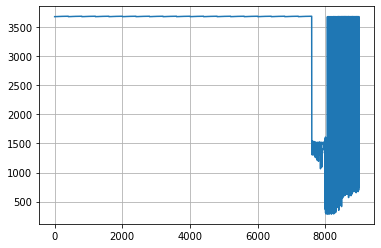

In [14]:
plt.plot([trial.value for trial in study.trials])
plt.grid()
plt.show()

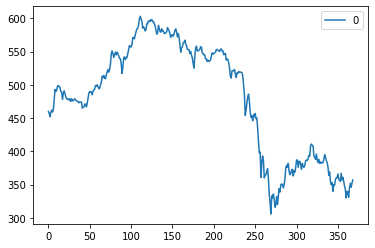

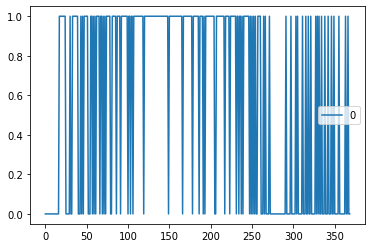

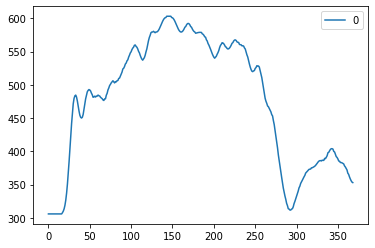

In [15]:
plot_result(**study.best_params)

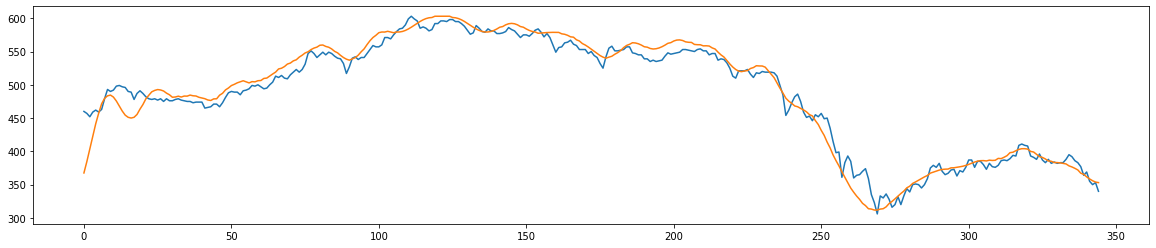

In [16]:
plot_result_co(**study.best_params)